> **Note:**  
> This notebook is a cleaned version of my MSc dissertation experiments for the *EBITDA* metric.  
> Sensitive paths and data references have been removed.  
> Code can be run with compatible datasets placed in `../data/`.

# EBITDA - RESIDUAL MODELS

In [1]:
import json
from pathlib import Path
import copy

import random, os
import pandas as pd
import numpy as np
import cupy as cp
from scipy import stats
from scipy.stats import kurtosis, skew
from statsmodels.distributions.empirical_distribution import ECDF
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import re

from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.metrics import (mean_absolute_error, root_mean_squared_error, r2_score)
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.isotonic import IsotonicRegression

from lightgbm import LGBMRegressor
import xgboost as xgb

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler
import torch.optim as optim

from dataclasses import dataclass, field
from typing import Callable, Optional, Any, Sequence
from properscoring import crps_ensemble as calc_crps

from tqdm import tqdm

In [2]:
import warnings
warnings.filterwarnings("ignore", message=".*force_all_finite.*", category=FutureWarning)

In [3]:
# define the metric dataset for the notebook
metric = "EBITDA"

In [4]:
# Configuration mapping
metric_config = {
    "EBIT": {"df_key": "ebit", "prefix": "EBIT"},
    "EBITDA": {"df_key": "ebitda", "prefix": "EBITDA"},
    "Revenue": {"df_key": "revenue", "prefix": "Revenue"},
    "Net Income": {"df_key": "income", "prefix": "NetIncome"},
    "EPS": {"df_key": "eps", "prefix": "EPS"},
}

In [5]:
DATA_DIR = Path("../data/") # ADD file location path (omitted for privacy)
RANDOM_STATE = 42
N_SPLITS = 3
GAP = 1

In [6]:
def load_sorted(csv_path):
    df = pd.read_csv(csv_path, parse_dates=["window_end"])
    return df.sort_values("window_end", kind="mergesort").reset_index(drop=True)

In [7]:
cfg = metric_config[metric]
df_key = cfg["df_key"]
col_prefix = cfg["prefix"]

In [8]:
train_file = f"{df_key}_FINAL_CM_train.csv"
val_file = f"{df_key}_FINAL_CM_val.csv"

In [9]:
train_df = load_sorted(DATA_DIR / train_file)
val_df = load_sorted(DATA_DIR / val_file)

In [10]:
test_file = f"{df_key}_FINAL_CM_test.csv"
test_df = load_sorted(DATA_DIR / test_file)

# Load features

In [11]:
with open(DATA_DIR / "final_model_vars_by_purpose_CROSSMETRIC.json") as fh:
    feature_vars = json.load(fh)

In [12]:
class Namespace:
    pass

In [13]:
features = Namespace()
for k, v in feature_vars.items():
    setattr(features, k, v)

## Language residual features

In [14]:
text_feats = (
    getattr(features, f"{df_key}_structural_feats")
    + getattr(features, f"{df_key}_text_engineered_feats")
    + getattr(features, f"{df_key}_sentiment_feats")
    + features.macro_controls
    + features.timing_controls
)

In [15]:
text_cat_cols = features.transcript_feat_cats

## Analyst residual features

In [16]:
analyst_feats = (
    getattr(features, f"{df_key}_cross_metric_est_feats")
    + getattr(features, f"{df_key}_target_est_feats")
    + features.analyst_revision_volatility_feats
    + features.macro_controls
    + features.timing_controls
)

In [17]:
analyst_cat_cols = (
    getattr(features, f"{df_key}_cross_metric_flags")
    + getattr(features, f"{df_key}_target_flags")
    #+ features.analyst_revision_dynamic_flags
)

## Hybrid residual features

In [18]:
hybrid_numeric_feats = (
    getattr(features, f"{df_key}_structural_feats")
    + getattr(features, f"{df_key}_text_engineered_feats")
    + getattr(features, f"{df_key}_sentiment_feats")
    + getattr(features, f"{df_key}_cross_metric_est_feats")
    + getattr(features, f"{df_key}_target_est_feats")
    + features.analyst_revision_volatility_feats
    + features.macro_controls
    + features.timing_controls
)

hybrid_cat_cols = (
    getattr(features, f"{df_key}_cross_metric_flags")
    + getattr(features, f"{df_key}_target_flags")
    + features.transcript_feat_cats
    #+ features.analyst_revision_dynamic_flags
)

# Evaluation functions

In [19]:
# Evaluate if direction of surprise (i.e. if a postive or negative surprise) is correct or not
def directional_hit(y_true, y_pred):
    return (np.sign(y_true) == np.sign(y_pred)).mean()

In [20]:
# Evaluate surprise prediction
def evaluate_surprise(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)
    hit = directional_hit(y_true, y_pred)
    return mae, rmse, hit

In [21]:
# Calculate 'actual' from predicted residual
def evaluate_actuals_from_residual(actual, consensus, pred_surprise):
    pred_actual = consensus + pred_surprise
    mae = mean_absolute_error(actual, pred_actual)
    rmse = root_mean_squared_error(actual, pred_actual)
    mape = np.mean(np.abs((actual - pred_actual) / np.maximum(np.abs(actual), 1e-12)))
    r2 = r2_score(actual, pred_actual)
    return mae, rmse, mape, r2

In [22]:
# For MLP monitoring/evaluating
def plot_history(hist):
    fig, axs = plt.subplots(1, 4, figsize=(24, 4))

    axs[0].plot(hist["batch_loss"])
    axs[0].set_title("Batch Loss")

    axs[1].plot(hist["train_rmse"], label="train")
    axs[1].plot(hist["val_rmse"], label="val")
    axs[1].set_title("RMSE per epoch")
    axs[1].legend()

    axs[2].plot(hist["train_mae"], label="train")
    axs[2].plot(hist["val_mae"], label="val")
    axs[2].set_title("MAE per epoch")
    axs[2].legend()

    axs[3].plot(hist["train_hit"], label="train")
    axs[3].plot(hist["val_hit"], label="val")
    axs[3].set_title("Hit ratio per epoch")
    axs[3].legend()

    plt.tight_layout()
    plt.show()

## Statistical significance test - Diebold-Mariano test on MAE

In [23]:
def dm_test_mae(y_true, forecast1, forecast2, h=1, alternative="two-sided", lags=None):
    # Absolute error differences
    e1 = np.abs(y_true - forecast1)
    e2 = np.abs(y_true - forecast2)
    d = e1 - e2

    # Drop NaNs if any
    d = d[~np.isnan(d)]

    # Choose number of lags: default is h - 1 (as per DM paper suggestion)
    if lags is None:
        lags = h - 1 if h > 1 else 0

    # Regress d_t on constant to get mean and robust std error
    model = sm.OLS(d, np.ones(len(d)))  # constant-only regression
    results = model.fit(cov_type='HAC', cov_kwds={'maxlags': lags})
    
    dm_stat = results.tvalues[0]
    p = None

    if alternative == "two-sided":
        p = 2 * (1 - stats.norm.cdf(abs(dm_stat)))
    elif alternative == "less":
        p = stats.norm.cdf(dm_stat)
    elif alternative == "greater":
        p = 1 - stats.norm.cdf(dm_stat)

    return dm_stat, p

In [24]:
def run_dm_mae(y_true, pred_model, pred_baseline, alpha=0.05, alternative="less", h=1):
    stat, p = dm_test_mae(y_true, pred_model, pred_baseline, h=h, alternative=alternative)
    return {"DM": stat, "p": p, "better": p < alpha}

##  GBDT Models - Evaluate performance metrics 

In [25]:
def evaluate_gbdt_model_metrics(y_true, results, baseline_pred, h=1, alpha=0.05, alternative="less"):
    dm_rows = []
    baseline_key = [k for k in results["actuals"] if k.endswith("-baseline")][0]
    
    for mdl_key in results["preds"]:
        if mdl_key.endswith("-baseline"):
            continue

        pred_model = results["preds"][mdl_key]

        dm_info = run_dm_mae(
            y_true, 
            pred_model, 
            baseline_pred, 
            h=h, 
            alpha=alpha, 
            alternative=alternative
        )
        
        dm_rows.append({
            "Model": mdl_key,
            **dm_info,
            "Δ_MAE": results["actuals"][mdl_key]["MAE"] - results["actuals"][baseline_key]["MAE"]
        })

    dm_df = pd.DataFrame(dm_rows).sort_values("p").reset_index(drop=True)
    dm_df = dm_df.round({"DM": 3, "p": 4, "Δ_MAE": 4})

    surprise_df = (
        pd.DataFrame(results["surprise"]).T
        .sort_index()
        .round({"MAE": 4, "RMSE": 4, "HitRatio": 4})
    )

    actuals_df = (
        pd.DataFrame(results["actuals"]).T
        .sort_index()
        .round({"MAE": 4, "RMSE": 4, "MAPE": 4, "R2": 4})
    )

    return dm_df, surprise_df, actuals_df

## MLP Models - Evaluate performance metrics

In [26]:
def evaluate_mlp_model_metrics(metrics_df, y_true, baseline_pred, h=1, alpha=0.05, alternative="less", metric_name="MAE"):
    def mape(y_true, y_pred):
        return np.mean(np.abs((y_true - y_pred) / np.maximum(np.abs(y_true), 1e-12)))

    mae_b = mean_absolute_error(y_true, baseline_pred)
    rmse_b = root_mean_squared_error(y_true, baseline_pred)
    mape_b = mape(y_true, baseline_pred)
    r2_b = r2_score(y_true, baseline_pred)

    actuals_rows = [{
        "Model": "EBITDA-baseline",
        "Seed": "baseline",
        "MAE": mae_b,
        "RMSE": rmse_b,
        "MAPE": mape_b,
        "R2": r2_b,
        "CRPS": None,
        "Coverage": None
    }]

    dm_rows = []
    surprise_rows = []

    for _, row in metrics_df.iterrows():
        model_name = row["Model"]
        seed = row["Seed"]
        y_pred = row["PredActual"]
        samples = row.get("MC_Samples", None)

        # DM test
        dm_stat, dm_p = dm_test_mae(
            y_true=y_true,
            forecast1=y_pred,
            forecast2=baseline_pred,
            h=h,
            alternative=alternative
        )

        dm_rows.append({
            "Model": model_name,
            "Seed": seed,
            "DM": dm_stat,
            "p": dm_p,
            "better": dm_p < alpha,
            "Δ_MAE": row["MAE"] - mae_b
        })

        actuals_rows.append({
            "Model": model_name,
            "Seed": seed,
            "MAE": row["MAE"],
            "RMSE": row["RMSE"],
            "MAPE": row["MAPE"],
            "R2": row["R2"],
            "CRPS": row.get("CRPS"),
            "Coverage": row.get("Coverage")
        })

        surprise_rows.append({
            "Model": model_name,
            "Seed": seed,
            "MAE": row["MAE_s"],
            "RMSE": row["RMSE_s"],
            "HitRatio": row["HitRatio"]
        })

    dm_df = pd.DataFrame(dm_rows).sort_values("p").round({"DM": 3, "p": 4, "Δ_MAE": 4}).reset_index(drop=True)
    actuals_df = pd.DataFrame(actuals_rows).round(4).set_index(["Model", "Seed"])
    surprise_df = pd.DataFrame(surprise_rows).round(4).set_index(["Model", "Seed"])

    return dm_df, surprise_df, actuals_df

In [27]:
def evaluate_mlp_final_test(metrics_df, y_true, baseline_pred, h=1, alpha=0.05, alternative="less", metric_name="MAE"):
    def mape(y_true, y_pred):
        return np.mean(np.abs((y_true - y_pred) / np.maximum(np.abs(y_true), 1e-12)))

    mae_b = mean_absolute_error(y_true, baseline_pred)
    rmse_b = root_mean_squared_error(y_true, baseline_pred)
    mape_b = mape(y_true, baseline_pred)
    r2_b = r2_score(y_true, baseline_pred)

    actuals_rows = [{
        "Model": "Revenue-baseline",
        "Seed": "baseline",
        "MAE": mae_b,
        "RMSE": rmse_b,
        "MAPE": mape_b,
        "R2": r2_b
    }]

    dm_rows = []
    surprise_rows = []

    for _, row in metrics_df.iterrows():
        model_name = row["Model"]
        seed = row["Seed"]
        y_pred = row["PredActual"]
        samples = row.get("MC_Samples", None)

        # DM test
        dm_stat, dm_p = dm_test_mae(
            y_true=y_true,
            forecast1=y_pred,
            forecast2=baseline_pred,
            h=h,
            alternative=alternative
        )

        dm_rows.append({
            "Model": model_name,
            "Seed": seed,
            "DM": dm_stat,
            "p": dm_p,
            "better": dm_p < alpha,
            "Δ_MAE": row["MAE"] - mae_b
        })

        actuals_rows.append({
            "Model": model_name,
            "Seed": seed,
            "MAE": row["MAE"],
            "RMSE": row["RMSE"],
            "MAPE": row["MAPE"],
            "R2": row["R2"]
        })

        surprise_rows.append({
            "Model": model_name,
            "Seed": seed,
            "MAE": row["MAE_s"],
            "RMSE": row["RMSE_s"],
            "HitRatio": row["HitRatio"]
        })

    dm_df = pd.DataFrame(dm_rows).sort_values("p").round({"DM": 3, "p": 4, "Δ_MAE": 4}).reset_index(drop=True)
    actuals_df = pd.DataFrame(actuals_rows).round(4).set_index(["Model", "Seed"])
    surprise_df = pd.DataFrame(surprise_rows).round(4).set_index(["Model", "Seed"])

    return dm_df, surprise_df, actuals_df

## Robustness test for MLP models

In [28]:
def evaluate_mlp_noMC_seed_robustness(metrics_df, y_true, baseline_pred, metric_name = "MAE", alternative = "less", h = 1, dataset_name = None, show_plot = True):
    # Aggregate performance stats
    agg_df = (
        metrics_df
        .groupby("Model")
        .agg(
            runs=("Seed", "size"),
            MAE_mean=("MAE", "mean"),
            MAE_std=("MAE", "std"),
            MAE_ci95=("MAE", lambda s: 1.96 * s.std(ddof=0) / np.sqrt(len(s))),
            RMSE_mean=("RMSE", "mean"),
            RMSE_std=("RMSE", "std"),
            Hit_mean=("HitRatio", "mean"),
            R2_mean=("R2", "mean")
        )
        .reset_index()
        .sort_values("MAE_mean")
    )

    # DM test across all seeds 
    dm_rows = []
    for _, row in metrics_df.iterrows():
        dm_stat, dm_p = dm_test_mae(
            y_true=y_true,
            forecast1=row["PredActual"],
            forecast2=baseline_pred,
            h=h,
            alternative=alternative
        )
        dm_rows.append({
            "Seed": row["Seed"],
            "Model": row["Model"],
            "DM": dm_stat,
            "p": dm_p,
            "beat_baseline": dm_p < 0.05
        })

    dm_df = pd.DataFrame(dm_rows)

    dm_summary = (
        dm_df.groupby("Model")
        .agg(
            DM_mean=("DM", "mean"),
            DM_std=("DM", "std"),
            beat_rate=("beat_baseline", "mean")
        )
        .assign(**{
            "% of seeds beating baseline": lambda df: df["beat_rate"] * 100
        })
        .drop(columns="beat_rate")
        .reset_index()
    )

    # Boxplot visual to show distribution of model performance
    if show_plot:
        plt.figure(figsize=(12, 4))
        sns.boxplot(data=metrics_df, x="Model", y=metric_name)
        plt.title(f"{metric_name} distribution across seeds" + (f" ({dataset_name})" if dataset_name else ""))
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        plt.show()

    # Merge & summarise
    summary_df = agg_df.merge(dm_summary, on="Model", how="left")
    summary_df["MAE_mean_std"] = summary_df.apply(lambda row: f"{row['MAE_mean']:.1f} ± {row['MAE_std']:.1f}", axis=1)

    final_summary = summary_df[[
        "Model", "MAE_mean_std", "MAE_ci95",
        "RMSE_mean", "Hit_mean", "R2_mean",
        "DM_mean", "DM_std",
        "% of seeds beating baseline"
    ]].round(4)

    title = f"=== Final summary for {dataset_name} ===" if dataset_name else "=== Final summary ==="
    print(title)
    display(final_summary)

    return final_summary

In [29]:
def evaluate_mlp_seed_robustness(metrics_df, y_true, baseline_pred, metric_name="MAE", alternative="less", h=1, dataset_name=None, show_plot=True):
    group_cols = ["Model"]
    
    ensemble_df = metrics_df[metrics_df["Seed"] == "Ensemble"]
    per_seed_df = metrics_df[metrics_df["Seed"] != "Ensemble"]
    
    agg_df = (
        per_seed_df
        .groupby(group_cols)
        .agg(
            runs=("Seed", "size"),
            MAE_mean=("MAE", "mean"),
            MAE_std=("MAE", "std"),
            MAE_ci95=("MAE", lambda s: 1.96 * s.std(ddof=0) / np.sqrt(len(s))),
            RMSE_mean=("RMSE", "mean"),
            Hit_mean=("HitRatio", "mean"),
            R2_mean=("R2", "mean"),
            CRPS_mean=("CRPS", "mean"),
            Coverage_mean=("Coverage", "mean")
        )
        .reset_index()
        .sort_values("MAE_mean")
    )
    agg_df["SummaryType"] = "Mean across seeds"

    # DM test per seed
    dm_rows = []
    for _, row in per_seed_df.iterrows():
        dm_stat, dm_p = dm_test_mae(
            y_true=y_true,
            forecast1=row["PredActual"],
            forecast2=baseline_pred,
            h=h,
            alternative=alternative
        )
        dm_rows.append({
            "Seed": row["Seed"],
            "Model": row["Model"],
            "DM": dm_stat,
            "p": dm_p,
            "beat_baseline": dm_p < 0.05
        })

    dm_df = pd.DataFrame(dm_rows)

    dm_summary = (
        dm_df.groupby("Model")
        .agg(
            DM_mean=("DM", "mean"),
            DM_std=("DM", "std"),
            beat_rate=("beat_baseline", "mean")
        )
        .assign(**{
            "% of seeds beating baseline": lambda df: df["beat_rate"] * 100
        })
        .drop(columns="beat_rate")
        .reset_index()
    )

    # Boxplot
    if show_plot:
        plt.figure(figsize=(12, 4))
        sns.boxplot(data=per_seed_df, x="Model", y=metric_name)
        plt.title(f"{metric_name} distribution across seeds" + (f" ({dataset_name})" if dataset_name else ""))
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        plt.show()

    # Merge summary
    summary_df = agg_df.merge(dm_summary, on="Model", how="left")
    summary_df["MAE_mean_std"] = summary_df.apply(lambda row: f"{row['MAE_mean']:.1f} ± {row['MAE_std']:.1f}", axis=1)

    final_summary = summary_df[[
        "Model", "SummaryType", "MAE_mean_std", "MAE_ci95",
        "RMSE_mean", "Hit_mean", "R2_mean",
        "CRPS_mean", "Coverage_mean",
        "DM_mean", "DM_std",
        "% of seeds beating baseline"
    ]].round(4)

    if not ensemble_df.empty:
        ensemble_stats = ensemble_df[["Model", "MAE", "RMSE", "HitRatio", "R2", "CRPS", "Coverage"]].copy()
        ensemble_stats["SummaryType"] = "Ensemble"
        ensemble_stats["MAE_mean_std"] = ensemble_stats["MAE"].map(lambda v: f"{v:.1f}")
        ensemble_stats["MAE_ci95"] = np.nan
        ensemble_stats["DM_mean"] = np.nan
        ensemble_stats["DM_std"] = np.nan
        ensemble_stats["% of seeds beating baseline"] = np.nan
        ensemble_stats = ensemble_stats.rename(columns={
            "MAE": "MAE_mean",
            "RMSE": "RMSE_mean",
            "HitRatio": "Hit_mean",
            "R2": "R2_mean",
            "CRPS": "CRPS_mean",
            "Coverage": "Coverage_mean"
        })[final_summary.columns]
        final_summary = pd.concat([final_summary, ensemble_stats], ignore_index=True)

    print(f"=== Final summary {'for ' + dataset_name if dataset_name else ''} ===")
    display(final_summary)

    return final_summary

## Plot comparison Model vs Consensus comparison plots

In [31]:
def plot_model_vs_consensus_triplet_from_dict(
    model_pattern,
    results_dict,
    actual,
    consensus,
    include_baseline=False,
    baseline_name="Consensus",
    titlesuffix=True,
    bins=50,
    figsize=(18, 5)
):
    # Calculate true surprise directly
    true_surprise = actual - consensus

    # Filter models (optionally remove baselines)
    preds = results_dict["preds"]
    filtered_preds = {
        name: pred for name, pred in preds.items()
        if include_baseline or not name.endswith("baseline")
    }

    # Match model name from pattern
    matched = [name for name in filtered_preds if model_pattern in name]
    if not matched:
        raise ValueError(f"No model names matched pattern '{model_pattern}'")
    model_name = matched[0]
    model_pred = np.array(filtered_preds[model_name])

    title_suffix = f"\n{model_name}" if titlesuffix else ""

    # Compute derived values
    model_error = np.abs(actual - model_pred)
    consensus_error = np.abs(actual - consensus)
    improvement = consensus_error - model_error

    # Compute residuals: error in predicted surprise
    predicted_surprise = model_pred - consensus
    residuals = true_surprise - predicted_surprise
    baseline_residuals = true_surprise

    win_mask = improvement > 0
    loss_mask = improvement < 0

    fig, axes = plt.subplots(1, 3, figsize=figsize)

    # Plot 1: Error Comparison
    axes[0].scatter(consensus_error[win_mask], model_error[win_mask], c='green', label='Model Better', alpha=0.6)
    axes[0].scatter(consensus_error[loss_mask], model_error[loss_mask], c='red', label='Consensus Better', alpha=0.6)
    max_val = max(consensus_error.max(), model_error.max())
    axes[0].plot([0, max_val], [0, max_val], linestyle='--', color='black', label='Parity Line')
    axes[0].set_xlabel("Consensus Absolute Error")
    axes[0].set_ylabel("Model Absolute Error")
    axes[0].set_title(f"Model vs. Consensus: Absolute Error Per Sample{title_suffix}")
    axes[0].legend()
    axes[0].grid(True)

    # Plot 2: Improvement vs. True Surprise
    axes[1].scatter(true_surprise[win_mask], improvement[win_mask], c='green', alpha=0.6)
    axes[1].scatter(true_surprise[loss_mask], improvement[loss_mask], c='red', alpha=0.6)
    axes[1].axhline(0, linestyle='--', color='black')
    axes[1].set_xlabel("True Surprise (Actual − Consensus)")
    axes[1].set_ylabel("Improvement in Absolute Error\n($\\Delta \\epsilon = \\epsilon_{\\mathrm{consensus}} - \\epsilon_{\\mathrm{model}}$)")
    axes[1].set_title(f"Model Improvement vs. Surprise Magnitude{title_suffix}")
    axes[1].grid(True)

    # Plot 3: Residual Distribution
    sns.histplot(baseline_residuals, bins=bins, kde=True, label=f"{baseline_name}", color="orange", alpha=0.4, ax=axes[2])
    sns.histplot(residuals, bins=bins, kde=True, label=f"{model_name}", color="blue", alpha=0.4, ax=axes[2])
    axes[2].axvline(0, color='black', linestyle='--', label="No Error")
    axes[2].set_title(f"Residual Distribution\n(True Surprise − Predicted Surprise){title_suffix}")
    axes[2].set_xlabel("Residual")
    axes[2].set_ylabel("Frequency")
    axes[2].legend()
    axes[2].grid(True)

    # Shared legend
    handles = [
        mpatches.Patch(color='green', label='Model Better'),
        mpatches.Patch(color='red', label='Consensus Better')
    ]
    fig.legend(handles=handles, loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.02), frameon=False)

    plt.tight_layout()
    plt.subplots_adjust(bottom=0.15)
    plt.show()

    # Summary stats
    n_win = np.sum(model_error < consensus_error)
    n_loss = np.sum(model_error > consensus_error)
    n_tie = np.sum(model_error == consensus_error)
    n_total = len(actual)

    print(f"\n[Comparison Summary: {model_name}]")
    print(f"Model better in {n_win} of {n_total} samples ({n_win / n_total:.1%})")
    print(f"Consensus better in {n_loss} of {n_total} samples ({n_loss / n_total:.1%})")
    print(f"Tie in {n_tie} of {n_total} samples ({n_tie / n_total:.1%})")

In [32]:
def plot_model_vs_consensus_triplet(model_pattern, actual, consensus, df=None, baseline_name="Consensus", metric="MAE", titlesuffix=True, bins=50, figsize=(18, 5),):

    # Match first row where 'Model' contains the pattern
    matched_rows = df[df["Model"].str.contains(model_pattern, regex=False)]
    row = matched_rows.iloc[0]

    model_pred = row["PredActual"]
    model_name = row["Model"]
    if titlesuffix:
        title_suffix = f"{row['Embed']} / nPCs={row['n_PCs']}"
    else:
        title_suffix=""

    # Extract clean name from inside brackets
    match = re.search(r"\((.*?)\)", model_name)
    clean_model_name = match.group(1) if match else model_name

    consensus_error = np.abs(actual - consensus)
    model_error = np.abs(actual - model_pred)
    true_surprise = actual - consensus
    improvement = consensus_error - model_error
    residuals = true_surprise - (model_pred - consensus)
    baseline_residuals = true_surprise  # baseline = consensus

    win_mask = improvement > 0
    loss_mask = improvement < 0

    fig, axes = plt.subplots(1, 3, figsize=figsize)

    # Plot 1: Model vs. Consensus Error
    axes[0].scatter(consensus_error[win_mask], model_error[win_mask], c='green', label='Model Better', alpha=0.6)
    axes[0].scatter(consensus_error[loss_mask], model_error[loss_mask], c='red', label='Consensus Better', alpha=0.6)
    max_val = max(consensus_error.max(), model_error.max())
    axes[0].plot([0, max_val], [0, max_val], linestyle='--', color='black', label='Parity Line')
    axes[0].set_xlabel("Consensus Absolute Error")
    axes[0].set_ylabel("Model Absolute Error")
    axes[0].set_title(f"Model vs. Consensus: Absolute Error Per Sample\n{title_suffix}")
    axes[0].legend()
    axes[0].grid(True)

    # Plot 2: Improvement vs. True Surprise
    axes[1].scatter(true_surprise[win_mask], improvement[win_mask], c='green', alpha=0.6)
    axes[1].scatter(true_surprise[loss_mask], improvement[loss_mask], c='red', alpha=0.6)
    axes[1].axhline(0, linestyle='--', color='black')
    axes[1].set_xlabel("True Surprise (Actual − Consensus)")
    axes[1].set_ylabel("Improvement in Absolute Error\n($\\Delta \\epsilon = \\epsilon_{\\mathrm{consensus}} - \\epsilon_{\\mathrm{model}}$)")
    axes[1].set_title(f"Model Improvement vs. Surprise Magnitude\n{title_suffix}")
    axes[1].grid(True)

    # Plot 3: Residual Distribution
    sns.histplot(baseline_residuals, bins=bins, kde=True, label=f"{baseline_name}", color="orange", alpha=0.4, ax=axes[2])
    sns.histplot(residuals, bins=bins, kde=True, label=f"{clean_model_name}", color="blue", alpha=0.4, ax=axes[2])
    axes[2].axvline(0, color='black', linestyle='--', label="No Error")
    axes[2].set_title(f"Residual Distribution\n(True Surprise − Predicted Surprise)\n{title_suffix}")
    axes[2].set_xlabel("Residual")
    axes[2].set_ylabel("Frequency")
    axes[2].legend()
    axes[2].grid(True)

    # Shared legend
    handles = [mpatches.Patch(color='green', label='Model Better'), mpatches.Patch(color='red', label='Consensus Better')]
    fig.legend(handles=handles, loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.02))

    plt.tight_layout()
    plt.subplots_adjust(bottom=0.15)
    plt.show()

    # Print model win vs consensus win (with ties)
    is_model_better = model_error < consensus_error
    is_consensus_better = model_error > consensus_error
    is_tied = model_error == consensus_error

    n_win = np.sum(is_model_better)
    n_loss = np.sum(is_consensus_better)
    n_tie = np.sum(is_tied)
    n_total = len(actual)

    print(f"\n[Comparison Summary: {clean_model_name}]")
    print(f"Model better in {n_win} of {n_total} samples ({n_win / n_total:.1%})")
    print(f"Consensus better in {n_loss} of {n_total} samples ({n_loss / n_total:.1%})")
    print(f"Tie in {n_tie} of {n_total} samples ({n_tie / n_total:.1%})")

## Evaluate tail behaviour

In [33]:
def evaluate_tail_behaviour(pred_input, consensus, actual, model_name=None, include_baseline=False, plot=True, log_kde_y='auto'):

    def compute_metrics(pred_actual, name, type_):
        true_surprise = actual - consensus
        pred_surprise = pred_actual - consensus
        model_errors = np.abs(actual - pred_actual)

        # Percentile-based tails
        tail_threshold = np.percentile(model_errors, 95)
        tail_mae = model_errors[model_errors >= tail_threshold].mean()

        # Threshold-based tails (e.g., >10% relative surprise to consensus)
        relative_surprise = (actual - consensus) / np.maximum(np.abs(consensus), 1e-6)
        threshold_mask = np.abs(relative_surprise) > 0.10

        thresh_mae = model_errors[threshold_mask].mean() if np.any(threshold_mask) else np.nan

        # Directional tails
        pos_tail = true_surprise > np.percentile(true_surprise, 90)
        neg_tail = true_surprise < np.percentile(true_surprise, 10)

        mae_pos = np.mean(np.abs(true_surprise[pos_tail] - pred_surprise[pos_tail]))
        mae_neg = np.mean(np.abs(true_surprise[neg_tail] - pred_surprise[neg_tail]))

        # Plotting (only for models, not baseline)
        if plot and type_ != "baseline":
            ecdf_model = ECDF(model_errors)
            ecdf_baseline = ECDF(np.abs(actual - consensus))
        
            fig, axs = plt.subplots(1, 3, figsize=(18, 5))
        
            # ECDF plot
            axs[0].plot(ecdf_model.x, ecdf_model.y, label=name, linewidth=2)
            axs[0].plot(ecdf_baseline.x, ecdf_baseline.y, label="Consensus", linewidth=2, linestyle="--")
            axs[0].set_title("ECDF of Absolute Errors")
            axs[0].set_xlabel("Absolute Error")
            axs[0].set_ylabel("Cumulative Probability")
            axs[0].legend()
        
            # KDE plot
            sns.kdeplot(true_surprise, label="Actual Surprise", ax=axs[1])
            sns.kdeplot(pred_surprise, label="Predicted Surprise", ax=axs[1], linestyle="--")
            axs[1].set_title("KDE of Surprise")
        
            # Automatically decide log scale
            if log_kde_y == 'auto':
                k = kurtosis(true_surprise, fisher=False)
                s = skew(true_surprise)
                if k > 4 or abs(s) > 1:
                    axs[1].set_yscale('log')
            elif log_kde_y is True:
                axs[1].set_yscale('log')
        
            axs[1].legend()
        
            # Boxplot
            axs[2].boxplot([np.abs(actual - consensus), model_errors], tick_labels=["Consensus", name])
            axs[2].set_title("Boxplot of Absolute Errors")
            axs[2].set_ylabel("Absolute Error")
        
            plt.suptitle(f"Tail Diagnostics – {name}")
            plt.tight_layout()
            plt.show()
        
        return {
            "Model": name,
            "Type": type_,
            "MAE": np.mean(model_errors),
            "RMSE": np.sqrt(np.mean((actual - pred_actual) ** 2)),
            "95th %ile Abs Error": tail_threshold,
            "Mean Abs Error in Tail": tail_mae,
            "MAE on Surprise >±10%": thresh_mae,
            "Tail MAE (Positive Surprise)": mae_pos,
            "Tail MAE (Negative Surprise)": mae_neg
        }
    
    def compute_baseline():
        return compute_metrics(consensus, "Baseline", type_="baseline")

    results = []

    # IF single array
    if isinstance(pred_input, (np.ndarray, list)):
        if include_baseline:
            results.append(compute_baseline())
        name = model_name or "Model"
        results.append(compute_metrics(np.array(pred_input), name, type_="model"))

    # IF dict of models
    elif isinstance(pred_input, dict) and "preds" in pred_input:
        for name, pred_actual in pred_input["preds"].items():
            is_baseline = name.endswith("baseline")
            if is_baseline and not include_baseline:
                continue
            elif is_baseline and include_baseline:
                name = "Baseline"
            results.append(compute_metrics(np.array(pred_actual), name, type_="baseline" if is_baseline else "model"))

    # IF df with 'Model' and 'PredActual' cols
    elif isinstance(pred_input, pd.DataFrame):
        if not {"Model", "PredActual"}.issubset(pred_input.columns):
            raise ValueError("DataFrame must contain 'Model' and 'PredActual' columns.")
        if include_baseline:
            results.append(compute_baseline())
        for _, row in pred_input.iterrows():
            name = row["Model"]
            pred_actual = np.array(row["PredActual"])
            results.append(compute_metrics(pred_actual, name, type_="model"))

    df_results = pd.DataFrame(results)
    col_order = [
        "Model",
        "Type",
        "MAE",
        "RMSE",
        "95th %ile Abs Error",
        "Mean Abs Error in Tail",
        "MAE on Surprise >±10%",
        "Tail MAE (Positive Surprise)",
        "Tail MAE (Negative Surprise)"
    ]

    return df_results[col_order].round(2)

# Pre-processing

## Pre-processing helper functions

*For XGBoost & LightGBM pre-processing*

In [34]:
def fit_pca_and_transform_embeddings(train_df, val_df, emb_cols, prefix, n_components=120):
    pca = PCA(n_components=n_components, random_state=RANDOM_STATE)
    train_emb = pca.fit_transform(train_df[emb_cols])
    val_emb = pca.transform(val_df[emb_cols])

    pca_cols = [f"{prefix}_PC_{i+1}" for i in range(n_components)]
    train_df_pca = pd.DataFrame(train_emb, columns=pca_cols, index=train_df.index)
    val_df_pca = pd.DataFrame(val_emb, columns=pca_cols, index=val_df.index)
    return train_df_pca, val_df_pca

In [35]:
def fit_scaler(train_df, val_df, txt_cols):
    scaler = StandardScaler()
    train_scaled = scaler.fit_transform(train_df[txt_cols])
    val_scaled = scaler.transform(val_df[txt_cols])
    return train_scaled, val_scaled

In [36]:
def fit_onehot_encoder(train_df, val_df, cat_cols):
    encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    train_encoded = encoder.fit_transform(train_df[cat_cols])
    val_encoded = encoder.transform(val_df[cat_cols])
    return train_encoded, val_encoded

In [37]:
def fit_ordinal_encoder(train_df, val_df, cat_cols):
    encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
    train_encoded = encoder.fit_transform(train_df[cat_cols])
    val_encoded = encoder.transform(val_df[cat_cols])
    return train_encoded, val_encoded

*For MLP pre-processing*

In [38]:
def build_preprocessor(numeric_cols, cat_cols, emb_cols):
    transformers = []
    
    if numeric_cols:
        transformers.append(("numeric", StandardScaler(), numeric_cols))
    
    if emb_cols:
        transformers.append(("emb_pca", Pipeline([("pca", PCA(n_components=100, random_state=RANDOM_STATE))]),emb_cols))
    
    if cat_cols:transformers.append(("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols))

    return ColumnTransformer(transformers)

## XGBoost preprocessing

*Language features*

In [39]:
lang_preproc_xgb = {}

for emb_prefix in ["full"]:
    emb_cols = [c for c in train_df.columns if c.startswith(f"embedding_{emb_prefix}_")]
    train_pca, val_pca = fit_pca_and_transform_embeddings(train_df, val_df, emb_cols, prefix=emb_prefix)
    lang_preproc_xgb[f"{emb_prefix}_pca_train"] = train_pca
    lang_preproc_xgb[f"{emb_prefix}_pca_val"] = val_pca

lang_preproc_xgb["txt_train"], lang_preproc_xgb["txt_val"] = fit_scaler(train_df, val_df, text_feats)
lang_preproc_xgb["cat_train"], lang_preproc_xgb["cat_val"] = fit_onehot_encoder(train_df, val_df, text_cat_cols)
lang_preproc_xgb["y_train"] = train_df["surp_cons_raw"]
lang_preproc_xgb["y_val"] = val_df["surp_cons_raw"]
lang_preproc_xgb["train_df"] = train_df
lang_preproc_xgb["val_df"] = val_df

*Analyst residual features*

In [40]:
analyst_preproc_xgb = {}

analyst_preproc_xgb["analyst_train"], analyst_preproc_xgb["analyst_val"] = fit_scaler(train_df, val_df, analyst_feats)
analyst_preproc_xgb["cat_train"], analyst_preproc_xgb["cat_val"] = fit_onehot_encoder(train_df, val_df, analyst_cat_cols)
analyst_preproc_xgb["y_train"] = train_df["surp_cons_raw"]
analyst_preproc_xgb["y_val"] = val_df["surp_cons_raw"]
analyst_preproc_xgb["train_df"] = train_df
analyst_preproc_xgb["val_df"] = val_df

## LightGMB preprocessing

*Language features*

In [41]:
lang_preproc_lgbm = {}

for emb_prefix in ["full"]:
    emb_cols = [c for c in train_df.columns if c.startswith(f"embedding_{emb_prefix}_")]
    train_pca, val_pca = fit_pca_and_transform_embeddings(train_df, val_df, emb_cols, prefix=emb_prefix)
    lang_preproc_lgbm[f"{emb_prefix}_pca_train"] = train_pca
    lang_preproc_lgbm[f"{emb_prefix}_pca_val"] = val_pca

lang_preproc_lgbm["txt_train"], lang_preproc_lgbm["txt_val"] = fit_scaler(train_df, val_df, text_feats)
lang_preproc_lgbm["cat_train"], lang_preproc_lgbm["cat_val"] = fit_ordinal_encoder(train_df, val_df, text_cat_cols)
lang_preproc_lgbm["y_train"] = train_df["surp_cons_raw"]
lang_preproc_lgbm["y_val"] = val_df["surp_cons_raw"]
lang_preproc_lgbm["train_df"] = train_df
lang_preproc_lgbm["val_df"] = val_df

*Analyst residual features*

In [42]:
analyst_preproc_lgbm = {}

analyst_preproc_lgbm["analyst_train"], analyst_preproc_lgbm["analyst_val"] = fit_scaler(train_df, val_df, analyst_feats)
analyst_preproc_lgbm["cat_train"], analyst_preproc_lgbm["cat_val"] = fit_ordinal_encoder(train_df, val_df, analyst_cat_cols)
analyst_preproc_lgbm["y_train"] = train_df["surp_cons_raw"]
analyst_preproc_lgbm["y_val"] = val_df["surp_cons_raw"]
analyst_preproc_lgbm["train_df"] = train_df
analyst_preproc_lgbm["val_df"] = val_df

# Model configurations

## XGBoost

In [43]:
def build_xgb_pipeline():
    return Pipeline([
        ("model", xgb.XGBRegressor(
            objective="reg:squarederror",
            tree_method="hist",
            device="cuda",
            random_state=RANDOM_STATE))
    ])

In [44]:
def xgb_run_grid_search(X_train, y_train, param_grid, cv):   
    pipeline = build_xgb_pipeline()
    
    gs = GridSearchCV(
        estimator=pipeline,
        param_grid={"model__" + k: v for k, v in param_grid.items()},
        scoring="neg_mean_squared_error",
        cv=cv,
        refit=True,
        n_jobs=-1,
        verbose=0
    )
    gs.fit(X_train, y_train)
    return gs

## LightGBM

In [45]:
def build_lgbm_pipeline():
    return Pipeline([
        ("model",LGBMRegressor(
        boosting_type="gbdt",
        device_type="gpu",
        objective="regression",
        random_state=RANDOM_STATE,
        verbose=-1))
    ])

In [46]:
def lgbm_run_grid_search(X_train, y_train, param_grid, cv):   
    pipeline = build_lgbm_pipeline()
    
    gs = GridSearchCV(
        estimator=pipeline,
        param_grid={"model__" + k: v for k, v in param_grid.items()},
        scoring="neg_mean_squared_error",
        cv=cv,
        refit=True,
        n_jobs=-1,
        verbose=0
    )
    gs.fit(X_train, y_train)
    return gs

## MLP

In [47]:
def set_global_seed(seed: int = 42) -> None:
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [48]:
# Prepare features for dataloader
class MetricDataset(Dataset):
    def __init__(self, X, y):
        if hasattr(X, "to_numpy"):
            X = X.to_numpy()
        self.X = torch.as_tensor(X, dtype=torch.float32)

        if hasattr(y, "values"):
            y = y.values
        self.y = torch.as_tensor(y, dtype=torch.float32).squeeze()

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [49]:
# Custom configuration for training MLP model. Stores all hyperparameters and training options, including model type, input size, optimizer, scheduler, loss function, early stopping, gradient clipping, device, and other training behaviours.
@dataclass
class TrainerConfig:
    model_class: Callable
    input_dim: int
    num_epochs: int = 100
    batch_size: int = 128
    lr: float = 1e-3
    weight_decay: float = 1e-5
    early_stop_patience: int = 10
    loss_fn: Optional[Callable] = None
    optimizer_fn: Optional[Callable] = None
    scheduler_fn: Optional[Callable] = None
    scaler: Optional[Any] = None
    clip_grad_norm: Optional[float] = 1.0
    weight_init_fn: Optional[Callable] = None
    device: Optional[Any] = None
    show_progress: bool = True
    mc_dropout: bool = False
    mc_passes: int = 30
    evaluate_mc_per_seed: bool = False
    calibrate_intervals: bool = False
    target_coverage: float = 0.90
    deep_ensemble: bool = False

In [50]:
# Weight initialisation strategy - option to include in training config
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

In [51]:
class MLPTrainer:
    def __init__(self, train_loader, X_train, y_train, X_val, y_val, config: TrainerConfig):
        self.config = config
        self.device = config.device or torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = config.model_class(input_dim=config.input_dim).to(self.device)

        if config.weight_init_fn:
            self.model.apply(config.weight_init_fn)

        self.X_train, self.y_train = X_train, y_train
        self.X_val, self.y_val = X_val, y_val
        self.train_loader = train_loader

        self.loss_fn = config.loss_fn or nn.MSELoss()
        self.scaler = config.scaler or torch.amp.GradScaler(enabled=self.device.type == "cuda")
        self.optimizer = (config.optimizer_fn or self.default_optimizer)(self.model.parameters())
        self.scheduler = (config.scheduler_fn or self.default_scheduler)(self.optimizer)

        self.optimizer.zero_grad()
        for param in self.model.parameters():
            if param.grad is None:
                param.grad = torch.zeros_like(param)
        self.optimizer.step()
        if self.scheduler:
            self.scheduler.step()

        self.history = {k: [] for k in ["batch_loss", "train_rmse", "val_rmse", "train_mae", "val_mae", "train_hit", "val_hit"]}

    def default_optimizer(self, params):
        return optim.Adam(params, lr=self.config.lr, weight_decay=self.config.weight_decay)

    def default_scheduler(self, optimizer):
        total_steps = self.config.num_epochs * len(self.train_loader)
        return optim.lr_scheduler.OneCycleLR(optimizer, max_lr=self.config.lr * 3, total_steps=total_steps)

    def _prepare_tensor(self, X):
        return torch.as_tensor(X.toarray() if hasattr(X, "toarray") else X, dtype=torch.float32).to(self.device)

    def enable_dropout_only(self):
        for m in self.model.modules():
            if isinstance(m, nn.Dropout):
                m.train()

    def predict_mc(self, X, T):
        self.model.eval()
        self.enable_dropout_only()
        with torch.no_grad():
            X_t = self._prepare_tensor(X)
            return np.stack([self.model(X_t).cpu().numpy().ravel() for _ in range(T)], axis=0)

    def recalibrate_intervals(self, samples, y_true, y_hat, target_coverage):
        abs_err = np.abs(y_true - y_hat)
        pred_sd = samples.std(axis=0)
        z = {0.80:1.282, 0.85:1.440, 0.90:1.645, 0.95:1.960}[target_coverage]
        factor = np.percentile(abs_err / (pred_sd + 1e-9), target_coverage*100) / z
        #print(f"[calibration] scale factor s = {factor:.2f}")
        return y_hat + factor * (samples - y_hat)

    def validate(self):
        self.model.eval()
        with torch.no_grad():
            X_val_tensor = self._prepare_tensor(self.X_val)
            X_train_tensor = self._prepare_tensor(self.X_train)

            if self.config.mc_dropout:
                preds_t = self.predict_mc(self.X_val, self.config.mc_passes)
                val_mean = preds_t.mean(0)
                if self.config.calibrate_intervals:
                    preds_t = self.recalibrate_intervals(preds_t, self.y_val, val_mean, self.config.target_coverage)
                self.val_samples = preds_t
                val_preds = val_mean
            else:
                val_preds = self.model(X_val_tensor).cpu().numpy().ravel()

            train_preds = self.model(X_train_tensor).cpu().numpy().ravel()

        # Metrics
        mae_train, rmse_train, hit_train = evaluate_surprise(self.y_train, train_preds)
        mae_val, rmse_val, hit_val = evaluate_surprise(self.y_val, val_preds)

        self.history["train_mae"].append(mae_train)
        self.history["train_rmse"].append(rmse_train)
        self.history["train_hit"].append(hit_train)
        self.history["val_mae"].append(mae_val)
        self.history["val_rmse"].append(rmse_val)
        self.history["val_hit"].append(hit_val)

        return rmse_val, val_preds

    def evaluate_mc_sample_metrics(self, y_true, consensus, actual):
        if not hasattr(self, "val_samples"):
            raise ValueError("MC samples not found. Run validate() with MC dropout enabled first.")
    
        samples = self.val_samples
        pred_mean = samples.mean(axis=0)
        pred_actual = consensus + pred_mean
    
        mae_s, rmse_s, hit_s = evaluate_surprise(y_true, pred_mean)
        mae_a, rmse_a, mape_a, r2_a = evaluate_actuals_from_residual(actual, consensus, pred_mean)
    
        crps = calc_crps(y_true, samples, axis=0).mean()
        lower = np.percentile(samples, 5, axis=0)
        upper = np.percentile(samples, 95, axis=0)
        coverage = ((y_true >= lower) & (y_true <= upper)).mean()
    
        return {
            "MAE_s": mae_s,
            "RMSE_s": rmse_s,
            "HitRatio": hit_s,
            "MAE": mae_a,
            "RMSE": rmse_a,
            "MAPE": mape_a,
            "R2": r2_a,
            "CRPS": crps,
            "Coverage": coverage,
            "PredActual": pred_actual
        }

    def train(self):
        best_rmse = float("inf")
        best_preds = None
        no_improve = 0
    
        epoch_iter = range(self.config.num_epochs)
        if self.config.show_progress:
            epoch_iter = tqdm(epoch_iter, desc="Training MLP", leave=True)
    
        for _ in epoch_iter:
            self.model.train()
            for xb, yb in self.train_loader:
                xb, yb = xb.to(self.device), yb.to(self.device)
                with torch.amp.autocast(device_type='cuda', enabled=self.device.type == "cuda"):
                    preds = self.model(xb)
                    loss = self.loss_fn(preds, yb)
    
                self.optimizer.zero_grad()
                self.scaler.scale(loss).backward()
                self.scaler.unscale_(self.optimizer)
                if self.config.clip_grad_norm:
                    nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=self.config.clip_grad_norm)
                self.scaler.step(self.optimizer)
                self.scaler.update()
                if self.scheduler and self.scheduler.last_epoch + 1 < self.scheduler.total_steps:
                    self.scheduler.step()
                self.history["batch_loss"].append(loss.item())
    
            rmse_val, val_preds = self.validate()
            if rmse_val < best_rmse:
                best_rmse = rmse_val
                best_preds = val_preds.copy()
                no_improve = 0
            else:
                no_improve += 1
                if no_improve >= self.config.early_stop_patience:
                    break

        return self.history, best_preds

### Ensemble Architectures

In [52]:
# Compute per-sample ensemble statistics
def compute_ensemble_stats(samples, consensus, actual):
    emean = samples.mean(axis=0)
    sigma = samples.std(axis=0)
    iqr = np.percentile(samples, 75, axis=0) - np.percentile(samples, 25, axis=0)
    err_cons = np.abs(consensus - actual)
    snr = np.abs(emean) / (sigma + 1e-8)
    # p_win only used to fit the isotonic model on train folds
    err_s = np.abs(samples + consensus[None, :] - actual[None, :])
    p_win = (err_s < err_cons[None, :]).mean(axis=0)
    return emean, sigma, iqr, snr, err_cons, p_win

# Refit isotonic + get p_hat on train only
def _refit_iso_on_train(train_idx, snr, iqr, sigma, p_win, c2_grid, consensus, actual, err_cons, emean):
    thr_grid = np.linspace(0.35, 0.65, 7)
    best = {"score": -np.inf, "c2": None, "iso": None, "thr": None}

    for c2 in c2_grid:
        z_tr = snr[train_idx] + c2 * (iqr[train_idx] / (sigma[train_idx] + 1e-8))
        iso = IsotonicRegression(out_of_bounds="clip").fit(z_tr, p_win[train_idx])
        p_tr = iso.predict(z_tr)

        for thr in thr_grid:
            mask = (p_tr > thr)
            if not mask.any():
                score = -1e9
            else:
                y = np.where(mask, emean[train_idx], 0.0) + consensus[train_idx]
                mae = np.abs(y - actual[train_idx]).mean()
                hit = (np.abs(y - actual[train_idx]) < err_cons[train_idx]).mean()
                score = hit - 1e-4 * mae

            if score > best["score"]:
                best.update(score=score, c2=c2, iso=iso, thr=thr)

    # final p_hat on train
    z_tr = snr[train_idx] + best["c2"] * (iqr[train_idx] / (sigma[train_idx] + 1e-8))
    p_hat_train = best["iso"].predict(z_tr)
    return best["c2"], best["iso"], best["thr"], p_hat_train

# Refit adaptive sigmoid on TRAIN only
def _refit_adaptive_on_train(train_idx, p_hat_train, emean, consensus, actual, err_cons,
                             alpha_grid, beta_grid, optimize="mae"):
    best = {"score": -np.inf, "a": None, "b": None}
    for a in alpha_grid:
        for b in beta_grid:
            w = 1.0 / (1.0 + np.exp(-(a * p_hat_train + b)))
            y = consensus[train_idx] + w * emean[train_idx]
            mae = np.abs(y - actual[train_idx]).mean()
            hit = (np.abs(y - actual[train_idx]) < err_cons[train_idx]).mean()
            if optimize == "mae":
                score = -mae
            elif optimize == "hit":
                score = hit
            else:  # "hit-mae"
                score = hit - 1e-4 * mae

            if score > best["score"]:
                best.update(score=score, a=a, b=b)

    return best["a"], best["b"]
    
# OOF-safe Adaptive-blend-MAE
def oof_adaptive_mae(
    snr, iqr, sigma, p_win,
    emean, consensus, actual, err_cons,
    c2_grid, alpha_grid, beta_grid,
    n_splits=4
):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    idx = np.arange(len(actual))
    oof_pred = np.full_like(actual, np.nan, dtype=float)
    folds = []

    for train_idx, val_idx in tscv.split(idx):
        # Fit isotonic on train, get p_hat_train
        c2, iso, thr, p_hat_train = _refit_iso_on_train(train_idx, snr, iqr, sigma, p_win, c2_grid, consensus, actual, err_cons, emean)
        # Predict p_hat_val on val
        z_val = snr[val_idx] + c2 * (iqr[val_idx] / (sigma[val_idx] + 1e-8))
        p_hat_val = iso.predict(z_val)

        # Tune (α,β) to minimize MAE on train
        a, b = _refit_adaptive_on_train(train_idx, p_hat_train, emean, consensus, actual, err_cons, alpha_grid, beta_grid, optimize="mae")

        # Build blended preds on val
        w_val = 1.0 / (1.0 + np.exp(-(a * p_hat_val + b)))
        y_val = consensus[val_idx] + w_val * emean[val_idx]
        oof_pred[val_idx] = y_val

        # Per-fold diagnostics
        mae = np.abs(y_val - actual[val_idx]).mean()
        hit = (np.abs(y_val - actual[val_idx]) < err_cons[val_idx]).mean()
        folds.append((mae, hit))

    print_fold_diagnostics("Adaptive-blend-MAE", folds)
    return oof_pred

In [53]:
def print_fold_diagnostics(name, folds):
    print(f"{name} per-fold (MAE, Hit):", [(float(m), float(h)) for m, h in folds])

# Language Residual Training

## XGBoost Training Config

In [54]:
xgb_lang_results = {"surprise": {}, "actuals": {}, "preds": {}}

# Use the preprocessed data for the selected metric
y_train = lang_preproc_xgb["y_train"]
y_val = lang_preproc_xgb["y_val"]
val_df = lang_preproc_xgb["val_df"]

consensus = val_df[f"{col_prefix}_estimate"].values
actual = val_df[f"{col_prefix}_actual"].values
y_true = actual

# Baseline: assume zero surprise → prediction = consensus
baseline_pred = consensus
xgb_lang_results["preds"][f"{metric}-baseline"] = consensus

# save baseline actual-level metrics
mae_b = mean_absolute_error(actual, consensus)
rmse_b = root_mean_squared_error(actual, consensus)
mape_b = np.mean(np.abs((actual - consensus) / np.maximum(np.abs(actual), 1e-12)))
r2_b = r2_score(actual, consensus)

xgb_lang_results["actuals"][f"{metric}-baseline"] = {
    "MAE": mae_b,
    "RMSE": rmse_b,
    "MAPE": mape_b,
    "R2": r2_b
}

# Define model configurations to try
model_configs = [
    (emb_prefix, n_pcs)
    for emb_prefix in ["full"]
    for n_pcs in [40, 60, 80]
]

for emb_prefix, n_pcs in tqdm(model_configs, desc=f"{metric} Models", leave=True):
    pca_train = lang_preproc_xgb[f"{emb_prefix}_pca_train"]
    pca_val = lang_preproc_xgb[f"{emb_prefix}_pca_val"]

    txt_train_cp = cp.asarray(lang_preproc_xgb["txt_train"])
    pca_train_cp = cp.asarray(pca_train.iloc[:, :n_pcs].values)
    cat_train_cp = cp.asarray(lang_preproc_xgb["cat_train"])
    
    X_train_cp = cp.hstack([txt_train_cp, pca_train_cp, cat_train_cp])

    txt_val_cp = cp.asarray(lang_preproc_xgb["txt_val"])
    pca_val_cp = cp.asarray(pca_val.iloc[:, :n_pcs].values)
    cat_val_cp = cp.asarray(lang_preproc_xgb["cat_val"])
    
    X_val_cp = cp.hstack([txt_val_cp, pca_val_cp, cat_val_cp])

    param_grid = {
        "n_estimators": [300],
        "max_depth": [8, 10, 12],
        "learning_rate": [0.001, 0.005],
    }

    tscv = TimeSeriesSplit(n_splits=N_SPLITS, gap=GAP)
    gs = xgb_run_grid_search(X_train_cp, y_train, param_grid, cv=tscv)
    preds_val = gs.predict(X_val_cp)

    # Surprise-level metrics
    mae_s, rmse_s, hit_s = evaluate_surprise(y_val, preds_val)

    # Actual-level metrics
    pred_actual = consensus + preds_val
    mae_a, rmse_a, mape_a, r2_a = evaluate_actuals_from_residual(actual, consensus, preds_val)

    key = f"{metric}-{emb_prefix}-{n_pcs}pcs"

    # Store predictions and results
    xgb_lang_results["preds"][key] = pred_actual
    xgb_lang_results["surprise"][key] = {
        "MAE": mae_s,
        "RMSE": rmse_s,
        "HitRatio": hit_s,
        "BestParams": gs.best_params_,
    }
    xgb_lang_results["actuals"][key] = {
        "MAE": mae_a,
        "RMSE": rmse_a,
        "MAPE": mape_a,
        "R2": r2_a,
        "BestParams": gs.best_params_,
    }
    

EBITDA Models: 100%|████████████████████████████████████████████████████████████████████| 3/3 [05:36<00:00, 112.32s/it]


### Model Evaluation on Validation Set

In [55]:
m2_xgb_dm_df, m2_xgb_surprise_df, m2_xgb_actuals_df = evaluate_gbdt_model_metrics(y_true=y_true, results=xgb_lang_results, baseline_pred=baseline_pred)

pd.set_option('display.max_colwidth', None)
display(m2_xgb_dm_df)
display(m2_xgb_surprise_df)
display(m2_xgb_actuals_df)

,Model,DM,p,better,Δ_MAE
0,EBITDA-full-40pcs,1.225,0.8897,False,20.7696
1,EBITDA-full-80pcs,1.641,0.9496,False,27.1080
2,EBITDA-full-60pcs,1.723,0.9576,False,28.4802


,MAE,RMSE,HitRatio,BestParams
EBITDA-full-40pcs,609.984524,1464.449306,0.797665,"{'model__learning_rate': 0.001, 'model__max_depth': 10, 'model__n_estimators': 300}"
EBITDA-full-60pcs,617.695096,1484.477636,0.788911,"{'model__learning_rate': 0.001, 'model__max_depth': 12, 'model__n_estimators': 300}"
EBITDA-full-80pcs,616.322896,1482.080754,0.780156,"{'model__learning_rate': 0.001, 'model__max_depth': 12, 'model__n_estimators': 300}"


,MAE,RMSE,MAPE,R2,BestParams
EBITDA-baseline,589.214877,1526.242,0.922764,0.970717,NaN
EBITDA-full-40pcs,609.984524,1464.449306,0.904406,0.97304,"{'model__learning_rate': 0.001, 'model__max_depth': 10, 'model__n_estimators': 300}"
EBITDA-full-60pcs,617.695096,1484.477636,0.898599,0.972298,"{'model__learning_rate': 0.001, 'model__max_depth': 12, 'model__n_estimators': 300}"
EBITDA-full-80pcs,616.322896,1482.080754,0.892892,0.972387,"{'model__learning_rate': 0.001, 'model__max_depth': 12, 'model__n_estimators': 300}"


#### Model vs Consensus Analysis

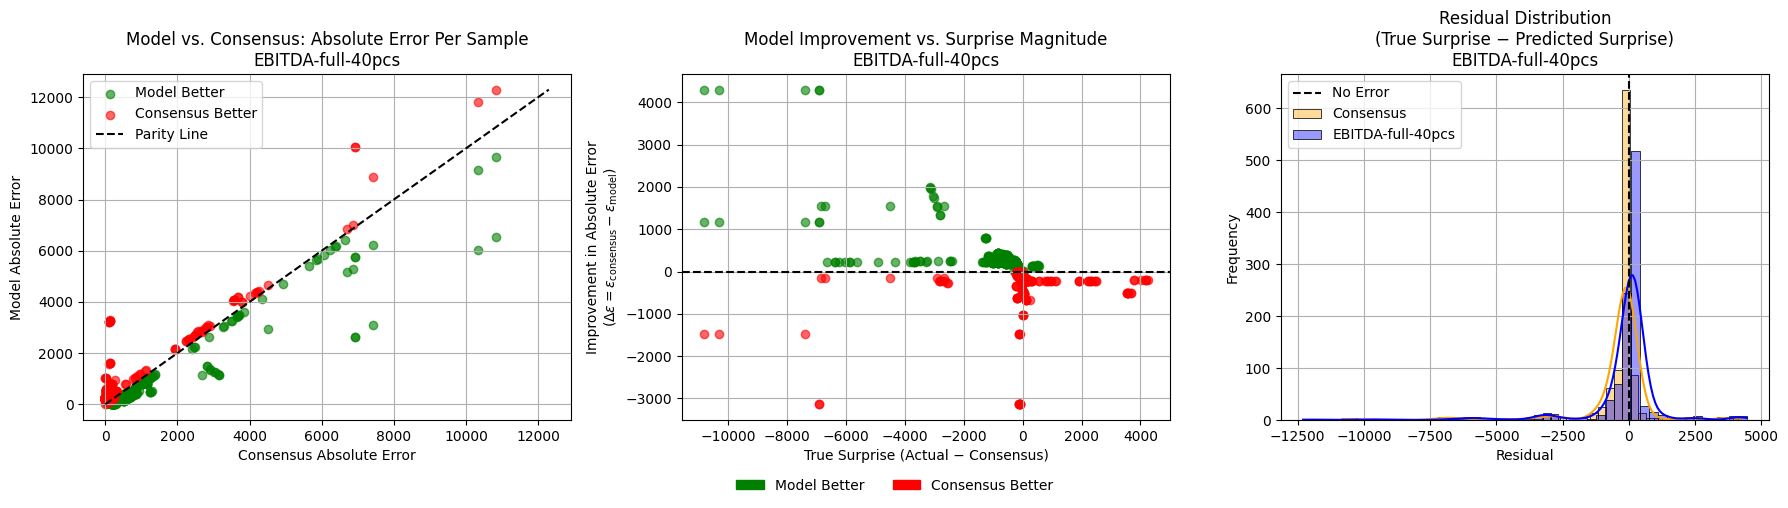


[Comparison Summary: EBITDA-full-40pcs]
Model better in 440 of 1028 samples (42.8%)
Consensus better in 588 of 1028 samples (57.2%)
Tie in 0 of 1028 samples (0.0%)


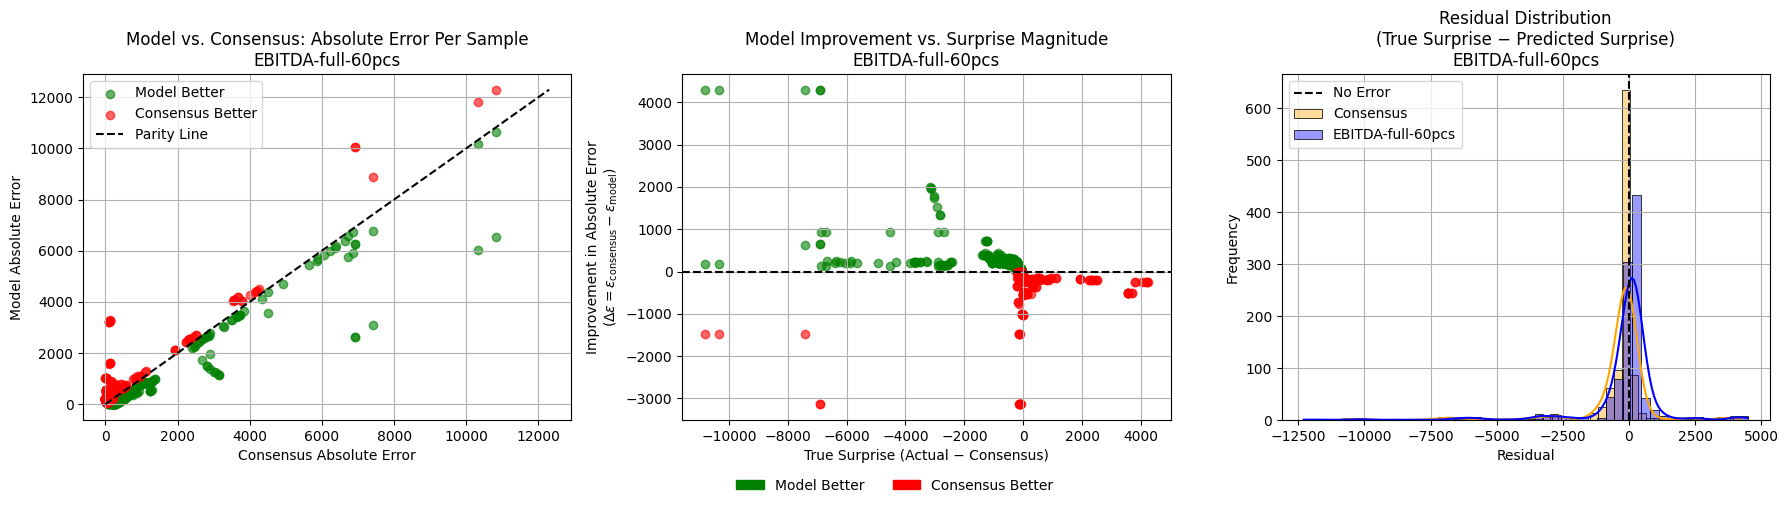


[Comparison Summary: EBITDA-full-60pcs]
Model better in 457 of 1028 samples (44.5%)
Consensus better in 571 of 1028 samples (55.5%)
Tie in 0 of 1028 samples (0.0%)


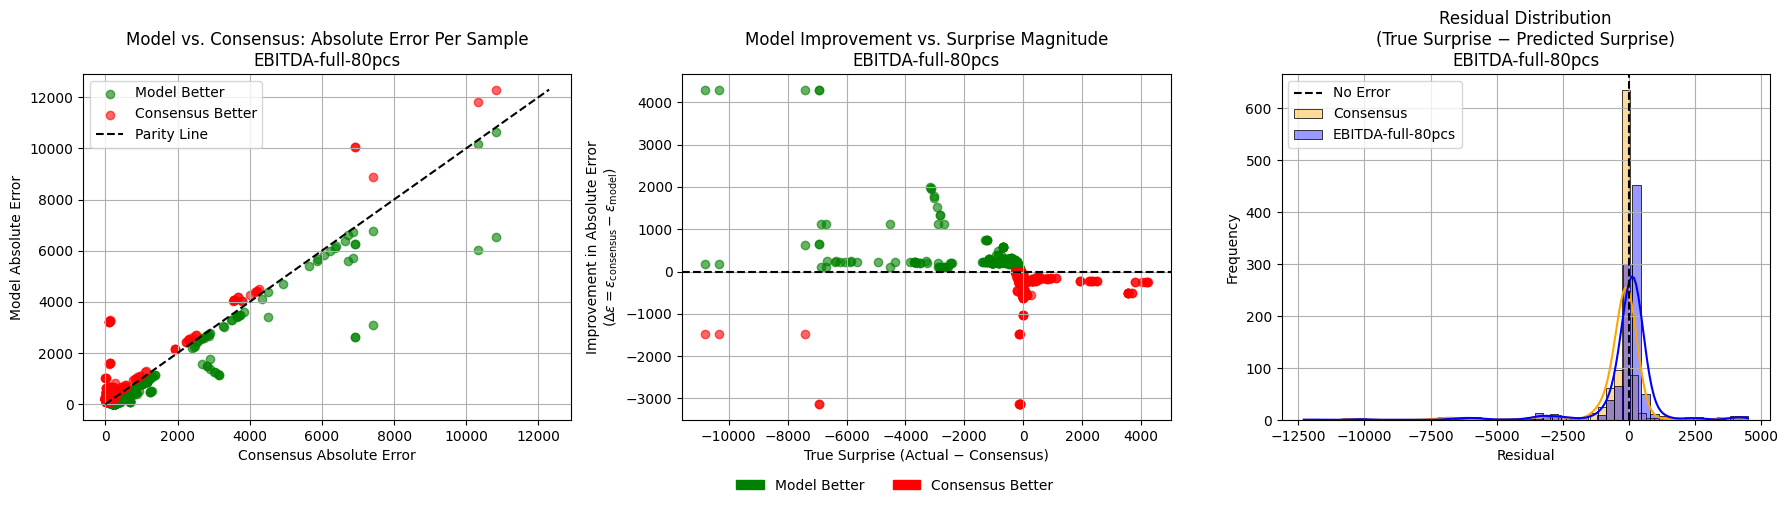


[Comparison Summary: EBITDA-full-80pcs]
Model better in 438 of 1028 samples (42.6%)
Consensus better in 590 of 1028 samples (57.4%)
Tie in 0 of 1028 samples (0.0%)


In [56]:
for pcs in ["40pcs", "60pcs", "80pcs"]:
    model_key = f"{metric}-full-{pcs}"
    plot_model_vs_consensus_triplet_from_dict(
        model_key,
        results_dict=xgb_lang_results,
        actual=actual,
        consensus=consensus,
        include_baseline=False,
        titlesuffix=True
    )

#### Tail Behaviour Analysis

In [57]:
xgb_lang_tail_results = evaluate_tail_behaviour(
    pred_input=xgb_lang_results,
    consensus=consensus,
    actual=actual,
    model_name="XGB_Language_Residual",
    plot=False,
    include_baseline=True,
    log_kde_y='auto' 
)
xgb_lang_tail_results

,Model,Type,MAE,RMSE,95th %ile Abs Error,Mean Abs Error in Tail,MAE on Surprise >±10%,Tail MAE (Positive Surprise),Tail MAE (Negative Surprise)
0,Baseline,baseline,589.21,1526.24,3533.07,5790.40,1076.39,1006.93,3555.31
1,EBITDA-full-40pcs,model,609.98,1464.45,3260.57,5456.13,1004.66,1211.62,3034.81
2,EBITDA-full-60pcs,model,617.70,1484.48,3271.86,5544.79,1006.69,1264.44,3050.11
3,EBITDA-full-80pcs,model,616.32,1482.08,3271.86,5535.00,1013.23,1260.93,3060.09


## LightGBM Training Config

In [58]:
lgbm_lang_results = {"surprise": {}, "actuals": {}, "preds": {}}

y_train = lang_preproc_lgbm["y_train"]
y_val = lang_preproc_lgbm["y_val"]
val_df = lang_preproc_lgbm["val_df"]

consensus = val_df[f"{col_prefix}_estimate"].values
actual = val_df[f"{col_prefix}_actual"].values

# Save baseline
baseline_pred = consensus
y_true = actual
lgbm_lang_results["preds"][f"{metric}-baseline"] = consensus

# save baseline actual-level metrics
mae_b = mean_absolute_error(actual, consensus)
rmse_b = root_mean_squared_error(actual, consensus)
mape_b = np.mean(np.abs((actual - consensus) / np.maximum(np.abs(actual), 1e-12)))
r2_b = r2_score(actual, consensus)

lgbm_lang_results["actuals"][f"{metric}-baseline"] = {
    "MAE": mae_b,
    "RMSE": rmse_b,
    "MAPE": mape_b,
    "R2": r2_b
}

# Define model configs
model_configs = [
    (emb_prefix, n_pcs)
    for emb_prefix in ["full"]
    for n_pcs in [40, 60, 80]
]

for emb_prefix, n_pcs in tqdm(model_configs, desc=f"{metric} Models", leave=True):
    pca_train = lang_preproc_lgbm[f"{emb_prefix}_pca_train"]
    pca_val = lang_preproc_lgbm[f"{emb_prefix}_pca_val"]

    # Generate column names
    txt_cols = [f"txt_{i}" for i in range(lang_preproc_lgbm["txt_train"].shape[1])]
    pca_cols = list(pca_train.columns[:n_pcs])
    cat_cols = [f"cat_{i}" for i in range(lang_preproc_lgbm["cat_train"].shape[1])]
    all_cols = txt_cols + pca_cols + cat_cols

    # Combine into DataFrames
    X_train = pd.DataFrame(
        np.hstack([lang_preproc_lgbm["txt_train"], pca_train.iloc[:, :n_pcs], lang_preproc_lgbm["cat_train"]]),
        columns=all_cols
    )
    X_val = pd.DataFrame(
        np.hstack([lang_preproc_lgbm["txt_val"], pca_val.iloc[:, :n_pcs], lang_preproc_lgbm["cat_val"]]),
        columns=all_cols
    )

    # Model search
    param_grid = {
        "n_estimators": [200, 400],
        "max_depth": [6, 10],
        "learning_rate": [0.001, 0.005],
    }

    tscv = TimeSeriesSplit(n_splits=N_SPLITS, gap=GAP)
    gs = lgbm_run_grid_search(X_train, y_train, param_grid, cv=tscv)
    preds_val = gs.predict(X_val)

    # Surprise metrics
    mae_s, rmse_s, hit_s = evaluate_surprise(y_val, preds_val)

    # Actuals metrics
    pred_actual = consensus + preds_val
    mae_a, rmse_a, mape_a, r2_a = evaluate_actuals_from_residual(actual, consensus, preds_val)

    key = f"{metric}-{emb_prefix}-{n_pcs}pcs"

    # Store predictions and results
    lgbm_lang_results["preds"][key] = pred_actual
    lgbm_lang_results["surprise"][key] = {
        "MAE": mae_s,
        "RMSE": rmse_s,
        "HitRatio": hit_s,
        "BestParams": gs.best_params_,
    }
    lgbm_lang_results["actuals"][key] = {
        "MAE": mae_a,
        "RMSE": rmse_a,
        "MAPE": mape_a,
        "R2": r2_a,
        "BestParams": gs.best_params_,
    }

EBITDA Models: 100%|█████████████████████████████████████████████████████████████████████| 3/3 [02:20<00:00, 46.77s/it]


### Model Evaluation on Validation Set

In [59]:
m2_lgbm_dm_df, m2_lgbm_surprise_df, m2_lgbm_actuals_df = evaluate_gbdt_model_metrics(y_true=y_true, results=lgbm_lang_results, baseline_pred=baseline_pred)

pd.set_option('display.max_colwidth', None)
display(m2_lgbm_dm_df)
display(m2_lgbm_surprise_df)
display(m2_lgbm_actuals_df)

,Model,DM,p,better,Δ_MAE
0,EBITDA-full-60pcs,1.114,0.8673,False,13.0940
1,EBITDA-full-80pcs,2.206,0.9863,False,26.0292
2,EBITDA-full-40pcs,2.937,0.9983,False,32.5712


,MAE,RMSE,HitRatio,BestParams
EBITDA-full-40pcs,621.786061,1486.034042,0.750973,"{'model__learning_rate': 0.005, 'model__max_depth': 6, 'model__n_estimators': 400}"
EBITDA-full-60pcs,602.308852,1481.573819,0.746109,"{'model__learning_rate': 0.005, 'model__max_depth': 6, 'model__n_estimators': 400}"
EBITDA-full-80pcs,615.244116,1475.841609,0.741245,"{'model__learning_rate': 0.005, 'model__max_depth': 6, 'model__n_estimators': 400}"


,MAE,RMSE,MAPE,R2,BestParams
EBITDA-baseline,589.214877,1526.242,0.922764,0.970717,NaN
EBITDA-full-40pcs,621.786061,1486.034042,0.858795,0.972239,"{'model__learning_rate': 0.005, 'model__max_depth': 6, 'model__n_estimators': 400}"
EBITDA-full-60pcs,602.308852,1481.573819,0.800519,0.972406,"{'model__learning_rate': 0.005, 'model__max_depth': 6, 'model__n_estimators': 400}"
EBITDA-full-80pcs,615.244116,1475.841609,0.832831,0.972619,"{'model__learning_rate': 0.005, 'model__max_depth': 6, 'model__n_estimators': 400}"


#### Model vs Consensus Analysis

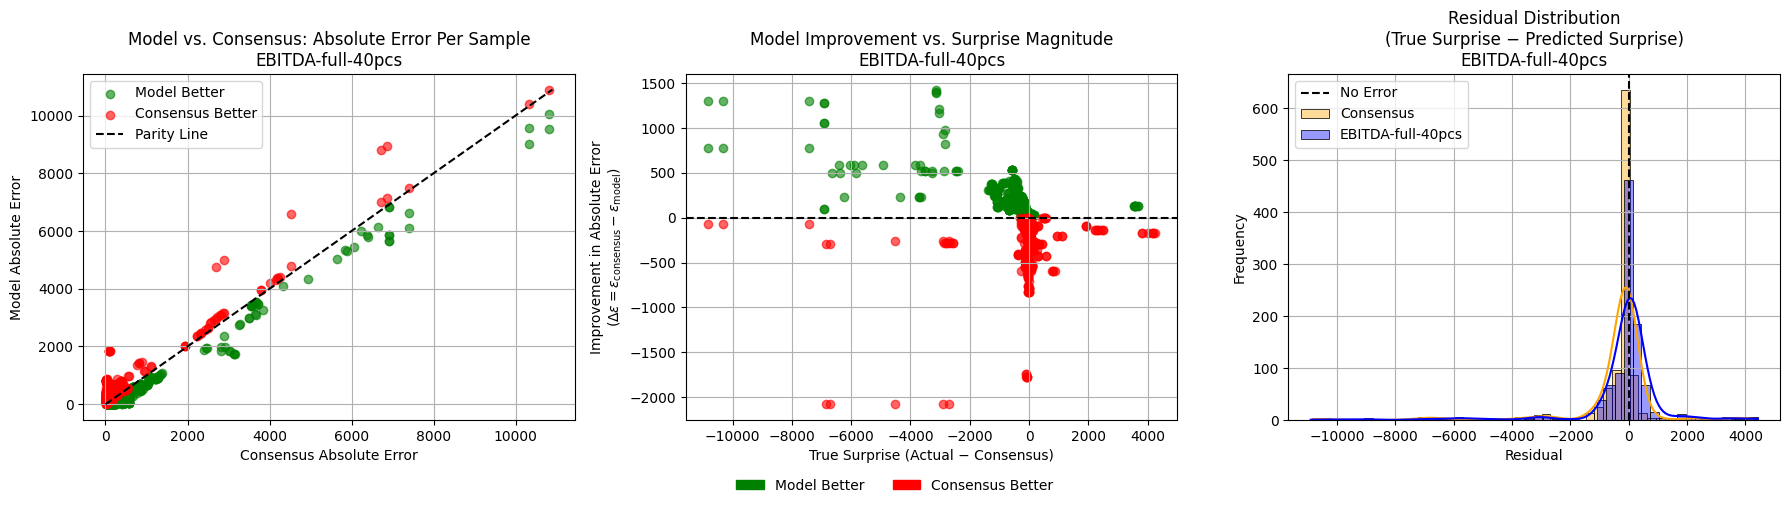


[Comparison Summary: EBITDA-full-40pcs]
Model better in 468 of 1028 samples (45.5%)
Consensus better in 560 of 1028 samples (54.5%)
Tie in 0 of 1028 samples (0.0%)


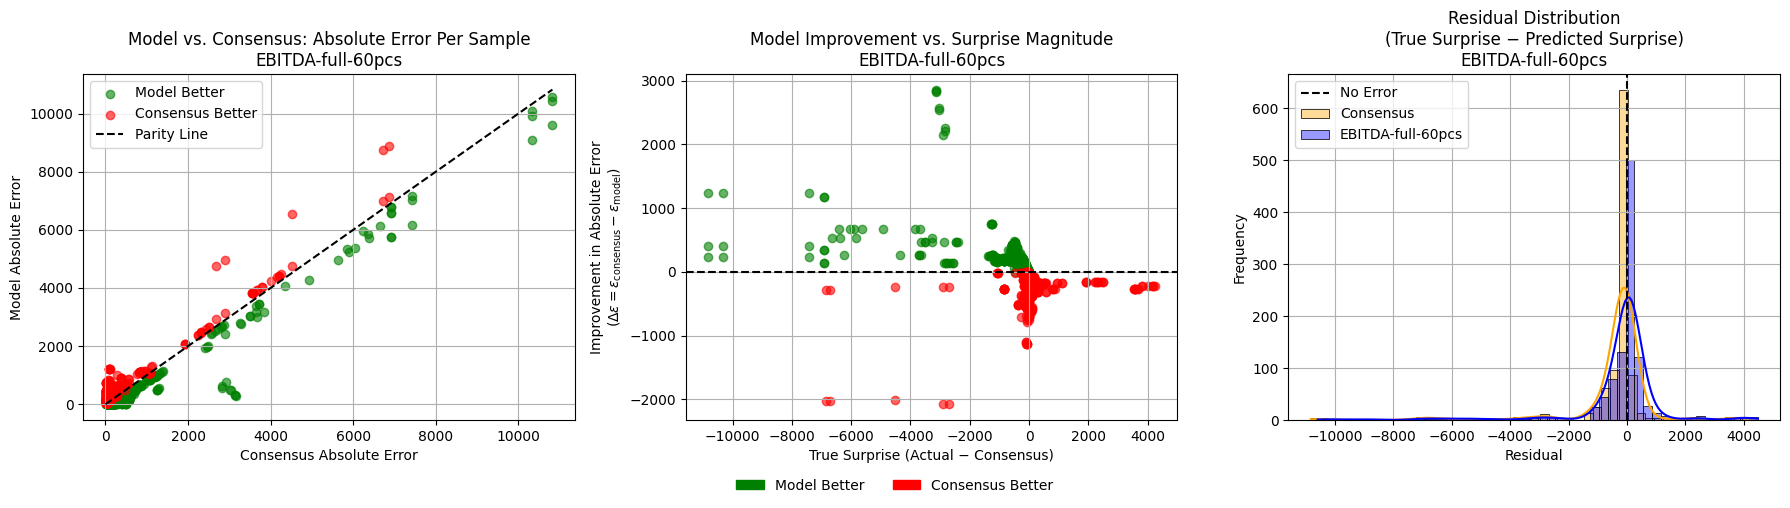


[Comparison Summary: EBITDA-full-60pcs]
Model better in 467 of 1028 samples (45.4%)
Consensus better in 561 of 1028 samples (54.6%)
Tie in 0 of 1028 samples (0.0%)


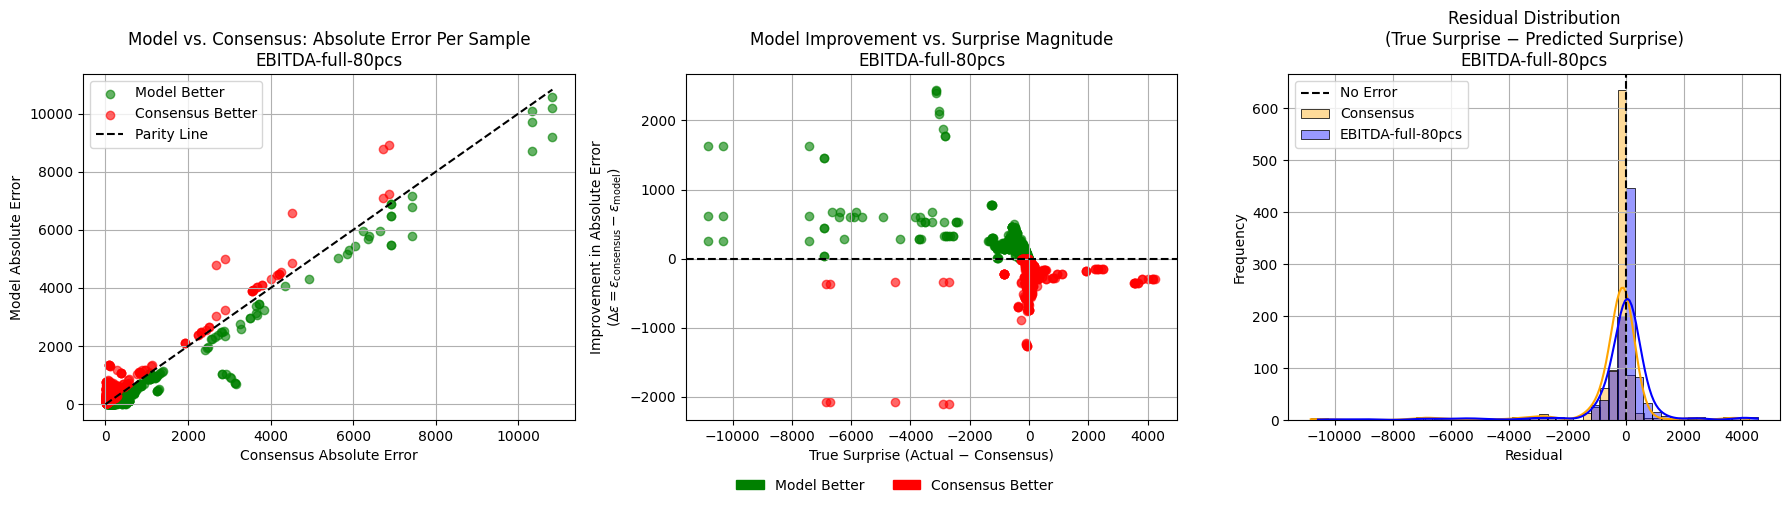


[Comparison Summary: EBITDA-full-80pcs]
Model better in 444 of 1028 samples (43.2%)
Consensus better in 584 of 1028 samples (56.8%)
Tie in 0 of 1028 samples (0.0%)


In [60]:
for pcs in ["40pcs", "60pcs", "80pcs"]:
    model_key = f"{metric}-full-{pcs}"
    plot_model_vs_consensus_triplet_from_dict(
        model_key,
        results_dict=lgbm_lang_results,
        actual=actual,
        consensus=consensus,
        include_baseline=False,
        titlesuffix=True
    )

#### Tail Behaviour Analysis

In [61]:
lgbm_lang_tail_results = evaluate_tail_behaviour(
    pred_input=lgbm_lang_results,
    consensus=consensus,
    actual=actual,
    model_name="LGBM_Language_Residual",
    plot=False,
    include_baseline=True,
    log_kde_y='auto'
)
lgbm_lang_tail_results

,Model,Type,MAE,RMSE,95th %ile Abs Error,Mean Abs Error in Tail,MAE on Surprise >±10%,Tail MAE (Positive Surprise),Tail MAE (Negative Surprise)
0,Baseline,baseline,589.21,1526.24,3533.07,5790.40,1076.39,1006.93,3555.31
1,EBITDA-full-40pcs,model,621.79,1486.03,3217.74,5646.32,983.89,1223.05,3274.17
2,EBITDA-full-60pcs,model,602.31,1481.57,3173.12,5735.46,968.20,1246.18,3162.47
3,EBITDA-full-80pcs,model,615.24,1475.84,3238.06,5717.67,975.50,1263.55,3157.84


## MLP Model

In [62]:
class LangMLP(nn.Module):
    def __init__(self, input_dim: int):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.LayerNorm(64),
            nn.Dropout(0.2),

            nn.Linear(64, 32),
            nn.ReLU(),
            nn.LayerNorm(32),
            nn.Dropout(0.1),

            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.net(x).squeeze(-1)

### Training Loop for each seed

In [63]:
mlp_lang_histories_by_run = {}
mlp_lang_mc_samples_by_run = {}
mlp_lang_preprocessors_by_cfg = {}
mlp_lang_models_by_seed_cfg = {}
mlp_lang_ensemble_meta_params = {}

USE_MLP_BAYESIAN = True
USE_DEEP_ENSEMBLE = True
MC_PASSES = 30
CALIBRATE_INTERVALS = True
TARGET_COVERAGE = 0.90
EVALUATE_MC_PER_SEED = True

SEED = 42
SEEDS = list(range(10)) if USE_DEEP_ENSEMBLE else [SEED]

y_train = train_df["surp_cons_raw"]
y_val = val_df["surp_cons_raw"]
consensus = val_df[f"{col_prefix}_estimate"].values
actual = val_df[f"{col_prefix}_actual"].values
baseline_pred = consensus

emb_subset = [c for c in train_df.columns if c.startswith("embedding_full_")]
all_feats = text_feats + emb_subset + text_cat_cols

preproc = build_preprocessor(
    numeric_cols=text_feats,
    emb_cols=emb_subset,
    cat_cols=text_cat_cols
)

X_train = preproc.fit_transform(train_df[all_feats]).astype(np.float32)
X_val = preproc.transform(val_df[all_feats]).astype(np.float32)

# store fitted preproc to use on final test later
mlp_lang_preprocessors_by_cfg["full"] = preproc

mlp_lang_robust_rows = []

# RUN TRAINING LOOP (per seed)
for seed in SEEDS:
    print(f"\n>>> Training for seed {seed}...")
    set_global_seed(seed)

    train_dataset = MetricDataset(X_train, y_train)
    batch_size = 128
    g = torch.Generator().manual_seed(seed)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, generator=g)

    num_epochs = 100
    total_steps = num_epochs * len(train_loader)

    config = TrainerConfig(
        model_class=LangMLP,
        input_dim=X_train.shape[1],
        num_epochs=num_epochs,
        batch_size=batch_size,
        lr=5e-4,
        weight_decay=1e-6,
        early_stop_patience=15,
        loss_fn=torch.nn.MSELoss(),
        optimizer_fn=lambda p: torch.optim.Adam(p, lr=5e-4, weight_decay=1e-6),
        scheduler_fn=lambda opt: torch.optim.lr_scheduler.OneCycleLR(opt, max_lr=5e-4*10, total_steps=total_steps),
        clip_grad_norm=0.5,
        weight_init_fn=init_weights,
        show_progress=True,
        mc_dropout=USE_MLP_BAYESIAN,
        mc_passes=MC_PASSES,
        evaluate_mc_per_seed=EVALUATE_MC_PER_SEED,
        calibrate_intervals=CALIBRATE_INTERVALS,
        target_coverage=TARGET_COVERAGE,
        deep_ensemble=USE_DEEP_ENSEMBLE
    )

    trainer = MLPTrainer(
        train_loader=train_loader,
        X_train=X_train,
        y_train=y_train,
        X_val=X_val,
        y_val=y_val,
        config=config
    )

    history, best_preds = trainer.train()
    mlp_lang_models_by_seed_cfg[seed] = copy.deepcopy(trainer.model).cpu()
    mlp_lang_histories_by_run[seed] = history

    if config.mc_dropout and config.evaluate_mc_per_seed:
        trainer.validate()
        metrics = trainer.evaluate_mc_sample_metrics(y_true=y_val, consensus=consensus, actual=actual)
        mc_samples = trainer.val_samples
    else:
        preds = best_preds if best_preds is not None else trainer.model(trainer._prepare_tensor(X_val)).cpu().numpy().ravel()
        mc_samples = preds[None, :]
        pred_mean = mc_samples.mean(axis=0)
        pred_actual = consensus + pred_mean
        mae_s, rmse_s, hit_s = evaluate_surprise(y_val, pred_mean)
        mae_a, rmse_a, mape_a, r2_a = evaluate_actuals_from_residual(actual, consensus, pred_mean)
        metrics = {
            "MAE_s": mae_s, "RMSE_s": rmse_s, "HitRatio": hit_s,
            "MAE": mae_a, "RMSE": rmse_a, "MAPE": mape_a, "R2": r2_a,
            "CRPS": None, "Coverage": None, "PredActual": pred_actual
        }

    mlp_lang_mc_samples_by_run[seed] = mc_samples
    mlp_lang_robust_rows.append({
        "Seed": seed,
        "Model": f"{metric}-MLP-Language",
        **metrics
    })


>>> Training for seed 0...


Training MLP:  99%|██████████████████████████████████████████████████████████████████▎| 99/100 [00:33<00:00,  2.94it/s]



>>> Training for seed 1...


Training MLP: 100%|██████████████████████████████████████████████████████████████████| 100/100 [00:26<00:00,  3.78it/s]



>>> Training for seed 2...


Training MLP:  92%|█████████████████████████████████████████████████████████████▋     | 92/100 [00:23<00:02,  3.84it/s]



>>> Training for seed 3...


Training MLP: 100%|██████████████████████████████████████████████████████████████████| 100/100 [00:25<00:00,  3.94it/s]



>>> Training for seed 4...


Training MLP:  94%|██████████████████████████████████████████████████████████████▉    | 94/100 [00:23<00:01,  3.92it/s]



>>> Training for seed 5...


Training MLP: 100%|██████████████████████████████████████████████████████████████████| 100/100 [00:25<00:00,  3.91it/s]



>>> Training for seed 6...


Training MLP: 100%|██████████████████████████████████████████████████████████████████| 100/100 [00:25<00:00,  3.86it/s]



>>> Training for seed 7...


Training MLP: 100%|██████████████████████████████████████████████████████████████████| 100/100 [00:25<00:00,  3.87it/s]



>>> Training for seed 8...


Training MLP: 100%|██████████████████████████████████████████████████████████████████| 100/100 [00:27<00:00,  3.59it/s]



>>> Training for seed 9...


Training MLP: 100%|██████████████████████████████████████████████████████████████████| 100/100 [00:25<00:00,  3.96it/s]


In [64]:
MLP_lang_metrics_df = pd.DataFrame(mlp_lang_robust_rows)

#### MLP Model Evaluation on Validation Set

In [65]:
# Evaluate
m2_mlp_dm_df, m2_mlp_surprise_df, m2_mlp_actuals_df = evaluate_mlp_model_metrics(
    metrics_df=MLP_lang_metrics_df,
    y_true=actual,
    baseline_pred=baseline_pred,
    h=1,
    alpha=0.05,
    alternative="less"
)

display(m2_mlp_dm_df)
display(m2_mlp_surprise_df)
display(m2_mlp_actuals_df)

,Model,Seed,DM,p,better,Δ_MAE
0,EBITDA-MLP-Language,9,-5.984,0.0000,True,-80.5009
1,EBITDA-MLP-Language,3,-5.403,0.0000,True,-74.5488
2,EBITDA-MLP-Language,8,-5.245,0.0000,True,-78.0078
3,EBITDA-MLP-Language,2,-5.041,0.0000,True,-63.5563
4,EBITDA-MLP-Language,7,-4.542,0.0000,True,-64.9040
5,EBITDA-MLP-Language,4,-4.450,0.0000,True,-61.1865
6,EBITDA-MLP-Language,0,-4.334,0.0000,True,-64.2292
7,EBITDA-MLP-Language,1,-4.178,0.0000,True,-59.7142
8,EBITDA-MLP-Language,6,-3.177,0.0007,True,-44.3835
9,EBITDA-MLP-Language,5,-3.061,0.0011,True,-43.2378


MAE       RMSE  HitRatio
Model               Seed                               
EBITDA-MLP-Language 0     524.9857  1340.3642    0.7656
                    1     529.5007  1327.3421    0.7558
                    2     525.6586  1364.7576    0.7695
                    3     514.6660  1315.5097    0.7840
                    4     528.0284  1354.0791    0.7879
                    5     545.9770  1363.6861    0.7831
                    6     544.8314  1355.0006    0.7597
                    7     524.3109  1346.1239    0.7840
                    8     511.2071  1306.7256    0.7996
                    9     508.7139  1279.5511    0.7870

MAE       RMSE    MAPE      R2      CRPS  \
Model               Seed                                                      
EBITDA-baseline     baseline  589.2149  1526.2420  0.9228  0.9707       NaN   
EBITDA-MLP-Language 0         524.9857  1340.3642  0.9337  0.9774  506.6887   
                    1         529.5007  1327.3421  0.8518  0.9779  463.3529   
                    2         525.6586  1364.7576  0.8717  0.9766  456.0636   
                    3         514.6660  1315.5097  0.8746  0.9782  462.7814   
                    4         528.0284  1354.0791  0.8623  0.9770  468.0761   
                    5         545.9770  1363.6861  0.8957  0.9766  489.8749   
                    6         544.8314  1355.0006  0.9012  0.9769  501.6386   
                    7         524.3109  1346.1239  0.9207  0.9772  480.8275   
                    8         511.2071  1306.7256  0.7984  0.9785  452.4859   
                    9         508.7139  1279.5511  0.9029  0.9794  453.7510   

                              Coverage  
Model               Seed                
EBITDA-baseline     baseline       NaN  
EBITDA-MLP-Language 0           0.8891  
                    1           0.8901  
                    2           0.8988  
                    3           0.8881  
                    4           0.8833  
                    5           0.8998  
                    6           0.8911  
                    7           0.8979  
                    8           0.8872  
                    9           0.8833

#### Robustness evaluation

In [66]:
mlp_lang_robustness = evaluate_mlp_seed_robustness(
    metrics_df=MLP_lang_metrics_df,
    y_true=actual,
    baseline_pred=consensus,
    metric_name="MAE",
    alternative="less",
    h = 1,
    dataset_name="EBITDA: MLP-Language-Residual",
    show_plot = False
)

=== Final summary for EBITDA: MLP-Language-Residual ===


,Model,SummaryType,MAE_mean_std,MAE_ci95,RMSE_mean,Hit_mean,R2_mean,CRPS_mean,Coverage_mean,DM_mean,DM_std,% of seeds beating baseline
0,EBITDA-MLP-Language,Mean across seeds,525.8 ± 12.6,7.3851,1335.314,0.7776,0.9776,473.5541,0.8909,-4.5415,0.9311,100.0


### Deep Ensemble Experimentation

In [67]:
# Deep-ensemble loop using only p_hat downstream
mlp_lang_ensemble_rows = []

if USE_DEEP_ENSEMBLE:
    # Gather MC residual samples from all seeds
    all_samples = [v for v in mlp_lang_mc_samples_by_run.values()] # each (mc_passes, N)
    if not all_samples:
        raise ValueError("No MC samples found in mlp_lang_mc_samples_by_run")
    samples = np.concatenate(all_samples, axis=0)  # (mc_passes*seeds, N)

    # Ensemble stats on residuals
    emean, sigma, iqr, snr, err_cons, p_win = compute_ensemble_stats(samples, consensus, actual)

    # Pure-ensemble point prediction (consensus + mean residual)
    y_ensem = consensus + emean

    # CRPS & coverage for the pure-ensemble (on residual samples)
    crps = calc_crps(y_val, samples, axis=0).mean()
    lower, upper = np.percentile(samples, [5, 95], axis=0)
    coverage = ((y_val >= lower) & (y_val <= upper)).mean()

    # Report pure-ensemble metrics
    mae_s_e, rmse_s_e, hit_s_e = evaluate_surprise(y_val, emean)
    mae_a_e, rmse_a_e, mape_a_e, r2_a_e = evaluate_actuals_from_residual(actual, consensus, emean)

    mlp_lang_ensemble_rows.append({
        "Seed": "Ensemble",
        "Model": f"{metric}-MLP-Lang (PureEnsemble)",
        "MAE_s": mae_s_e, "RMSE_s": rmse_s_e, "HitRatio": hit_s_e,
        "MAE": mae_a_e, "RMSE": rmse_a_e, "MAPE": mape_a_e, "R2": r2_a_e,
        "CRPS": crps, "Coverage": coverage, "PredActual": y_ensem
    })

    # OOF adaptive blend (returns OOF point preds)
    c2_grid = [0.0, 0.25, 0.5, 0.75, 1.0]
    alpha_grid = [-8, -6, -4, -2, 0, 2, 4, 6, 8]
    beta_grid = [-4, -3, -2, -1, 0, 1, 2, 3, 4]
    n_splits = 4

    oof_mae = oof_adaptive_mae(
        snr, iqr, sigma, p_win,
        emean, consensus, actual, err_cons,
        c2_grid, alpha_grid, beta_grid,
        n_splits=n_splits
    )

    # Fallback to consensus where OOF is NaN, then evaluate on the full series
    y_pred_full = np.where(np.isnan(oof_mae), consensus, oof_mae)
    resid_full  = y_pred_full - consensus
    
    # Surprise metrics (true residual vs predicted residual)
    mae_s, rmse_s, hit_s = evaluate_surprise(actual - consensus, resid_full)
    
    # Actual metrics from residuals (full series)
    mae_a_full, rmse_a_full, mape_a_full, r2_a_full = evaluate_actuals_from_residual(actual, consensus, resid_full)
    
    mlp_lang_ensemble_rows.append({
        "Seed": "Ensemble",
        "Model": f"{metric}-MLP-Lang (AdaptiveBlend-MAE)",
        "MAE_s": mae_s, "RMSE_s": rmse_s, "HitRatio": hit_s,
        "MAE": mae_a_full, "RMSE": rmse_a_full, "MAPE": mape_a_full, "R2": r2_a_full,
        "CRPS": None,
        "Coverage": None, 
        "PredActual": y_pred_full
    })

    # Final refit of meta-params on ALL points (for future test-time use)
    full_idx = np.arange(len(actual))
    c2_full, iso_full, thr_full, p_hat_full = _refit_iso_on_train(full_idx, snr, iqr, sigma, p_win, c2_grid, consensus, actual, err_cons, emean)
    a_full, b_full = _refit_adaptive_on_train(full_idx, p_hat_full, emean, consensus, actual, err_cons, alpha_grid, beta_grid, optimize="mae")

    # Store under a single key since you have one config
    mlp_lang_ensemble_meta_params["full"] = {
        "driver": "isotonic_composite",
        "c2": float(c2_full),
        "iso_x": iso_full.X_thresholds_.tolist(),
        "iso_y": iso_full.y_thresholds_.tolist(),
        "thr": float(thr_full),
        "adaptive": "sigmoid-mae",
        "alpha_mae": float(a_full),
        "beta_mae": float(b_full),
        "mc_passes": int(MC_PASSES),
        "deep_ensemble": True,
    }

Adaptive-blend-MAE per-fold (MAE, Hit): [(766.6457449608657, 0.7073170731707317), (586.3484590504245, 0.6439024390243903), (357.2918602370433, 0.697560975609756), (358.71134192300116, 0.5170731707317073)]


In [68]:
MLP_ensemble_lang_metrics_df = pd.DataFrame(mlp_lang_ensemble_rows)

#### Ensemble Model Evaluation on Validation Set

In [69]:
# Evaluate
m2_mlp_ensemble_dm_df, m2_mlp_ensemble_surprise_df, m2_mlp_ensemble_actuals_df = evaluate_mlp_model_metrics(
    metrics_df=MLP_ensemble_lang_metrics_df,
    y_true=actual,
    baseline_pred=baseline_pred,
    h=1,
    alpha=0.05,
    alternative="less"
)

display(m2_mlp_ensemble_dm_df)
display(m2_mlp_ensemble_surprise_df)
display(m2_mlp_ensemble_actuals_df)

,Model,Seed,DM,p,better,Δ_MAE
0,EBITDA-MLP-Lang (AdaptiveBlend-MAE),Ensemble,-6.556,0.0,True,-70.7952
1,EBITDA-MLP-Lang (PureEnsemble),Ensemble,-5.375,0.0,True,-73.6236


,,MAE,RMSE,HitRatio
Model,Seed,,,
EBITDA-MLP-Lang (PureEnsemble),Ensemble,515.5913,1328.9835,0.8054
EBITDA-MLP-Lang (AdaptiveBlend-MAE),Ensemble,518.4196,1368.8896,0.6595


,,MAE,RMSE,MAPE,R2,CRPS,Coverage
Model,Seed,,,,,,
EBITDA-baseline,baseline,589.2149,1526.2420,0.9228,0.9707,NaN,NaN
EBITDA-MLP-Lang (PureEnsemble),Ensemble,515.5913,1328.9835,0.8522,0.9778,450.4967,0.9066
EBITDA-MLP-Lang (AdaptiveBlend-MAE),Ensemble,518.4196,1368.8896,0.8222,0.9764,NaN,NaN


#### Robustness evaluation

In [70]:
MLP_lang_models_robustness_df = pd.DataFrame(mlp_lang_robust_rows + mlp_lang_ensemble_rows)

In [71]:
mlp_ensemble_lang_robustness = evaluate_mlp_seed_robustness(
    metrics_df=MLP_lang_models_robustness_df,
    y_true=actual,
    baseline_pred=consensus,
    metric_name="MAE",
    alternative="less",
    h = 1,
    dataset_name="EBITDA: MLP-Lang-Residual",
    show_plot = False
)

=== Final summary for EBITDA: MLP-Lang-Residual ===


,Model,SummaryType,MAE_mean_std,MAE_ci95,RMSE_mean,Hit_mean,R2_mean,CRPS_mean,Coverage_mean,DM_mean,DM_std,% of seeds beating baseline
0,EBITDA-MLP-Language,Mean across seeds,525.8 ± 12.6,7.3851,1335.314000,0.777600,0.977600,473.554100,0.890900,-4.5415,0.9311,100.0
1,EBITDA-MLP-Lang (PureEnsemble),Ensemble,515.6,NaN,1328.983530,0.805447,0.977797,450.496741,0.906615,NaN,NaN,NaN
2,EBITDA-MLP-Lang (AdaptiveBlend-MAE),Ensemble,518.4,NaN,1368.889566,0.659533,0.976444,NaN,NaN,NaN,NaN,NaN


#### Model vs Consensus Analysis

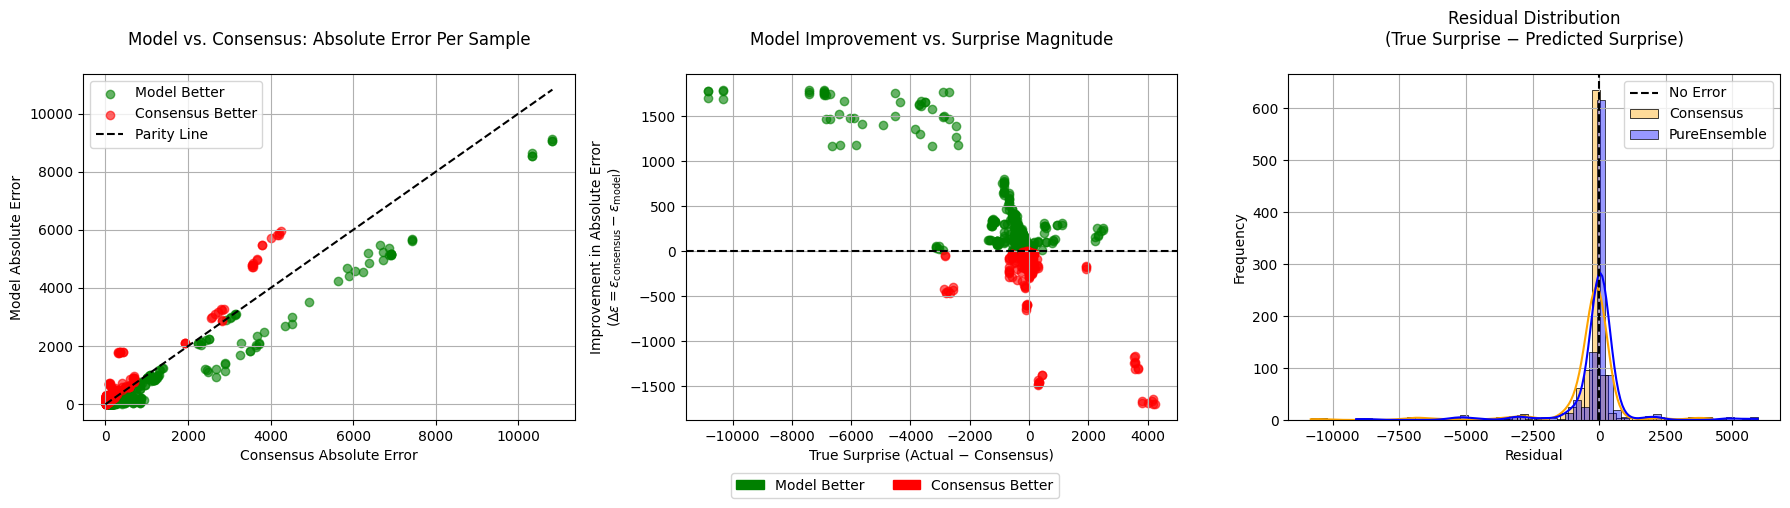


[Comparison Summary: PureEnsemble]
Model better in 623 of 1028 samples (60.6%)
Consensus better in 405 of 1028 samples (39.4%)
Tie in 0 of 1028 samples (0.0%)


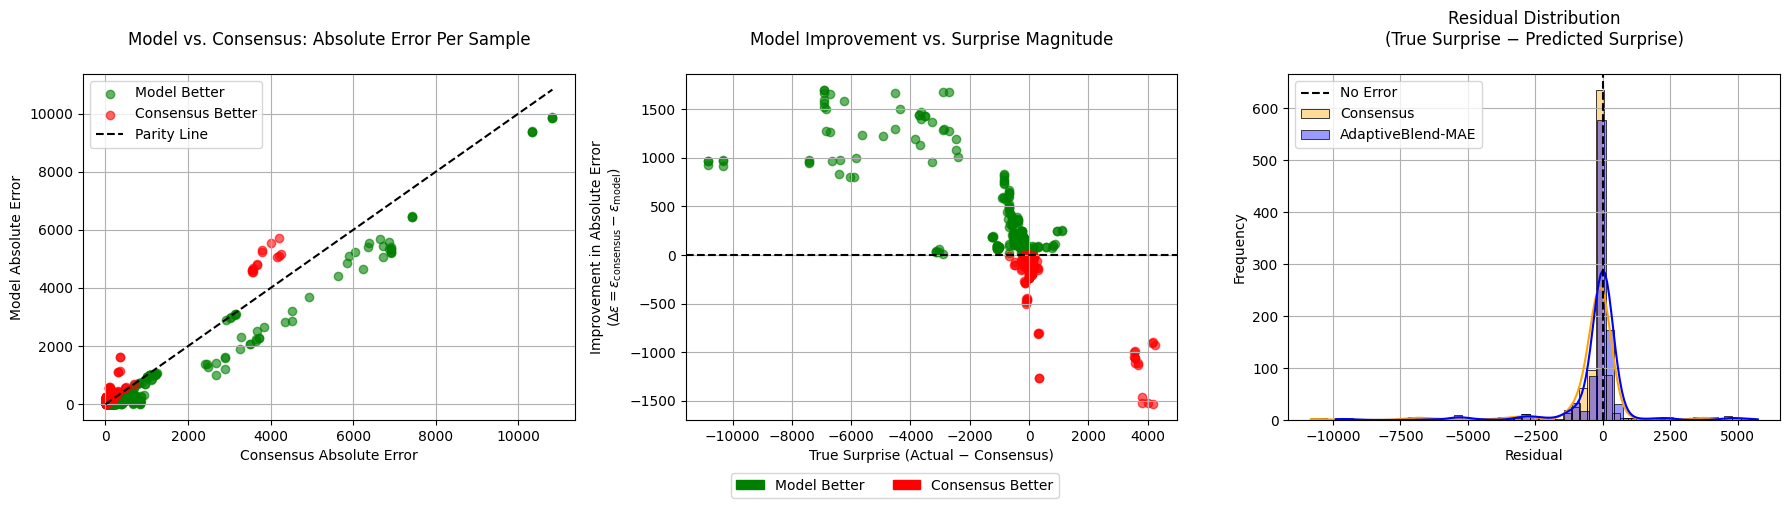


[Comparison Summary: AdaptiveBlend-MAE]
Model better in 526 of 1028 samples (51.2%)
Consensus better in 294 of 1028 samples (28.6%)
Tie in 208 of 1028 samples (20.2%)


In [72]:
for model in ["PureEnsemble", "AdaptiveBlend-MAE"]:
    plot_model_vs_consensus_triplet(model, actual, consensus, df=MLP_lang_models_robustness_df, titlesuffix=False)

#### Tail Behaviour Analysis

In [73]:
mlp_ensemble_lang_metrics_single_model = MLP_lang_models_robustness_df[MLP_lang_models_robustness_df['Model']=='EBITDA-MLP-Lang (PureEnsemble)'].copy()

In [74]:
mlp_ensemble_lang_tail_results = evaluate_tail_behaviour(
    pred_input=mlp_ensemble_lang_metrics_single_model,
    consensus=consensus,
    actual=actual,
    model_name="EBITDA-MLP-Lang (PureEnsemble)",
    plot=False,
    include_baseline=True,
    log_kde_y='auto'
)
mlp_ensemble_lang_tail_results

,Model,Type,MAE,RMSE,95th %ile Abs Error,Mean Abs Error in Tail,MAE on Surprise >±10%,Tail MAE (Positive Surprise),Tail MAE (Negative Surprise)
0,Baseline,baseline,589.21,1526.24,3533.07,5790.40,1076.39,1006.93,3555.31
1,EBITDA-MLP-Lang (PureEnsemble),model,515.59,1328.98,3014.15,5197.05,907.39,1317.66,2750.47


## Final Language Residual Model Choice

* PureEnsemble
* AdaptiveBlend-MAE

# Analyst Residual Training

## XGBoost Training Config

In [75]:
xgb_analyst_results = {"surprise": {}, "actuals": {}, "preds": {}}

# Use the preprocessed data for the selected metric
y_train = analyst_preproc_xgb["y_train"]
y_val = analyst_preproc_xgb["y_val"]
val_df = analyst_preproc_xgb["val_df"]

consensus = val_df[f"{col_prefix}_estimate"].values
actual = val_df[f"{col_prefix}_actual"].values
y_true = actual

# Baseline: assume zero surprise → prediction = consensus
baseline_pred = consensus
xgb_analyst_results["preds"][f"{metric}-baseline"] = consensus

# save baseline actual-level metrics
mae_b = mean_absolute_error(actual, consensus)
rmse_b = root_mean_squared_error(actual, consensus)
mape_b = np.mean(np.abs((actual - consensus) / np.maximum(np.abs(actual), 1e-12)))
r2_b = r2_score(actual, consensus)

xgb_analyst_results["actuals"][f"{metric}-baseline"] = {
    "MAE": mae_b,
    "RMSE": rmse_b,
    "MAPE": mape_b,
    "R2": r2_b
}

analyst_train_cp = cp.asarray(analyst_preproc_xgb["analyst_train"])
cat_train_cp = cp.asarray(analyst_preproc_xgb["cat_train"])

X_train_cp = cp.hstack([analyst_train_cp, cat_train_cp])

analyst_val_cp = cp.asarray(analyst_preproc_xgb["analyst_val"])
cat_val_cp = cp.asarray(analyst_preproc_xgb["cat_val"])

X_val_cp = cp.hstack([analyst_val_cp, cat_val_cp])

param_grid = {
    "n_estimators": [300],
    "max_depth": [8, 10, 12],
    "learning_rate": [0.001, 0.005],
}

tscv = TimeSeriesSplit(n_splits=N_SPLITS, gap=GAP)
gs = xgb_run_grid_search(X_train_cp, y_train, param_grid, cv=tscv)
preds_val = gs.predict(X_val_cp)

# Surprise-level metrics
mae_s, rmse_s, hit_s = evaluate_surprise(y_val, preds_val)

# Actual-level metrics
pred_actual = consensus + preds_val
mae_a, rmse_a, mape_a, r2_a = evaluate_actuals_from_residual(actual, consensus, preds_val)

key = f"{metric}-analyst-xgb"

# Store predictions and results
xgb_analyst_results["preds"][key] = pred_actual
xgb_analyst_results["surprise"][key] = {
    "MAE": mae_s,
    "RMSE": rmse_s,
    "HitRatio": hit_s,
    "BestParams": gs.best_params_,
}
xgb_analyst_results["actuals"][key] = {
    "MAE": mae_a,
    "RMSE": rmse_a,
    "MAPE": mape_a,
    "R2": r2_a,
    "BestParams": gs.best_params_,
}

### Model Evaluation on Validation Set

In [76]:
m3_xgb_dm_df, m3_xgb_surprise_df, m3_xgb_actuals_df = evaluate_gbdt_model_metrics(y_true=y_true, results=xgb_analyst_results, baseline_pred=baseline_pred)

pd.set_option('display.max_colwidth', None)
display(m3_xgb_dm_df)
display(m3_xgb_surprise_df)
display(m3_xgb_actuals_df)

,Model,DM,p,better,Δ_MAE
0,EBITDA-analyst-xgb,-3.931,0.0,True,-92.3742


,MAE,RMSE,HitRatio,BestParams
EBITDA-analyst-xgb,496.840693,1032.391455,0.814202,"{'model__learning_rate': 0.001, 'model__max_depth': 12, 'model__n_estimators': 300}"


,MAE,RMSE,MAPE,R2,BestParams
EBITDA-analyst-xgb,496.840693,1032.391455,0.868639,0.986601,"{'model__learning_rate': 0.001, 'model__max_depth': 12, 'model__n_estimators': 300}"
EBITDA-baseline,589.214877,1526.242,0.922764,0.970717,NaN


#### Model vs Consensus Analysis

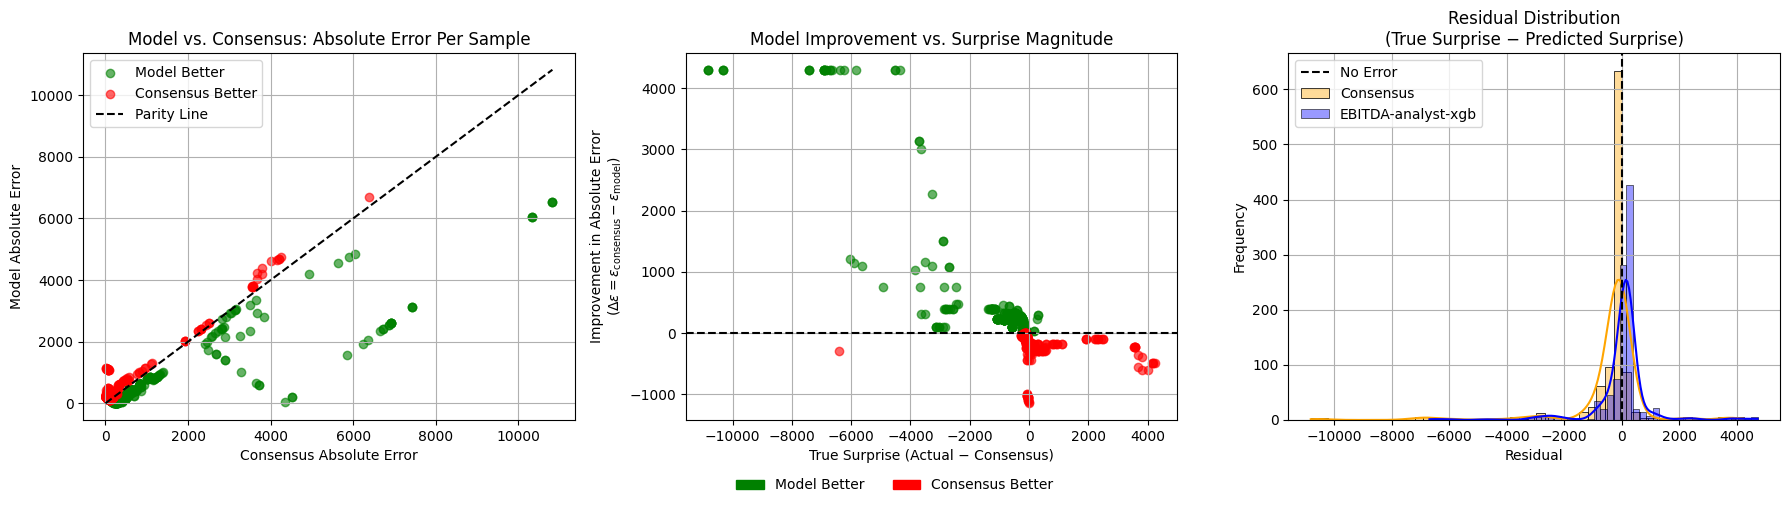


[Comparison Summary: EBITDA-analyst-xgb]
Model better in 421 of 1028 samples (41.0%)
Consensus better in 607 of 1028 samples (59.0%)
Tie in 0 of 1028 samples (0.0%)


In [77]:
plot_model_vs_consensus_triplet_from_dict(
    model_pattern="analyst-xgb",
    results_dict=xgb_analyst_results,
    actual=actual,
    consensus=consensus,
    include_baseline=False,
    titlesuffix=False
)

#### Tail Behaviour Analysis

In [78]:
xgb_analyst_tail_results = evaluate_tail_behaviour(
    pred_input=xgb_analyst_results,
    consensus=consensus,
    actual=actual,
    model_name="XGB_Analyst_Residual",
    plot=False,
    include_baseline=True,
    log_kde_y='auto'
)
xgb_analyst_tail_results

,Model,Type,MAE,RMSE,95th %ile Abs Error,Mean Abs Error in Tail,MAE on Surprise >±10%,Tail MAE (Positive Surprise),Tail MAE (Negative Surprise)
0,Baseline,baseline,589.21,1526.24,3533.07,5790.40,1076.39,1006.93,3555.31
1,EBITDA-analyst-xgb,model,496.84,1032.39,2458.92,3821.94,771.04,1218.84,2044.54


## LightGBM Training Config

In [79]:
lgbm_analyst_results = {"surprise": {}, "actuals": {}, "preds": {}}

y_train = analyst_preproc_lgbm["y_train"]
y_val = analyst_preproc_lgbm["y_val"]
val_df = analyst_preproc_lgbm["val_df"]

consensus = val_df[f"{col_prefix}_estimate"].values
actual = val_df[f"{col_prefix}_actual"].values

# Save baseline
baseline_pred = consensus
y_true = actual
lgbm_analyst_results["preds"][f"{metric}-baseline"] = consensus

# save baseline actual-level metrics
mae_b = mean_absolute_error(actual, consensus)
rmse_b = root_mean_squared_error(actual, consensus)
mape_b = np.mean(np.abs((actual - consensus) / np.maximum(np.abs(actual), 1e-12)))
r2_b = r2_score(actual, consensus)

lgbm_analyst_results["actuals"][f"{metric}-baseline"] = {
    "MAE": mae_b,
    "RMSE": rmse_b,
    "MAPE": mape_b,
    "R2": r2_b
}

analyst_cols = [f"analyst_{i}" for i in range(analyst_preproc_lgbm["analyst_train"].shape[1])]
cat_cols = [f"cat_{i}" for i in range(analyst_preproc_lgbm["cat_train"].shape[1])]
all_cols = analyst_cols + cat_cols

X_train = pd.DataFrame(
    np.hstack([analyst_preproc_lgbm["analyst_train"], analyst_preproc_lgbm["cat_train"]]),
    columns=all_cols
)
X_val = pd.DataFrame(
    np.hstack([analyst_preproc_lgbm["analyst_val"], analyst_preproc_lgbm["cat_val"]]),
    columns=all_cols
)

param_grid = {
        "n_estimators": [100, 200],
        "max_depth": [6, 8, 10],
        "learning_rate": [0.001, 0.005, 0.0001],
    }

tscv = TimeSeriesSplit(n_splits=N_SPLITS, gap=GAP)
gs = lgbm_run_grid_search(X_train, y_train, param_grid, cv=tscv)
preds_val = gs.predict(X_val)

# Surprise metrics
mae_s, rmse_s, hit_s = evaluate_surprise(y_val, preds_val)

# Actuals metrics
pred_actual = consensus + preds_val
mae_a, rmse_a, mape_a, r2_a = evaluate_actuals_from_residual(actual, consensus, preds_val)

key = f"{metric}-analyst-lgbm"

# Store predictions and results
lgbm_analyst_results["preds"][key] = pred_actual
lgbm_analyst_results["surprise"][key] = {
    "MAE": mae_s,
    "RMSE": rmse_s,
    "HitRatio": hit_s,
    "BestParams": gs.best_params_,
}
lgbm_analyst_results["actuals"][key] = {
    "MAE": mae_a,
    "RMSE": rmse_a,
    "MAPE": mape_a,
    "R2": r2_a,
    "BestParams": gs.best_params_,
}

### Model Evaluation on Validation Set

In [80]:
m3_lgbm_dm_df, m3_lgbm_surprise_df, m3_lgbm_actuals_df = evaluate_gbdt_model_metrics(y_true=y_true, results=lgbm_analyst_results, baseline_pred=baseline_pred)

pd.set_option('display.max_colwidth', None)
display(m3_lgbm_dm_df)
display(m3_lgbm_surprise_df)
display(m3_lgbm_actuals_df)

,Model,DM,p,better,Δ_MAE
0,EBITDA-analyst-lgbm,4.651,1.0,False,33.1007


,MAE,RMSE,HitRatio,BestParams
EBITDA-analyst-lgbm,622.31562,1470.238809,0.810311,"{'model__learning_rate': 0.0001, 'model__max_depth': 10, 'model__n_estimators': 100}"


,MAE,RMSE,MAPE,R2,BestParams
EBITDA-analyst-lgbm,622.31562,1470.238809,0.895906,0.972826,"{'model__learning_rate': 0.0001, 'model__max_depth': 10, 'model__n_estimators': 100}"
EBITDA-baseline,589.214877,1526.242,0.922764,0.970717,NaN


#### Model vs Consensus Analysis

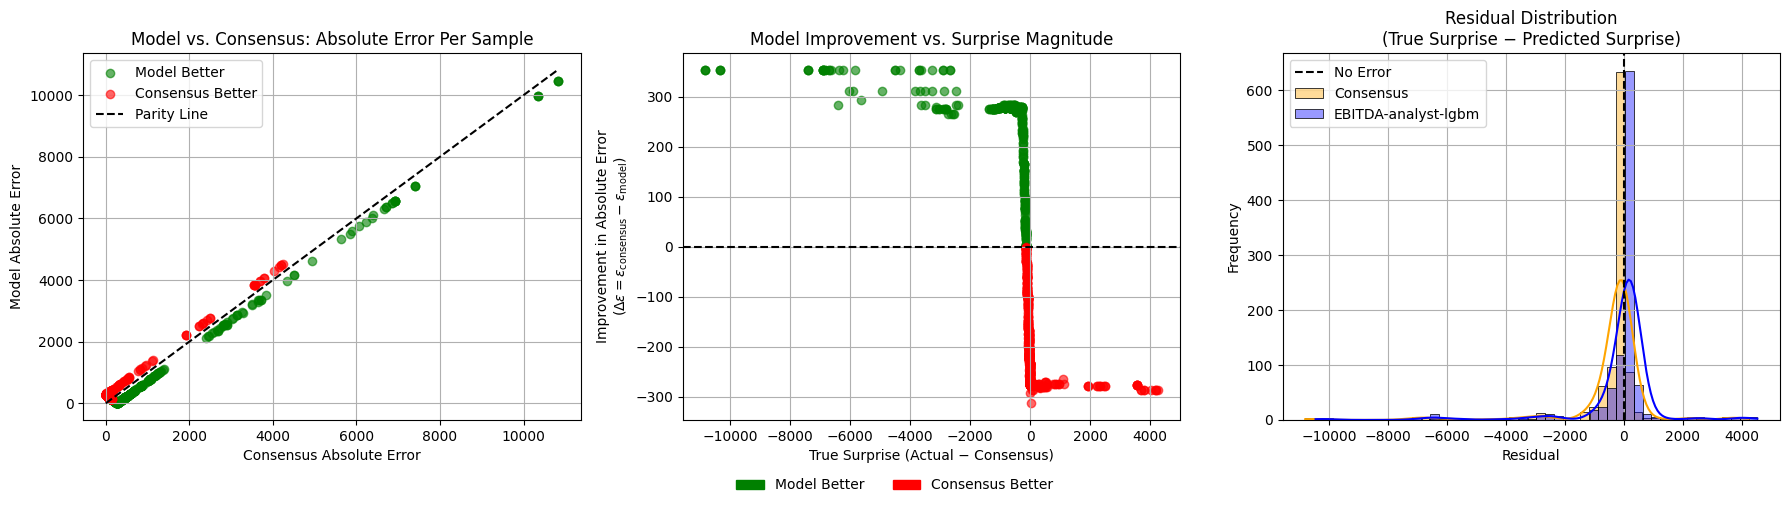


[Comparison Summary: EBITDA-analyst-lgbm]
Model better in 412 of 1028 samples (40.1%)
Consensus better in 616 of 1028 samples (59.9%)
Tie in 0 of 1028 samples (0.0%)


In [81]:
plot_model_vs_consensus_triplet_from_dict(
    model_pattern="analyst-lgbm",
    results_dict=lgbm_analyst_results,
    actual=actual,
    consensus=consensus,
    include_baseline=False,
    titlesuffix=False
)

#### Tail Behaviour Analysis

In [82]:
lgbm_analyst_tail_results = evaluate_tail_behaviour(
    pred_input=lgbm_analyst_results,
    consensus=consensus,
    actual=actual,
    model_name="LGBM_Analyst_Residual",
    plot=False,
    include_baseline=True,
    log_kde_y='auto'
)
lgbm_analyst_tail_results

,Model,Type,MAE,RMSE,95th %ile Abs Error,Mean Abs Error in Tail,MAE on Surprise >±10%,Tail MAE (Positive Surprise),Tail MAE (Negative Surprise)
0,Baseline,baseline,589.21,1526.24,3533.07,5790.40,1076.39,1006.93,3555.31
1,EBITDA-analyst-lgbm,model,622.32,1470.24,3267.06,5628.02,995.16,1284.30,3250.45


## MLP Training Config

In [83]:
class AnalystMLP(nn.Module):
    def __init__(self, input_dim: int):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.LayerNorm(64),
            nn.Dropout(0.3),

            nn.Linear(64, 32),
            nn.ReLU(),
            nn.LayerNorm(32),
            nn.Dropout(0.2),

            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.net(x).squeeze(-1)

### Training Loop for each seed

In [84]:
mlp_analyst_histories_by_run = {}
mlp_analyst_mc_samples_by_run = {}

mlp_analyst_preprocessors_by_cfg = {}
mlp_analyst_models_by_seed_cfg = {}
mlp_analyst_ensemble_meta_params = {}

USE_MLP_BAYESIAN = True
USE_DEEP_ENSEMBLE = True
MC_PASSES = 30
CALIBRATE_INTERVALS = True
TARGET_COVERAGE = 0.90
EVALUATE_MC_PER_SEED = True

SEED = 42
SEEDS = list(range(10)) if USE_DEEP_ENSEMBLE else [SEED] 

y_train = train_df["surp_cons_raw"]
y_val = val_df["surp_cons_raw"]
consensus = val_df[f"{col_prefix}_estimate"].values
actual = val_df[f"{col_prefix}_actual"].values
baseline_pred = consensus

mlp_analyst_robust_rows = []

# RUN TRAINING LOOP (per seed)
for seed in SEEDS:
    print(f"\n>>> Training for seed {seed}...")

    set_global_seed(seed)

    all_feats = analyst_feats + analyst_cat_cols

    preproc = build_preprocessor(
        numeric_cols=analyst_feats,
        emb_cols=[],
        cat_cols=analyst_cat_cols
    )
    
    mlp_analyst_preprocessors_by_cfg[seed] = preproc

    X_train = preproc.fit_transform(train_df[all_feats])
    X_val = preproc.transform(val_df[all_feats])

    train_dataset = MetricDataset(X_train, y_train)
    batch_size = 64
    g = torch.Generator().manual_seed(seed)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, generator=g)

    num_epochs = 150
    total_steps = num_epochs * len(train_loader)

    config = TrainerConfig(
        model_class=AnalystMLP,
        input_dim=X_train.shape[1],
        num_epochs=num_epochs,
        batch_size=batch_size,
        lr=5e-4,
        weight_decay=1e-3,
        early_stop_patience=25,
        loss_fn=torch.nn.MSELoss(),
        optimizer_fn=lambda p: torch.optim.Adam(p, lr=5e-4, weight_decay=1e-3),
        scheduler_fn=lambda opt: torch.optim.lr_scheduler.OneCycleLR(opt, max_lr=5e-4 * 4, total_steps=total_steps, pct_start=0.1, anneal_strategy="cos"),
        clip_grad_norm=0.5,
        weight_init_fn=init_weights,
        show_progress=True,
        mc_dropout=USE_MLP_BAYESIAN,
        mc_passes=MC_PASSES,
        evaluate_mc_per_seed=EVALUATE_MC_PER_SEED,
        calibrate_intervals=CALIBRATE_INTERVALS,
        target_coverage=TARGET_COVERAGE,
        deep_ensemble=USE_DEEP_ENSEMBLE
    )

    trainer = MLPTrainer(
        train_loader=train_loader,
        X_train=X_train,
        y_train=y_train,
        X_val=X_val,
        y_val=y_val,
        config=config
    )

    history, best_preds = trainer.train()
    mlp_analyst_models_by_seed_cfg[seed] = copy.deepcopy(trainer.model).cpu()
    mlp_analyst_histories_by_run[seed] = history

    if config.mc_dropout and config.evaluate_mc_per_seed:
        trainer.validate()
        metrics = trainer.evaluate_mc_sample_metrics(
            y_true=y_val,
            consensus=consensus,
            actual=actual
        )
        mc_samples = trainer.val_samples
    else:
        preds = best_preds if best_preds is not None else trainer.model(trainer._prepare_tensor(X_val)).cpu().numpy().ravel()
        mc_samples = preds[None, :]
        pred_mean = mc_samples.mean(axis=0)
        pred_actual = consensus + pred_mean
        mae_s, rmse_s, hit_s = evaluate_surprise(y_val, pred_mean)
        mae_a, rmse_a, mape_a, r2_a = evaluate_actuals_from_residual(
            actual,
            consensus,
            pred_mean
        )
        metrics = {
            "MAE_s": mae_s,
            "RMSE_s": rmse_s,
            "HitRatio": hit_s,
            "MAE": mae_a,
            "RMSE": rmse_a,
            "MAPE": mape_a,
            "R2": r2_a,
            "CRPS": None,
            "Coverage": None,
            "PredActual": pred_actual
        }

    mlp_analyst_mc_samples_by_run[seed] = mc_samples

    mlp_analyst_robust_rows.append({
        "Seed": seed,
        "Model": f"{metric}-MLP-Analyst",
        **metrics
    })


>>> Training for seed 0...


Training MLP:  75%|█████████████████████████████████████████████████▋                | 113/150 [00:37<00:12,  3.02it/s]



>>> Training for seed 1...


Training MLP: 100%|██████████████████████████████████████████████████████████████████| 150/150 [00:58<00:00,  2.55it/s]



>>> Training for seed 2...


Training MLP:  80%|████████████████████████████████████████████████████▊             | 120/150 [00:47<00:11,  2.54it/s]



>>> Training for seed 3...


Training MLP: 100%|██████████████████████████████████████████████████████████████████| 150/150 [01:05<00:00,  2.29it/s]



>>> Training for seed 4...


Training MLP:  77%|███████████████████████████████████████████████████               | 116/150 [00:52<00:15,  2.20it/s]



>>> Training for seed 5...


Training MLP:  78%|███████████████████████████████████████████████████▍              | 117/150 [00:51<00:14,  2.28it/s]



>>> Training for seed 6...


Training MLP:  66%|████████████████████████████████████████████▏                      | 99/150 [00:43<00:22,  2.26it/s]



>>> Training for seed 7...


Training MLP:  79%|████████████████████████████████████████████████████▎             | 119/150 [00:50<00:13,  2.36it/s]



>>> Training for seed 8...


Training MLP:  99%|█████████████████████████████████████████████████████████████████▌| 149/150 [01:06<00:00,  2.25it/s]



>>> Training for seed 9...


Training MLP:  82%|██████████████████████████████████████████████████████            | 123/150 [00:51<00:11,  2.37it/s]


In [85]:
MLP_analyst_metrics_df = pd.DataFrame(mlp_analyst_robust_rows)

#### MLP Model Evaluation on Validation Set

In [86]:
# Evaluate
m3_mlp_dm_df, m3_mlp_surprise_df, m3_mlp_actuals_df = evaluate_mlp_model_metrics(
    metrics_df=MLP_analyst_metrics_df,
    y_true=actual,
    baseline_pred=baseline_pred,
    h=1,
    alpha=0.05,
    alternative="less"
)

display(m3_mlp_dm_df)
display(m3_mlp_surprise_df)
display(m3_mlp_actuals_df)

,Model,Seed,DM,p,better,Δ_MAE
0,EBITDA-MLP-Analyst,7,-9.137,0.0,True,-41.1906
1,EBITDA-MLP-Analyst,2,-8.903,0.0,True,-41.5889
2,EBITDA-MLP-Analyst,9,-8.553,0.0,True,-41.4285
3,EBITDA-MLP-Analyst,8,-7.924,0.0,True,-38.4141
4,EBITDA-MLP-Analyst,1,-7.818,0.0,True,-39.4831
5,EBITDA-MLP-Analyst,6,-7.717,0.0,True,-37.5906
6,EBITDA-MLP-Analyst,0,-7.647,0.0,True,-35.8648
7,EBITDA-MLP-Analyst,4,-7.280,0.0,True,-36.2091
8,EBITDA-MLP-Analyst,5,-6.987,0.0,True,-36.0339
9,EBITDA-MLP-Analyst,3,-6.210,0.0,True,-32.4266


MAE       RMSE  HitRatio
Model              Seed                               
EBITDA-MLP-Analyst 0     553.3501  1472.0654    0.8064
                   1     549.7317  1464.3485    0.8074
                   2     547.6260  1467.9547    0.8113
                   3     556.7882  1471.9653    0.8006
                   4     553.0057  1469.1694    0.8103
                   5     553.1810  1466.8827    0.7947
                   6     551.6242  1468.0083    0.8074
                   7     548.0242  1467.3684    0.8103
                   8     550.8008  1468.0566    0.8103
                   9     547.7864  1466.2224    0.8103

MAE       RMSE    MAPE      R2      CRPS  \
Model              Seed                                                      
EBITDA-baseline    baseline  589.2149  1526.2420  0.9228  0.9707       NaN   
EBITDA-MLP-Analyst 0         553.3501  1472.0654  0.8297  0.9728  591.6415   
                   1         549.7317  1464.3485  0.8275  0.9730  602.9041   
                   2         547.6260  1467.9547  0.8179  0.9729  638.3163   
                   3         556.7882  1471.9653  0.8092  0.9728  658.3157   
                   4         553.0057  1469.1694  0.8296  0.9729  604.9567   
                   5         553.1810  1466.8827  0.8168  0.9730  655.4988   
                   6         551.6242  1468.0083  0.8178  0.9729  602.1436   
                   7         548.0242  1467.3684  0.8270  0.9729  568.1194   
                   8         550.8008  1468.0566  0.8253  0.9729  603.5548   
                   9         547.7864  1466.2224  0.8244  0.9730  648.9295   

                             Coverage  
Model              Seed                
EBITDA-baseline    baseline       NaN  
EBITDA-MLP-Analyst 0           0.8862  
                   1           0.8901  
                   2           0.8881  
                   3           0.8959  
                   4           0.8881  
                   5           0.8911  
                   6           0.8911  
                   7           0.8862  
                   8           0.8813  
                   9           0.8765

#### Robustness evaluation

In [87]:
mlp_analyst_robustness = evaluate_mlp_seed_robustness(
    metrics_df=MLP_analyst_metrics_df,
    y_true=actual,
    baseline_pred=consensus,
    metric_name="MAE",
    alternative="less",
    h = 1,
    dataset_name="EBITDA: MLP-Analyst-Residual",
    show_plot = False
)

=== Final summary for EBITDA: MLP-Analyst-Residual ===


,Model,SummaryType,MAE_mean_std,MAE_ci95,RMSE_mean,Hit_mean,R2_mean,CRPS_mean,Coverage_mean,DM_mean,DM_std,% of seeds beating baseline
0,EBITDA-MLP-Analyst,Mean across seeds,551.2 ± 3.0,1.7535,1468.2042,0.8069,0.9729,617.438,0.8875,-7.8176,0.8865,100.0


### Deep Ensemble Experimentation

In [88]:
# Deep-ensemble loop using only p_hat downstream

mlp_analyst_ensemble_rows = []

if USE_DEEP_ENSEMBLE:
    all_samples = list(mlp_analyst_mc_samples_by_run.values())
    if not all_samples:
        raise ValueError("No prediction samples generated across ensemble seeds.")
    
    samples = np.concatenate(all_samples, axis=0)
    emean, sigma, iqr, snr, err_cons, p_win = compute_ensemble_stats(samples, consensus, actual)

    # compute pure-ensemble prediction once
    y_ensem = consensus + emean

    # CRPS & coverage (constant across blends)
    crps = calc_crps(y_val, samples, axis=0).mean()
    lower, upper = np.percentile(samples, [5,95], axis=0)
    coverage = ((y_val >= lower) & (y_val <= upper)).mean()

    # hyper-params
    c2_grid = [0.0,0.25,0.5,0.75,1.0]
    alpha_grid = [-8,-6,-4,-2,0,2,4,6,8]
    beta_grid = [-4,-3,-2,-1,0,1,2,3,4]
    n_splits = 4

    # Evaluate pure-ensemble metrics
    mae_s_e, rmse_s_e, hit_s_e = evaluate_surprise(y_val, emean)
    mae_a_e, rmse_a_e, mape_a_e, r2_a_e = evaluate_actuals_from_residual(actual, consensus, emean)
    mlp_analyst_ensemble_rows.append({
        "Seed": "Ensemble",
        "Model": f"{metric}-MLP-Analyst (PureEnsemble)",
        "MAE_s": mae_s_e, "RMSE_s": rmse_s_e, "HitRatio": hit_s_e,
        "MAE": mae_a_e, "RMSE": rmse_a_e, "MAPE": mape_a_e, "R2": r2_a_e,
        "CRPS": crps, "Coverage": coverage, "PredActual": y_ensem
    })

    # Run OOF adaptive-mae
    oof_mae = oof_adaptive_mae(snr, iqr, sigma, p_win, emean, consensus, actual, err_cons,c2_grid, alpha_grid, beta_grid,n_splits)

    # Fallback to consensus where OOF is NaN, then evaluate on the full series
    y_pred_full = np.where(np.isnan(oof_mae), consensus, oof_mae)
    resid_full  = y_pred_full - consensus
    
    # Surprise metrics (true residual vs predicted residual)
    mae_s, rmse_s, hit_s = evaluate_surprise(actual - consensus, resid_full)
    
    # Actual metrics from residuals (full series)
    mae_a_full, rmse_a_full, mape_a_full, r2_a_full = evaluate_actuals_from_residual(actual, consensus, resid_full)
    
    mlp_analyst_ensemble_rows.append({
        "Seed": "Ensemble",
        "Model": f"{metric}-MLP-Analyst (AdaptiveBlend-MAE)",
        "MAE_s": mae_s, "RMSE_s": rmse_s, "HitRatio": hit_s,
        "MAE": mae_a_full, "RMSE": rmse_a_full, "MAPE": mape_a_full, "R2": r2_a_full,
        "CRPS": None,
        "Coverage": None, 
        "PredActual": y_pred_full
    })

    # Final refit on ALL data
    full_idx = np.arange(len(actual))

    # Refit isotonic driver on full data
    c2_full, iso_full, thr_full, p_hat_full = _refit_iso_on_train(full_idx, snr, iqr, sigma, p_win, c2_grid, consensus, actual, err_cons, emean)

    # Refit adaptive sigmoid on full data
    a_full, b_full = _refit_adaptive_on_train(full_idx, p_hat_full, emean, consensus, actual, err_cons, alpha_grid, beta_grid, optimize="mae")

    # Store into meta-params
    mlp_analyst_ensemble_meta_params["Ensemble"] = {
        "driver": "isotonic_composite",
        "c2": float(c2_full),
        "iso_x": iso_full.X_thresholds_.tolist(),
        "iso_y": iso_full.y_thresholds_.tolist(),
        "thr":  float(thr_full),
        "adaptive":  "sigmoid-mae",
        "alpha_mae": float(a_full),
        "beta_mae": float(b_full),
        "mc_passes": int(MC_PASSES),
        "deep_ensemble": True,
    }

Adaptive-blend-MAE per-fold (MAE, Hit): [(800.8092257294812, 0.7170731707317073), (631.3379390464415, 0.6439024390243903), (435.06916862230423, 0.6390243902439025), (402.60266292030445, 0.5463414634146342)]


In [89]:
MLP_ensemble_analyst_metrics_df = pd.DataFrame(mlp_analyst_ensemble_rows)

#### Ensemble Model Evaluation on Validation Set

In [90]:
# Evaluate
m3_mlp_ensemble_dm_df, m3_mlp_ensemble_surprise_df, m3_mlp_ensemble_actuals_df = evaluate_mlp_model_metrics(
    metrics_df=MLP_ensemble_analyst_metrics_df,
    y_true=actual,
    baseline_pred=baseline_pred,
    h=1,
    alpha=0.05,
    alternative="less"
)

display(m3_mlp_ensemble_dm_df)
display(m3_mlp_ensemble_surprise_df)
display(m3_mlp_ensemble_actuals_df)

,Model,Seed,DM,p,better,Δ_MAE
0,EBITDA-MLP-Analyst (AdaptiveBlend-MAE),Ensemble,-8.377,0.0,True,-30.7481
1,EBITDA-MLP-Analyst (PureEnsemble),Ensemble,-8.129,0.0,True,-39.4005


,,MAE,RMSE,HitRatio
Model,Seed,,,
EBITDA-MLP-Analyst (PureEnsemble),Ensemble,549.8143,1467.9802,0.8103
EBITDA-MLP-Analyst (AdaptiveBlend-MAE),Ensemble,558.4668,1474.1613,0.6440


,,MAE,RMSE,MAPE,R2,CRPS,Coverage
Model,Seed,,,,,,
EBITDA-baseline,baseline,589.2149,1526.2420,0.9228,0.9707,NaN,NaN
EBITDA-MLP-Analyst (PureEnsemble),Ensemble,549.8143,1467.9802,0.8206,0.9729,591.012,0.8979
EBITDA-MLP-Analyst (AdaptiveBlend-MAE),Ensemble,558.4668,1474.1613,0.8547,0.9727,NaN,NaN


#### Robustness evaluation

In [91]:
MLP_analyst_models_robustness_df = pd.DataFrame(mlp_analyst_robust_rows + mlp_analyst_ensemble_rows)

In [92]:
mlp_ensemble_analyst_robustness = evaluate_mlp_seed_robustness(
    metrics_df=MLP_analyst_models_robustness_df,
    y_true=actual,
    baseline_pred=consensus,
    metric_name="MAE",
    alternative="less",
    h = 1,
    dataset_name="EBITDA: MLP-Analyst-Residual",
    show_plot = False
)

=== Final summary for EBITDA: MLP-Analyst-Residual ===


,Model,SummaryType,MAE_mean_std,MAE_ci95,RMSE_mean,Hit_mean,R2_mean,CRPS_mean,Coverage_mean,DM_mean,DM_std,% of seeds beating baseline
0,EBITDA-MLP-Analyst,Mean across seeds,551.2 ± 3.0,1.7535,1468.204200,0.806900,0.972900,617.438000,0.88750,-7.8176,0.8865,100.0
1,EBITDA-MLP-Analyst (PureEnsemble),Ensemble,549.8,NaN,1467.980187,0.810311,0.972910,591.012035,0.89786,NaN,NaN,NaN
2,EBITDA-MLP-Analyst (AdaptiveBlend-MAE),Ensemble,558.5,NaN,1474.161306,0.643969,0.972681,NaN,NaN,NaN,NaN,NaN


#### Model vs Consensus Analysis

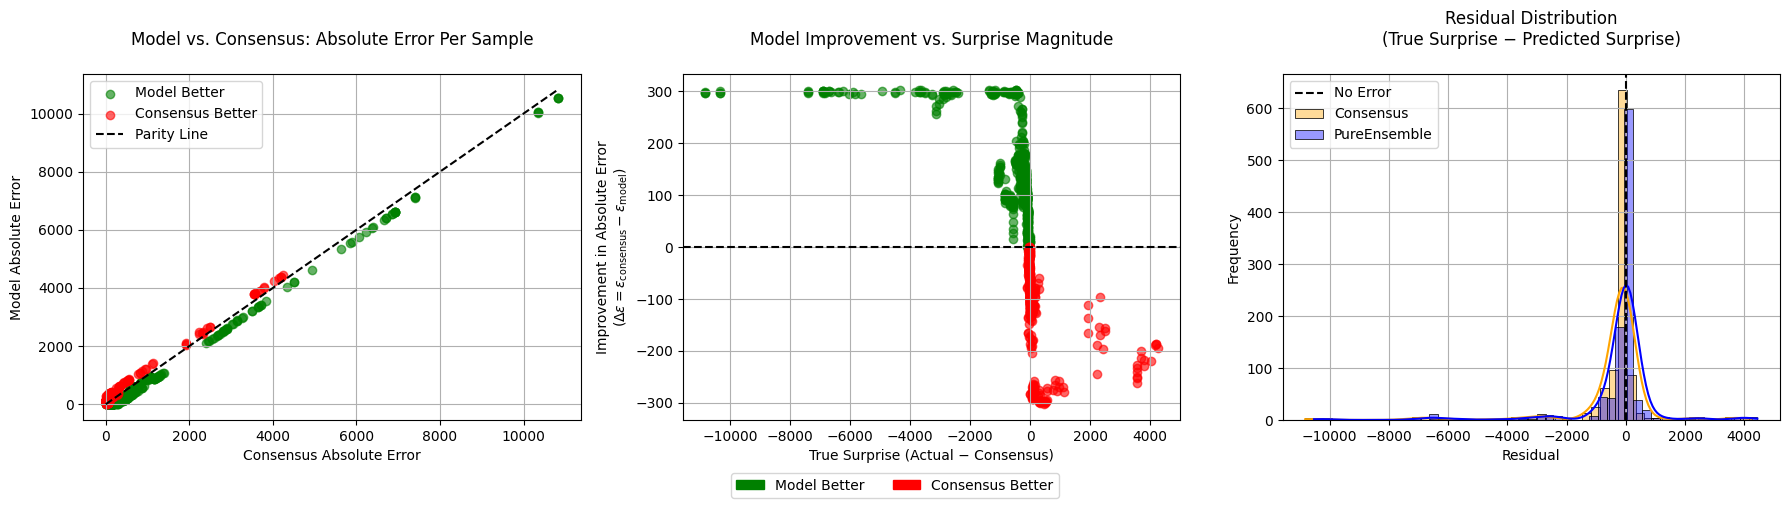


[Comparison Summary: PureEnsemble]
Model better in 594 of 1028 samples (57.8%)
Consensus better in 434 of 1028 samples (42.2%)
Tie in 0 of 1028 samples (0.0%)


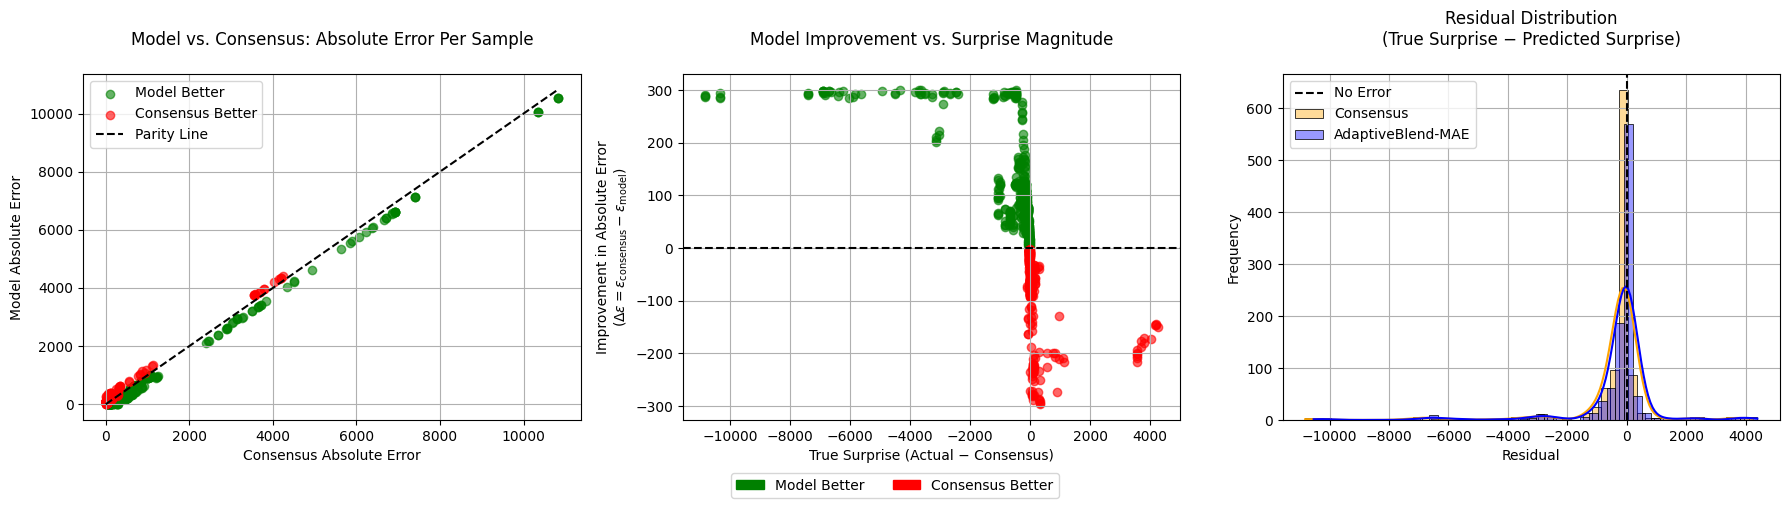


[Comparison Summary: AdaptiveBlend-MAE]
Model better in 522 of 1028 samples (50.8%)
Consensus better in 298 of 1028 samples (29.0%)
Tie in 208 of 1028 samples (20.2%)


In [93]:
for model in ["PureEnsemble", "AdaptiveBlend-MAE"]:
    plot_model_vs_consensus_triplet(model, actual, consensus, df=MLP_analyst_models_robustness_df, titlesuffix=False)

In [94]:
mlp_ensemble_analyst_metrics_single_model = MLP_analyst_models_robustness_df[MLP_analyst_models_robustness_df['Model']=='EBITDA-MLP-Analyst (PureEnsemble)'].copy()

In [95]:
mlp_ensemble_analyst_tail_results = evaluate_tail_behaviour(
    pred_input=mlp_ensemble_analyst_metrics_single_model,
    consensus=consensus,
    actual=actual,
    model_name="EBITDA-MLP-Analyst (PureEnsemble)",
    plot=False,
    include_baseline=True,
    log_kde_y='auto'
)
mlp_ensemble_analyst_tail_results

,Model,Type,MAE,RMSE,95th %ile Abs Error,Mean Abs Error in Tail,MAE on Surprise >±10%,Tail MAE (Positive Surprise),Tail MAE (Negative Surprise)
0,Baseline,baseline,589.21,1526.24,3533.07,5790.40,1076.39,1006.93,3555.31
1,EBITDA-MLP-Analyst (PureEnsemble),model,549.81,1467.98,3297.89,5641.12,974.73,1227.13,3285.97


## Final Analyst Residual Model Choice

* PureEnsemble
* AdaptiveBlend-MAE

# Hybrid Residual Training

## MLP Training Config

In [96]:
class HybridMLP(nn.Module):
    def __init__(self, input_dim: int):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.LayerNorm(64),
            nn.Dropout(0.4),

            nn.Linear(64, 32),
            nn.ReLU(),
            nn.LayerNorm(32),
            nn.Dropout(0.3),

            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.net(x).squeeze(-1)

## Training Loop for each seed

In [97]:
mlp_hybrid_histories_by_run = {}
mlp_hybrid_mc_samples_by_run = {}
mlp_hybrid_preprocessors_by_cfg = {}
mlp_hybrid_models_by_seed_cfg = {}
mlp_hybrid_ensemble_meta_params = {}

USE_MLP_BAYESIAN = True
USE_DEEP_ENSEMBLE = True
MC_PASSES = 30
CALIBRATE_INTERVALS = True
TARGET_COVERAGE = 0.90
EVALUATE_MC_PER_SEED = True

SEED = 42
SEEDS = list(range(10)) if USE_DEEP_ENSEMBLE else [SEED]

y_train = train_df["surp_cons_raw"]
y_val = val_df["surp_cons_raw"]
consensus = val_df[f"{col_prefix}_estimate"].values
actual = val_df[f"{col_prefix}_actual"].values
baseline_pred = consensus

emb_subset = [c for c in train_df.columns if c.startswith("embedding_full_")]
all_feats = hybrid_numeric_feats + emb_subset + hybrid_cat_cols

preproc = build_preprocessor(
    numeric_cols=hybrid_numeric_feats,
    emb_cols=emb_subset,
    cat_cols=hybrid_cat_cols
)

X_train = preproc.fit_transform(train_df[all_feats]).astype(np.float32)
X_val = preproc.transform(val_df[all_feats]).astype(np.float32)

# store fitted preproc to use on final test later
mlp_hybrid_preprocessors_by_cfg["full"] = preproc

mlp_hybrid_robust_rows = []

# RUN TRAINING LOOP (per seed)
for seed in SEEDS:
    print(f"\n>>> Training for seed {seed}...")
    set_global_seed(seed)

    train_dataset = MetricDataset(X_train, y_train)
    batch_size = 128
    g = torch.Generator().manual_seed(seed)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, generator=g)

    num_epochs = 150
    total_steps = num_epochs * len(train_loader)

    config = TrainerConfig(
        model_class=HybridMLP,
        input_dim=X_train.shape[1],
        num_epochs=num_epochs,
        batch_size=batch_size,
        lr=5e-4,
        weight_decay=1e-5,
        early_stop_patience=20,
        loss_fn=nn.MSELoss(),
        optimizer_fn=lambda params: torch.optim.Adam(params, lr=5e-4, weight_decay=1e-5),
        scheduler_fn=lambda opt: torch.optim.lr_scheduler.OneCycleLR(
            opt,
            max_lr=5e-4*9,
            total_steps=total_steps,
            pct_start=0.1,
            anneal_strategy="cos"
        ),
        clip_grad_norm=0.5,
        weight_init_fn=init_weights,
        show_progress=True,
        mc_dropout=USE_MLP_BAYESIAN,
        mc_passes=MC_PASSES,
        evaluate_mc_per_seed=EVALUATE_MC_PER_SEED,
        calibrate_intervals=CALIBRATE_INTERVALS,
        target_coverage=TARGET_COVERAGE,
        deep_ensemble=USE_DEEP_ENSEMBLE
        )

    trainer = MLPTrainer(
        train_loader=train_loader,
        X_train=X_train,
        y_train=y_train,
        X_val=X_val,
        y_val=y_val,
        config=config
    )

    history, best_preds = trainer.train()
    mlp_hybrid_models_by_seed_cfg[seed] = copy.deepcopy(trainer.model).cpu()
    mlp_hybrid_histories_by_run[seed] = history

    if config.mc_dropout and config.evaluate_mc_per_seed:
        trainer.validate()
        metrics = trainer.evaluate_mc_sample_metrics(y_true=y_val, consensus=consensus, actual=actual)
        mc_samples = trainer.val_samples
    else:
        preds = best_preds if best_preds is not None else trainer.model(trainer._prepare_tensor(X_val)).cpu().numpy().ravel()
        mc_samples = preds[None, :]
        pred_mean = mc_samples.mean(axis=0)
        pred_actual = consensus + pred_mean
        mae_s, rmse_s, hit_s = evaluate_surprise(y_val, pred_mean)
        mae_a, rmse_a, mape_a, r2_a = evaluate_actuals_from_residual(actual, consensus, pred_mean)
        metrics = {
            "MAE_s": mae_s, "RMSE_s": rmse_s, "HitRatio": hit_s,
            "MAE": mae_a, "RMSE": rmse_a, "MAPE": mape_a, "R2": r2_a,
            "CRPS": None, "Coverage": None, "PredActual": pred_actual
        }

    mlp_hybrid_mc_samples_by_run[seed] = mc_samples
    mlp_hybrid_robust_rows.append({
        "Seed": seed,
        "Model": f"{metric}-MLP-Hybrid",
        **metrics
    })


>>> Training for seed 0...


Training MLP: 100%|██████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.83it/s]



>>> Training for seed 1...


Training MLP: 100%|██████████████████████████████████████████████████████████████████| 150/150 [00:38<00:00,  3.89it/s]



>>> Training for seed 2...


Training MLP: 100%|██████████████████████████████████████████████████████████████████| 150/150 [00:38<00:00,  3.90it/s]



>>> Training for seed 3...


Training MLP: 100%|██████████████████████████████████████████████████████████████████| 150/150 [00:38<00:00,  3.92it/s]



>>> Training for seed 4...


Training MLP:  99%|█████████████████████████████████████████████████████████████████ | 148/150 [00:37<00:00,  3.91it/s]



>>> Training for seed 5...


Training MLP:  99%|█████████████████████████████████████████████████████████████████▌| 149/150 [00:39<00:00,  3.75it/s]



>>> Training for seed 6...


Training MLP: 100%|██████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.84it/s]



>>> Training for seed 7...


Training MLP: 100%|██████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.73it/s]



>>> Training for seed 8...


Training MLP: 100%|██████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.77it/s]



>>> Training for seed 9...


Training MLP: 100%|██████████████████████████████████████████████████████████████████| 150/150 [00:38<00:00,  3.88it/s]


In [98]:
MLP_hybrid_metrics_df = pd.DataFrame(mlp_hybrid_robust_rows)

#### MLP Model Evaluation on Validation Set

In [99]:
# Evaluate
m4_mlp_dm_df, m4_mlp_surprise_df, m4_mlp_actuals_df = evaluate_mlp_model_metrics(
    metrics_df=MLP_hybrid_metrics_df,
    y_true=actual,
    baseline_pred=baseline_pred,
    h=1,
    alpha=0.05,
    alternative="less"
)

display(m4_mlp_dm_df)
display(m4_mlp_surprise_df)
display(m4_mlp_actuals_df)

,Model,Seed,DM,p,better,Δ_MAE
0,EBITDA-MLP-Hybrid,3,-5.574,0.0000,True,-96.2202
1,EBITDA-MLP-Hybrid,5,-5.203,0.0000,True,-93.4275
2,EBITDA-MLP-Hybrid,1,-4.969,0.0000,True,-87.3471
3,EBITDA-MLP-Hybrid,6,-4.871,0.0000,True,-83.9738
4,EBITDA-MLP-Hybrid,0,-4.667,0.0000,True,-73.7272
5,EBITDA-MLP-Hybrid,4,-4.660,0.0000,True,-85.2998
6,EBITDA-MLP-Hybrid,2,-4.632,0.0000,True,-81.0573
7,EBITDA-MLP-Hybrid,9,-4.261,0.0000,True,-74.0913
8,EBITDA-MLP-Hybrid,8,-3.842,0.0001,True,-72.1470
9,EBITDA-MLP-Hybrid,7,-2.274,0.0115,True,-42.9188


MAE       RMSE  HitRatio
Model             Seed                               
EBITDA-MLP-Hybrid 0     515.4877  1283.8930    0.7821
                  1     501.8677  1257.9462    0.7733
                  2     508.1576  1292.9416    0.7617
                  3     492.9947  1270.3832    0.7792
                  4     503.9151  1281.2366    0.7792
                  5     495.7874  1276.6689    0.7899
                  6     505.2411  1290.1956    0.7646
                  7     546.2961  1315.3615    0.7617
                  8     517.0678  1298.5502    0.7831
                  9     515.1236  1279.0938    0.7840

MAE       RMSE    MAPE      R2      CRPS  \
Model             Seed                                                      
EBITDA-baseline   baseline  589.2149  1526.2420  0.9228  0.9707       NaN   
EBITDA-MLP-Hybrid 0         515.4877  1283.8930  0.9233  0.9793  445.9733   
                  1         501.8677  1257.9462  0.8634  0.9801  434.7998   
                  2         508.1576  1292.9416  0.8861  0.9790  454.3247   
                  3         492.9947  1270.3832  0.8700  0.9797  457.7134   
                  4         503.9151  1281.2366  0.8876  0.9794  447.6758   
                  5         495.7874  1276.6689  0.8682  0.9795  449.2500   
                  6         505.2411  1290.1956  0.9009  0.9791  462.6422   
                  7         546.2961  1315.3615  0.9742  0.9782  472.7990   
                  8         517.0678  1298.5502  0.9069  0.9788  455.8055   
                  9         515.1236  1279.0938  0.8909  0.9794  457.5767   

                            Coverage  
Model             Seed                
EBITDA-baseline   baseline       NaN  
EBITDA-MLP-Hybrid 0           0.8949  
                  1           0.8940  
                  2           0.8988  
                  3           0.8920  
                  4           0.8881  
                  5           0.8959  
                  6           0.8949  
                  7           0.8891  
                  8           0.8940  
                  9           0.8940

#### Robustness evaluation

In [100]:
mlp_hybrid_robustness = evaluate_mlp_seed_robustness(
    metrics_df=MLP_hybrid_metrics_df,
    y_true=actual,
    baseline_pred=consensus,
    metric_name="MAE",
    alternative="less",
    h = 1,
    dataset_name="EBITDA: MLP-Hybrid-Residual",
    show_plot = False
)

=== Final summary for EBITDA: MLP-Hybrid-Residual ===


,Model,SummaryType,MAE_mean_std,MAE_ci95,RMSE_mean,Hit_mean,R2_mean,CRPS_mean,Coverage_mean,DM_mean,DM_std,% of seeds beating baseline
0,EBITDA-MLP-Hybrid,Mean across seeds,510.2 ± 15.1,8.8607,1284.6271,0.7759,0.9793,453.856,0.8936,-4.4953,0.9143,100.0


## Deep Ensemble Experimentation

In [101]:
# Deep-ensemble loop using only p_hat downstream
mlp_hybrid_ensemble_rows = []

if USE_DEEP_ENSEMBLE:
    # Gather MC residual samples from all seeds
    all_samples = [v for v in mlp_hybrid_mc_samples_by_run.values()] # each (mc_passes, N)
    if not all_samples:
        raise ValueError("No MC samples found in mlp_hybrid_mc_samples_by_run")
    samples = np.concatenate(all_samples, axis=0)  # (mc_passes*seeds, N)

    # Ensemble stats on residuals
    emean, sigma, iqr, snr, err_cons, p_win = compute_ensemble_stats(samples, consensus, actual)

    # Pure-ensemble point prediction (consensus + mean residual)
    y_ensem = consensus + emean

    # CRPS & coverage for the pure-ensemble (on residual samples)
    crps = calc_crps(y_val, samples, axis=0).mean()
    lower, upper = np.percentile(samples, [5, 95], axis=0)
    coverage = ((y_val >= lower) & (y_val <= upper)).mean()

    # Report pure-ensemble metrics
    mae_s_e, rmse_s_e, hit_s_e = evaluate_surprise(y_val, emean)
    mae_a_e, rmse_a_e, mape_a_e, r2_a_e = evaluate_actuals_from_residual(actual, consensus, emean)

    mlp_hybrid_ensemble_rows.append({
        "Seed": "Ensemble",
        "Model": f"{metric}-MLP-Hybrid (PureEnsemble)",
        "MAE_s": mae_s_e, "RMSE_s": rmse_s_e, "HitRatio": hit_s_e,
        "MAE": mae_a_e, "RMSE": rmse_a_e, "MAPE": mape_a_e, "R2": r2_a_e,
        "CRPS": crps, "Coverage": coverage, "PredActual": y_ensem
    })

    # OOF adaptive blend (returns OOF point preds)
    c2_grid = [0.0, 0.25, 0.5, 0.75, 1.0]
    alpha_grid = [-8, -6, -4, -2, 0, 2, 4, 6, 8]
    beta_grid = [-4, -3, -2, -1, 0, 1, 2, 3, 4]
    n_splits = 4

    oof_mae = oof_adaptive_mae(
        snr, iqr, sigma, p_win,
        emean, consensus, actual, err_cons,
        c2_grid, alpha_grid, beta_grid,
        n_splits=n_splits
    )

    # Fallback to consensus where OOF is NaN, then evaluate on the full series
    y_pred_full = np.where(np.isnan(oof_mae), consensus, oof_mae)
    resid_full  = y_pred_full - consensus
    
    # Surprise metrics (true residual vs predicted residual)
    mae_s, rmse_s, hit_s = evaluate_surprise(actual - consensus, resid_full)
    
    # Actual metrics from residuals (full series)
    mae_a_full, rmse_a_full, mape_a_full, r2_a_full = evaluate_actuals_from_residual(actual, consensus, resid_full)
    
    mlp_hybrid_ensemble_rows.append({
        "Seed": "Ensemble",
        "Model": f"{metric}-MLP-Hybrid (AdaptiveBlend-MAE)",
        "MAE_s": mae_s, "RMSE_s": rmse_s, "HitRatio": hit_s,
        "MAE": mae_a_full, "RMSE": rmse_a_full, "MAPE": mape_a_full, "R2": r2_a_full,
        "CRPS": None,
        "Coverage": None, 
        "PredActual": y_pred_full
    })

    # Final refit of meta-params on ALL points (for future test-time use)
    full_idx = np.arange(len(actual))
    c2_full, iso_full, thr_full, p_hat_full = _refit_iso_on_train(full_idx, snr, iqr, sigma, p_win, c2_grid, consensus, actual, err_cons, emean)
    a_full, b_full = _refit_adaptive_on_train(full_idx, p_hat_full, emean, consensus, actual, err_cons, alpha_grid, beta_grid, optimize="mae")

    # Store under a single key since you have one config
    mlp_hybrid_ensemble_meta_params["full"] = {
        "driver": "isotonic_composite",
        "c2": float(c2_full),
        "iso_x": iso_full.X_thresholds_.tolist(),
        "iso_y": iso_full.y_thresholds_.tolist(),
        "thr": float(thr_full),
        "adaptive": "sigmoid-mae",
        "alpha_mae": float(a_full),
        "beta_mae": float(b_full),
        "mc_passes": int(MC_PASSES),
        "deep_ensemble": True,
    }

Adaptive-blend-MAE per-fold (MAE, Hit): [(756.9752598773805, 0.7024390243902439), (545.721742295015, 0.6780487804878049), (343.256135251316, 0.7317073170731707), (330.10585054577126, 0.624390243902439)]


In [102]:
MLP_ensemble_hybrid_metrics_df = pd.DataFrame(mlp_hybrid_ensemble_rows)

### Model Evaluation on Validation Set

In [103]:
# Summary tables
dm_df, surprise_df, actuals_df = evaluate_mlp_model_metrics(
    metrics_df=MLP_ensemble_hybrid_metrics_df ,
    y_true=actual,
    baseline_pred=baseline_pred,
    h=1,
    alpha=0.05,
    alternative="less"
)
display(dm_df)
display(surprise_df)
display(actuals_df)

,Model,Seed,DM,p,better,Δ_MAE
0,EBITDA-MLP-Hybrid (AdaptiveBlend-MAE),Ensemble,-6.764,0.0,True,-89.3287
1,EBITDA-MLP-Hybrid (PureEnsemble),Ensemble,-5.023,0.0,True,-87.5092


,,MAE,RMSE,HitRatio
Model,Seed,,,
EBITDA-MLP-Hybrid (PureEnsemble),Ensemble,501.7057,1279.2210,0.7918
EBITDA-MLP-Hybrid (AdaptiveBlend-MAE),Ensemble,499.8862,1317.2381,0.6488


,,MAE,RMSE,MAPE,R2,CRPS,Coverage
Model,Seed,,,,,,
EBITDA-baseline,baseline,589.2149,1526.2420,0.9228,0.9707,NaN,NaN
EBITDA-MLP-Hybrid (PureEnsemble),Ensemble,501.7057,1279.2210,0.8794,0.9794,438.9917,0.9105
EBITDA-MLP-Hybrid (AdaptiveBlend-MAE),Ensemble,499.8862,1317.2381,0.8486,0.9782,NaN,NaN


#### Robustness evaluation

In [104]:
MLP_ensemble_hybrid_robust_metrics_df = pd.DataFrame(mlp_hybrid_robust_rows + mlp_hybrid_ensemble_rows)

In [105]:
mlp_hybrid_ensemble_robustness = evaluate_mlp_seed_robustness(
    metrics_df=MLP_ensemble_hybrid_robust_metrics_df,
    y_true=actual,
    baseline_pred=consensus,
    metric_name="MAE",
    alternative="less",
    h = 1,
    dataset_name="MLP-Hybrid-Residual",
    show_plot = False
)

=== Final summary for MLP-Hybrid-Residual ===


,Model,SummaryType,MAE_mean_std,MAE_ci95,RMSE_mean,Hit_mean,R2_mean,CRPS_mean,Coverage_mean,DM_mean,DM_std,% of seeds beating baseline
0,EBITDA-MLP-Hybrid,Mean across seeds,510.2 ± 15.1,8.8607,1284.627100,0.775900,0.979300,453.856000,0.893600,-4.4953,0.9143,100.0
1,EBITDA-MLP-Hybrid (PureEnsemble),Ensemble,501.7,NaN,1279.220963,0.791829,0.979429,438.991738,0.910506,NaN,NaN,NaN
2,EBITDA-MLP-Hybrid (AdaptiveBlend-MAE),Ensemble,499.9,NaN,1317.238073,0.648833,0.978188,NaN,NaN,NaN,NaN,NaN


#### Model vs Consensus Plots

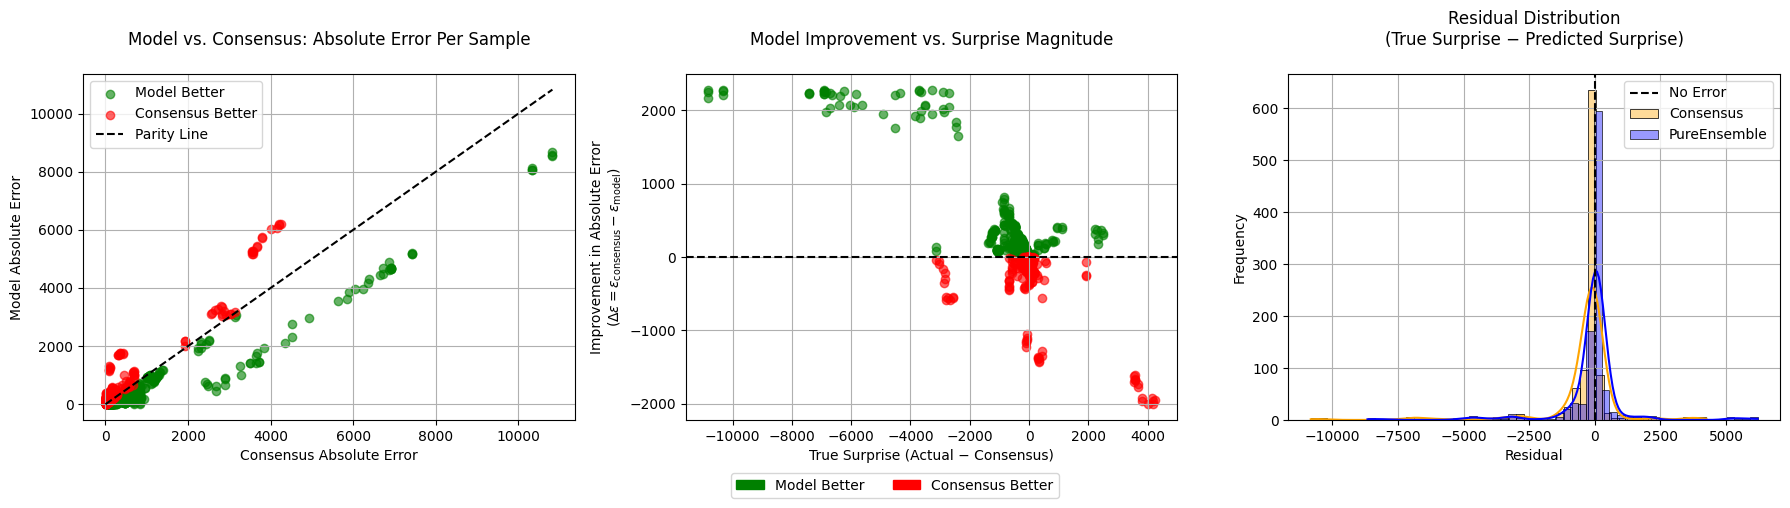


[Comparison Summary: PureEnsemble]
Model better in 596 of 1028 samples (58.0%)
Consensus better in 432 of 1028 samples (42.0%)
Tie in 0 of 1028 samples (0.0%)


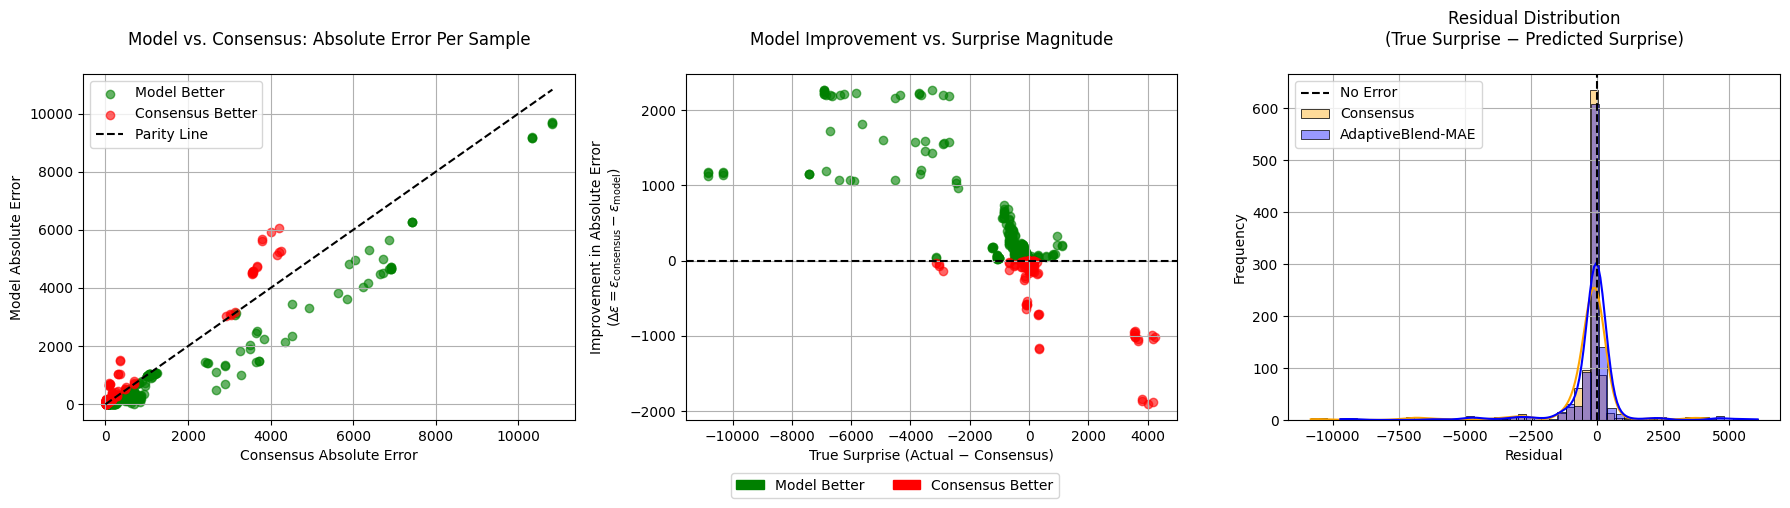


[Comparison Summary: AdaptiveBlend-MAE]
Model better in 561 of 1028 samples (54.6%)
Consensus better in 259 of 1028 samples (25.2%)
Tie in 208 of 1028 samples (20.2%)


In [106]:
for model in ["PureEnsemble", "AdaptiveBlend-MAE"]:
    plot_model_vs_consensus_triplet(model, actual, consensus, df=MLP_ensemble_hybrid_robust_metrics_df, titlesuffix=False)

#### Tail Behaviour Analysis

In [107]:
mlp_ensemble_hybrid_metrics_single_model = MLP_ensemble_hybrid_robust_metrics_df[MLP_ensemble_hybrid_robust_metrics_df['Model']=='EBITDA-MLP-Hybrid (PureEnsemble)'].copy()

In [108]:
mlp_ensemble_hybrid_tail_results = evaluate_tail_behaviour(
    pred_input=mlp_ensemble_hybrid_metrics_single_model,
    consensus=consensus,
    actual=actual,
    model_name="EBITDA-MLP-Hybrid (PureEnsemble)",
    plot=False,
    include_baseline=True,
    log_kde_y='auto'
)
mlp_ensemble_hybrid_tail_results

,Model,Type,MAE,RMSE,95th %ile Abs Error,Mean Abs Error in Tail,MAE on Surprise >±10%,Tail MAE (Positive Surprise),Tail MAE (Negative Surprise)
0,Baseline,baseline,589.21,1526.24,3533.07,5790.40,1076.39,1006.93,3555.31
1,EBITDA-MLP-Hybrid (PureEnsemble),model,501.71,1279.22,3106.01,5011.25,880.02,1386.31,2501.75


## Final Analyst Residual Model Choice

* PureEnsemble
* AdaptiveBlend-MAE

# FINAL TEST

## Language-only Residual Models

In [109]:
# Preprocess test features & generate MC samples

BASE_MC_SEED = 12345
MC_PASSES = 30

mlp_lang_mc_samples_test = {}

# Get preprocessor and models
preproc = mlp_lang_preprocessors_by_cfg["full"]
models = [mlp_lang_models_by_seed_cfg[seed] for seed in SEEDS]

# Assemble feature matrix
emb_cols = [c for c in test_df.columns if c.startswith("embedding_full_")]
all_feats = text_feats + emb_cols + text_cat_cols
X_test_all = preproc.transform(test_df[all_feats]).astype(np.float32)
X_tensor = torch.from_numpy(X_test_all)

# MC-dropout: for each seed, run MC_PASSES forward passes
samples_per_seed = []
for seed, model in zip(SEEDS, models):
    model.eval()
    for m in model.modules():
        if isinstance(m, torch.nn.Dropout):
            m.train()
    draws = []
    for i in range(MC_PASSES):
        torch.manual_seed(BASE_MC_SEED + seed * MC_PASSES + i)
        with torch.no_grad():
            out = model(X_tensor).cpu().numpy().ravel()
        draws.append(out)
    samples_per_seed.append(np.stack(draws, axis=0))

# Concatenate all seeds into one big ensemble (residual samples)
samples = np.concatenate(samples_per_seed, axis=0)

# Compute ensemble stats on TEST
test_consensus = test_df[f"{col_prefix}_estimate"].values
test_actual = test_df[f"{col_prefix}_actual"].values
y_test_resid = test_df["surp_cons_raw"].values

emean, sigma, iqr, snr, err_cons, _ = compute_ensemble_stats(samples, test_consensus, test_actual)

# Pure Ensemble metrics
y_pure = test_consensus + emean
mae_s_pe, rmse_s_pe, hit_s_pe = evaluate_surprise(y_test_resid, emean)
mae_pe, rmse_pe, mape_pe, r2_pe = evaluate_actuals_from_residual(test_actual, test_consensus, emean)

mlp_lang_test_rows = []
mlp_lang_test_rows.append({
    "Seed": "Ensemble",
    "Model": f"{metric}-MLP-Lang (PureEnsemble)",
    "MAE_s": mae_s_pe,
    "RMSE_s": rmse_s_pe,
    "HitRatio": hit_s_pe,
    "MAE": mae_pe,
    "RMSE": rmse_pe,
    "MAPE": mape_pe,
    "R2": r2_pe,
    "PredActual": y_pure
})

# AdaptiveBlend-MAE on TEST
meta = mlp_lang_ensemble_meta_params["full"]

x_thresh = np.array(meta["iso_x"])
y_thresh = np.array(meta["iso_y"])
z_test = snr + meta["c2"] * (iqr / (sigma + 1e-8))

p_hat_test = np.interp(
    z_test,
    x_thresh,
    y_thresh,
    left=y_thresh[0],
    right=y_thresh[-1]
)

a_mae = meta["alpha_mae"]
b_mae = meta["beta_mae"]
w_test = 1.0 / (1.0 + np.exp(-(a_mae * p_hat_test + b_mae)))

y_adapt = test_consensus + w_test * emean

# Adaptive blend metrics
mae_s_ab, rmse_s_ab, hit_s_ab = evaluate_surprise(y_test_resid, w_test * emean)
mae_ab, rmse_ab, mape_ab, r2_ab = evaluate_actuals_from_residual(test_actual, test_consensus, w_test * emean)

mlp_lang_test_rows.append({
    "Seed": "Ensemble",
    "Model": f"{metric}-MLP-Lang (AdaptiveBlend-MAE)",
    "MAE_s": mae_s_ab,
    "RMSE_s": rmse_s_ab,
    "HitRatio": hit_s_ab,
    "MAE": mae_ab,
    "RMSE": rmse_ab,
    "MAPE": mape_ab,
    "R2": r2_ab,
    "PredActual": y_adapt
})

final_lang_test_results_df = pd.DataFrame(mlp_lang_test_rows)

In [110]:
final_lang_mlp_dm_df, final_lang_mlp_surprise_df, final_lang_mlp_actuals_df = evaluate_mlp_final_test(
    metrics_df=final_lang_test_results_df,
    y_true=test_actual,
    baseline_pred=test_consensus,
    h=1,
    alpha=0.05,
    alternative="less"
)

display(final_lang_mlp_dm_df)
display(final_lang_mlp_surprise_df)
display(final_lang_mlp_actuals_df)

,Model,Seed,DM,p,better,Δ_MAE
0,EBITDA-MLP-Lang (AdaptiveBlend-MAE),Ensemble,-2.553,0.0053,True,-33.1295
1,EBITDA-MLP-Lang (PureEnsemble),Ensemble,-2.244,0.0124,True,-29.9108


,,MAE,RMSE,HitRatio
Model,Seed,,,
EBITDA-MLP-Lang (PureEnsemble),Ensemble,492.9696,1288.3852,0.8215
EBITDA-MLP-Lang (AdaptiveBlend-MAE),Ensemble,489.7509,1292.7880,0.8215


,,MAE,RMSE,MAPE,R2
Model,Seed,,,,
Revenue-baseline,baseline,522.8804,1575.8681,0.2366,0.9559
EBITDA-MLP-Lang (PureEnsemble),Ensemble,492.9696,1288.3852,0.2686,0.9705
EBITDA-MLP-Lang (AdaptiveBlend-MAE),Ensemble,489.7509,1292.7880,0.2635,0.9703


## Analyst-only Residual Models

In [111]:
# Generate MC samples on test set
BASE_MC_SEED = 12345
MC_PASSES = 30

mlp_analyst_mc_samples_test = []

for seed in SEEDS:
    preproc = mlp_analyst_preprocessors_by_cfg[seed]
    model = mlp_analyst_models_by_seed_cfg[seed]

    X_test = preproc.transform(test_df[analyst_feats + analyst_cat_cols]).astype(np.float32)
    X_tensor = torch.from_numpy(X_test)

    model.eval()
    for m in model.modules():
        if isinstance(m, torch.nn.Dropout):
            m.train()

    draws = []
    for i in range(MC_PASSES):
        torch.manual_seed(BASE_MC_SEED + seed * MC_PASSES + i)
        with torch.no_grad():
            out = model(X_tensor).cpu().numpy().ravel()
        draws.append(out)

    mlp_analyst_mc_samples_test.append(np.stack(draws, axis=0))

# Combine across seeds --> (n_seeds * MC_PASSES, n_test)
analyst_samples = np.concatenate(mlp_analyst_mc_samples_test, axis=0)

# Compute ensemble stats on test
test_consensus = test_df[f"{col_prefix}_estimate"].values
test_actual = test_df[f"{col_prefix}_actual"].values
y_test_resid = test_df["surp_cons_raw"].values

mlp_analyst_test_rows = []

emean, sigma, iqr, snr, err_cons, _ = compute_ensemble_stats(analyst_samples, test_consensus, test_actual)

# PURE ENSEMBLE
y_pure = test_consensus + emean
mae_s_pe, rmse_s_pe, hit_s_pe = evaluate_surprise(y_test_resid, emean)
mae_pe, rmse_pe, mape_pe, r2_pe = evaluate_actuals_from_residual(test_actual, test_consensus, emean)

mlp_analyst_test_rows.append({
    "Seed": "Ensemble",
    "Embed": None,
    "n_PCs": None,
    "Model": f"{metric}-MLP-Analyst (PureEnsemble)",
    "MAE_s": mae_s_pe,
    "RMSE_s": rmse_s_pe,
    "HitRatio": hit_s_pe,
    "MAE": mae_pe,
    "RMSE": rmse_pe,
    "MAPE": mape_pe,
    "R2": r2_pe,
    "PredActual": y_pure
})

# ADAPTIVE BLEND (sigmoid-MAE)
meta = mlp_analyst_ensemble_meta_params["Ensemble"]
x_thresh = np.array(meta["iso_x"])
y_thresh = np.array(meta["iso_y"])
z_test = snr + meta["c2"] * (iqr / (sigma + 1e-8))

p_hat_test = np.interp(z_test, x_thresh, y_thresh, left=y_thresh[0], right=y_thresh[-1])
a_mae = meta["alpha_mae"]
b_mae = meta["beta_mae"]
w_test = 1.0 / (1.0 + np.exp(-(a_mae * p_hat_test + b_mae)))

y_adapt = test_consensus + w_test * emean

mae_s_ab, rmse_s_ab, hit_s_ab = evaluate_surprise(y_test_resid, w_test * emean)
mae_ab, rmse_ab, mape_ab, r2_ab = evaluate_actuals_from_residual(test_actual, test_consensus, w_test * emean)

mlp_analyst_test_rows.append({
    "Seed": "Ensemble",
    "Embed": None,
    "n_PCs": None,
    "Model": f"{metric}-MLP-Analyst (AdaptiveBlend-MAE)",
    "MAE_s": mae_s_ab,
    "RMSE_s": rmse_s_ab,
    "HitRatio": hit_s_ab,
    "MAE": mae_ab,
    "RMSE": rmse_ab,
    "MAPE": mape_ab,
    "R2": r2_ab,
    "PredActual": y_adapt
})

final_analyst_test_results_df = pd.DataFrame(mlp_analyst_test_rows)

In [112]:
final_analyst_mlp_dm_df, final_analyst_mlp_surprise_df, final_analyst_mlp_actuals_df = evaluate_mlp_final_test(
    metrics_df=final_analyst_test_results_df,
    y_true=test_actual,
    baseline_pred=test_consensus,
    h=1,
    alpha=0.05,
    alternative="less"
)

display(final_analyst_mlp_dm_df)
display(final_analyst_mlp_surprise_df)
display(final_analyst_mlp_actuals_df)

,Model,Seed,DM,p,better,Δ_MAE
0,EBITDA-MLP-Analyst (AdaptiveBlend-MAE),Ensemble,-3.657,0.0001,True,-16.8458
1,EBITDA-MLP-Analyst (PureEnsemble),Ensemble,-3.489,0.0002,True,-16.2394


,,MAE,RMSE,HitRatio
Model,Seed,,,
EBITDA-MLP-Analyst (PureEnsemble),Ensemble,506.6411,1502.2573,0.8019
EBITDA-MLP-Analyst (AdaptiveBlend-MAE),Ensemble,506.0346,1502.9825,0.8019


,,MAE,RMSE,MAPE,R2
Model,Seed,,,,
Revenue-baseline,baseline,522.8804,1575.8681,0.2366,0.9559
EBITDA-MLP-Analyst (PureEnsemble),Ensemble,506.6411,1502.2573,0.2376,0.9599
EBITDA-MLP-Analyst (AdaptiveBlend-MAE),Ensemble,506.0346,1502.9825,0.2365,0.9598


## Hybrid Residual Models

In [113]:
# Preprocess test features & generate MC samples

BASE_MC_SEED = 12345
MC_PASSES = 30

# Get the fitted preprocessor and seed models
preproc = mlp_hybrid_preprocessors_by_cfg["full"]  # fitted on train
models = [mlp_hybrid_models_by_seed_cfg[seed] for seed in SEEDS]

# Assemble test feature matrix (same recipe as train)
emb_cols = [c for c in test_df.columns if c.startswith("embedding_full_")]
all_feats = hybrid_numeric_feats + emb_cols + hybrid_cat_cols
X_test = preproc.transform(test_df[all_feats]).astype(np.float32)
X_tensor = torch.from_numpy(X_test)

# MC‐dropout sampling for each seed
samples_per_seed = []
for seed, model in zip(SEEDS, models):
    model.eval()
    # enable dropout at inference for MC
    for m in model.modules():
        if isinstance(m, torch.nn.Dropout):
            m.train()
    draws = []
    for i in range(MC_PASSES):
        torch.manual_seed(BASE_MC_SEED + seed * MC_PASSES + i)
        with torch.no_grad():
            out = model(X_tensor).cpu().numpy().ravel()  # residual predictions
        draws.append(out)
    samples_per_seed.append(np.stack(draws, axis=0))  # (mc, n_test)

# (mc * n_seeds, n_test) residual samples
samples = np.concatenate(samples_per_seed, axis=0)

# Compute ensemble stats on TEST (residual space)
test_consensus = test_df[f"{col_prefix}_estimate"].values
test_actual = test_df[f"{col_prefix}_actual"].values
y_test_resid = test_df["surp_cons_raw"].values

emean, sigma, iqr, snr, err_cons, _ = compute_ensemble_stats(samples, test_consensus, test_actual)

mlp_hybrid_test_rows = []

# Pure Ensemble
y_pure = test_consensus + emean
mae_s_pe, rmse_s_pe, hit_s_pe = evaluate_surprise(y_test_resid, emean)
mae_pe, rmse_pe, mape_pe, r2_pe = evaluate_actuals_from_residual(test_actual, test_consensus, emean)

mlp_hybrid_test_rows.append({
    "Seed": "Ensemble",
    "Model": f"{metric}-MLP-Hybrid (PureEnsemble)",
    "MAE_s": mae_s_pe,
    "RMSE_s": rmse_s_pe,
    "HitRatio": hit_s_pe,
    "MAE": mae_pe,
    "RMSE": rmse_pe,
    "MAPE": mape_pe,
    "R2": r2_pe,
    "PredActual": y_pure
})

# AdaptiveBlend-MAE 
meta = mlp_hybrid_ensemble_meta_params["full"]
x_thresh = np.array(meta["iso_x"])
y_thresh = np.array(meta["iso_y"])
z_test = snr + meta["c2"] * (iqr / (sigma + 1e-8))

# interpolate isotonic curve
p_hat_test = np.interp(z_test, x_thresh, y_thresh, left=y_thresh[0], right=y_thresh[-1])

a_mae = meta["alpha_mae"]
b_mae = meta["beta_mae"]
w_test = 1.0 / (1.0 + np.exp(-(a_mae * p_hat_test + b_mae)))

y_adapt = test_consensus + w_test * emean

mae_s_ab, rmse_s_ab, hit_s_ab = evaluate_surprise(y_test_resid, w_test * emean)
mae_ab, rmse_ab, mape_ab, r2_ab = evaluate_actuals_from_residual(test_actual, test_consensus, w_test * emean)

mlp_hybrid_test_rows.append({
    "Seed": "Ensemble",
    "Model": f"{metric}-MLP-Hybrid (AdaptiveBlend-MAE)",
    "MAE_s": mae_s_ab,
    "RMSE_s": rmse_s_ab,
    "HitRatio": hit_s_ab,
    "MAE": mae_ab,
    "RMSE": rmse_ab,
    "MAPE": mape_ab,
    "R2": r2_ab,
    "PredActual": y_adapt
})

final_hybrid_test_results_df = pd.DataFrame(mlp_hybrid_test_rows)

In [114]:
final_hybrid_mlp_dm_df, final_hybrid_mlp_surprise_df, final_hybrid_mlp_actuals_df = evaluate_mlp_final_test(
    metrics_df=final_hybrid_test_results_df,
    y_true=test_actual,
    baseline_pred=test_consensus,
    h=1,
    alpha=0.05,
    alternative="less"
)

display(final_hybrid_mlp_dm_df)
display(final_hybrid_mlp_surprise_df)
display(final_hybrid_mlp_actuals_df)

,Model,Seed,DM,p,better,Δ_MAE
0,EBITDA-MLP-Hybrid (AdaptiveBlend-MAE),Ensemble,-3.061,0.0011,True,-49.9450
1,EBITDA-MLP-Hybrid (PureEnsemble),Ensemble,-2.105,0.0176,True,-35.8267


,,MAE,RMSE,HitRatio
Model,Seed,,,
EBITDA-MLP-Hybrid (PureEnsemble),Ensemble,487.0537,1220.4977,0.8122
EBITDA-MLP-Hybrid (AdaptiveBlend-MAE),Ensemble,472.9355,1224.9423,0.8122


,,MAE,RMSE,MAPE,R2
Model,Seed,,,,
Revenue-baseline,baseline,522.8804,1575.8681,0.2366,0.9559
EBITDA-MLP-Hybrid (PureEnsemble),Ensemble,487.0537,1220.4977,0.2784,0.9735
EBITDA-MLP-Hybrid (AdaptiveBlend-MAE),Ensemble,472.9355,1224.9423,0.2588,0.9733


## FINAL ANALYSIS - ALL TOGETHER

In [115]:
final_EBITDA_test_results_df = pd.DataFrame(mlp_lang_test_rows + mlp_analyst_test_rows + mlp_hybrid_test_rows)

In [116]:
final_EBITDA_mlp_dm_df, final_EBITDA_mlp_surprise_df, final_EBITDA_mlp_actuals_df = evaluate_mlp_final_test(
    metrics_df=final_EBITDA_test_results_df,
    y_true=test_actual,
    baseline_pred=test_consensus,
    h=1,
    alpha=0.05,
    alternative="less"
)

display(final_EBITDA_mlp_dm_df)
display(final_EBITDA_mlp_surprise_df)
display(final_EBITDA_mlp_actuals_df)

,Model,Seed,DM,p,better,Δ_MAE
0,EBITDA-MLP-Analyst (AdaptiveBlend-MAE),Ensemble,-3.657,0.0001,True,-16.8458
1,EBITDA-MLP-Analyst (PureEnsemble),Ensemble,-3.489,0.0002,True,-16.2394
2,EBITDA-MLP-Hybrid (AdaptiveBlend-MAE),Ensemble,-3.061,0.0011,True,-49.9450
3,EBITDA-MLP-Lang (AdaptiveBlend-MAE),Ensemble,-2.553,0.0053,True,-33.1295
4,EBITDA-MLP-Lang (PureEnsemble),Ensemble,-2.244,0.0124,True,-29.9108
5,EBITDA-MLP-Hybrid (PureEnsemble),Ensemble,-2.105,0.0176,True,-35.8267


,,MAE,RMSE,HitRatio
Model,Seed,,,
EBITDA-MLP-Lang (PureEnsemble),Ensemble,492.9696,1288.3852,0.8215
EBITDA-MLP-Lang (AdaptiveBlend-MAE),Ensemble,489.7509,1292.7880,0.8215
EBITDA-MLP-Analyst (PureEnsemble),Ensemble,506.6411,1502.2573,0.8019
EBITDA-MLP-Analyst (AdaptiveBlend-MAE),Ensemble,506.0346,1502.9825,0.8019
EBITDA-MLP-Hybrid (PureEnsemble),Ensemble,487.0537,1220.4977,0.8122
EBITDA-MLP-Hybrid (AdaptiveBlend-MAE),Ensemble,472.9355,1224.9423,0.8122


,,MAE,RMSE,MAPE,R2
Model,Seed,,,,
Revenue-baseline,baseline,522.8804,1575.8681,0.2366,0.9559
EBITDA-MLP-Lang (PureEnsemble),Ensemble,492.9696,1288.3852,0.2686,0.9705
EBITDA-MLP-Lang (AdaptiveBlend-MAE),Ensemble,489.7509,1292.7880,0.2635,0.9703
EBITDA-MLP-Analyst (PureEnsemble),Ensemble,506.6411,1502.2573,0.2376,0.9599
EBITDA-MLP-Analyst (AdaptiveBlend-MAE),Ensemble,506.0346,1502.9825,0.2365,0.9598
EBITDA-MLP-Hybrid (PureEnsemble),Ensemble,487.0537,1220.4977,0.2784,0.9735
EBITDA-MLP-Hybrid (AdaptiveBlend-MAE),Ensemble,472.9355,1224.9423,0.2588,0.9733


In [117]:
final_EBITDA_models_robustness_df = pd.DataFrame(mlp_lang_test_rows + mlp_analyst_test_rows + mlp_hybrid_test_rows)

In [118]:
from IPython.display import Markdown, display

### Results for **Language-only Models**

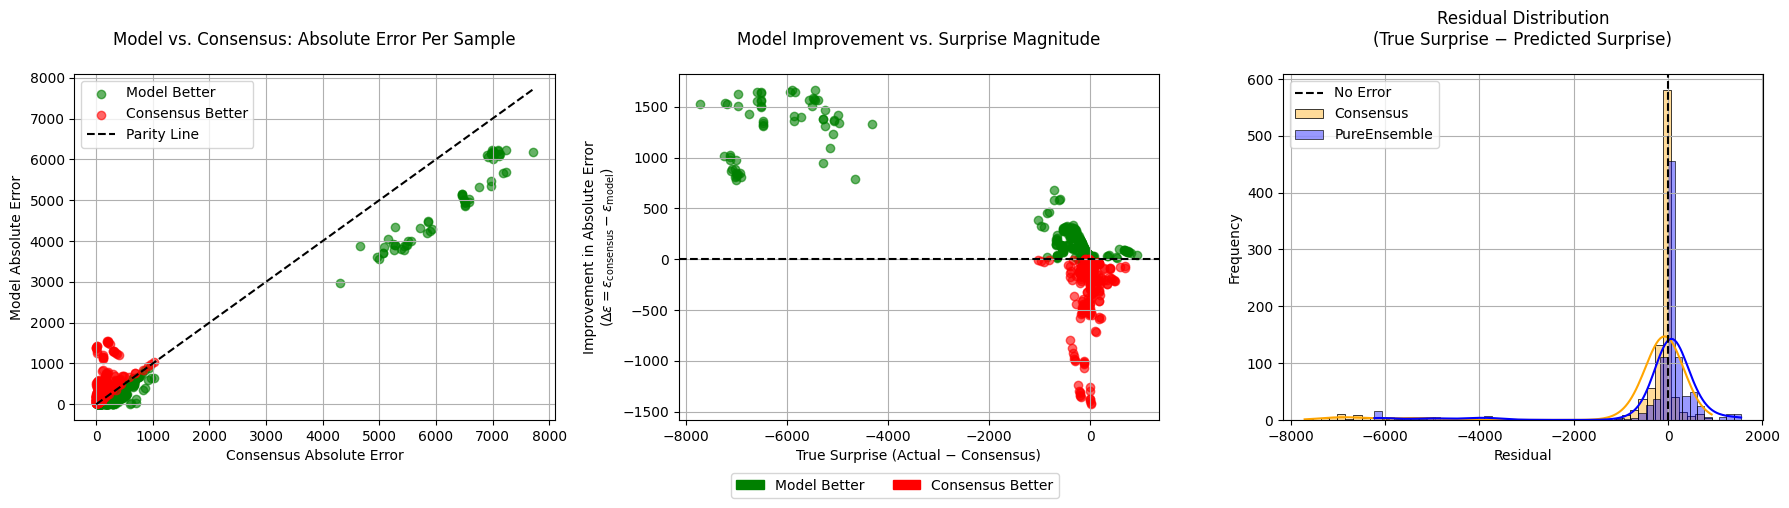


[Comparison Summary: PureEnsemble]
Model better in 478 of 969 samples (49.3%)
Consensus better in 491 of 969 samples (50.7%)
Tie in 0 of 969 samples (0.0%)


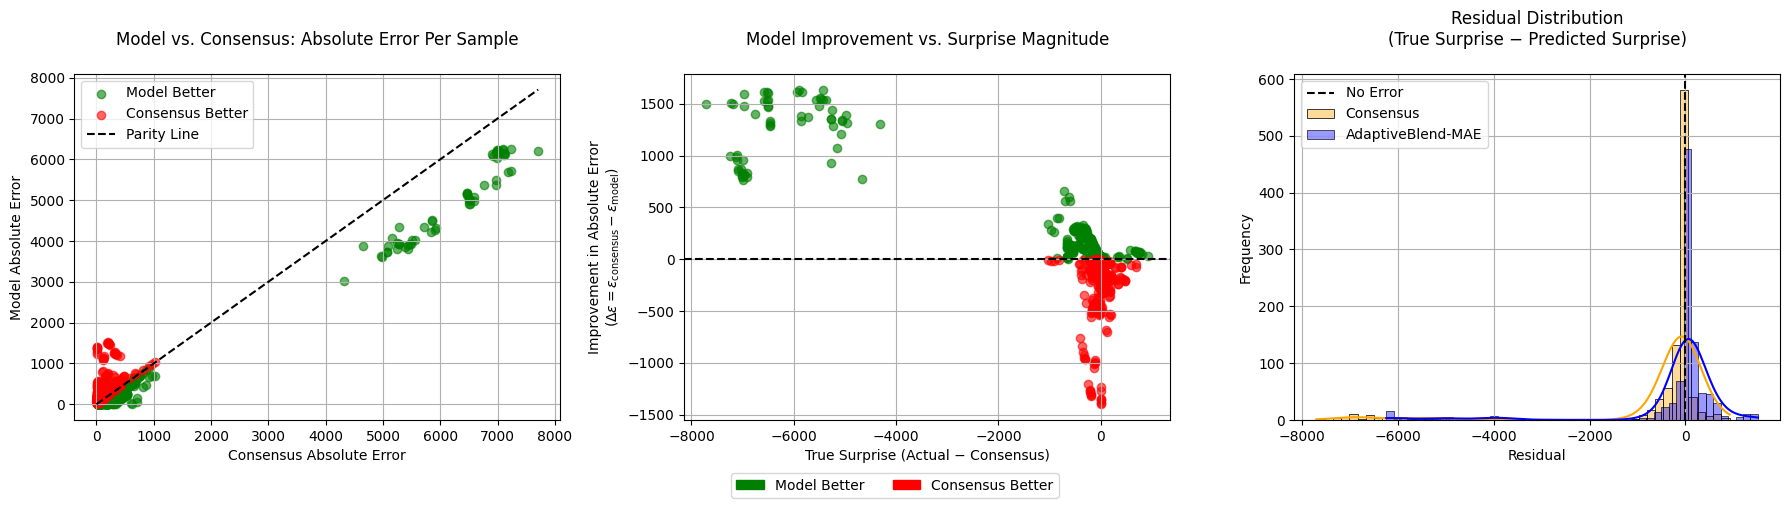


[Comparison Summary: AdaptiveBlend-MAE]
Model better in 489 of 969 samples (50.5%)
Consensus better in 480 of 969 samples (49.5%)
Tie in 0 of 969 samples (0.0%)


### Results for **Analyst-only Models**

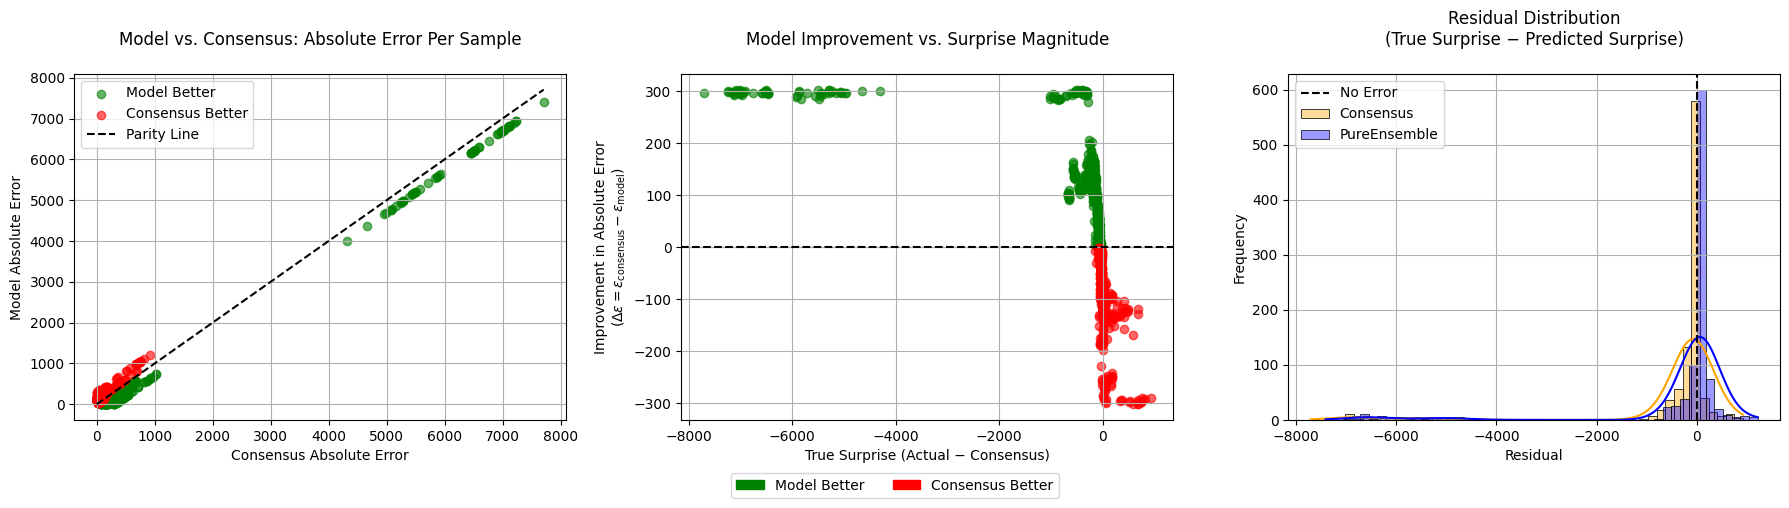


[Comparison Summary: PureEnsemble]
Model better in 484 of 969 samples (49.9%)
Consensus better in 485 of 969 samples (50.1%)
Tie in 0 of 969 samples (0.0%)


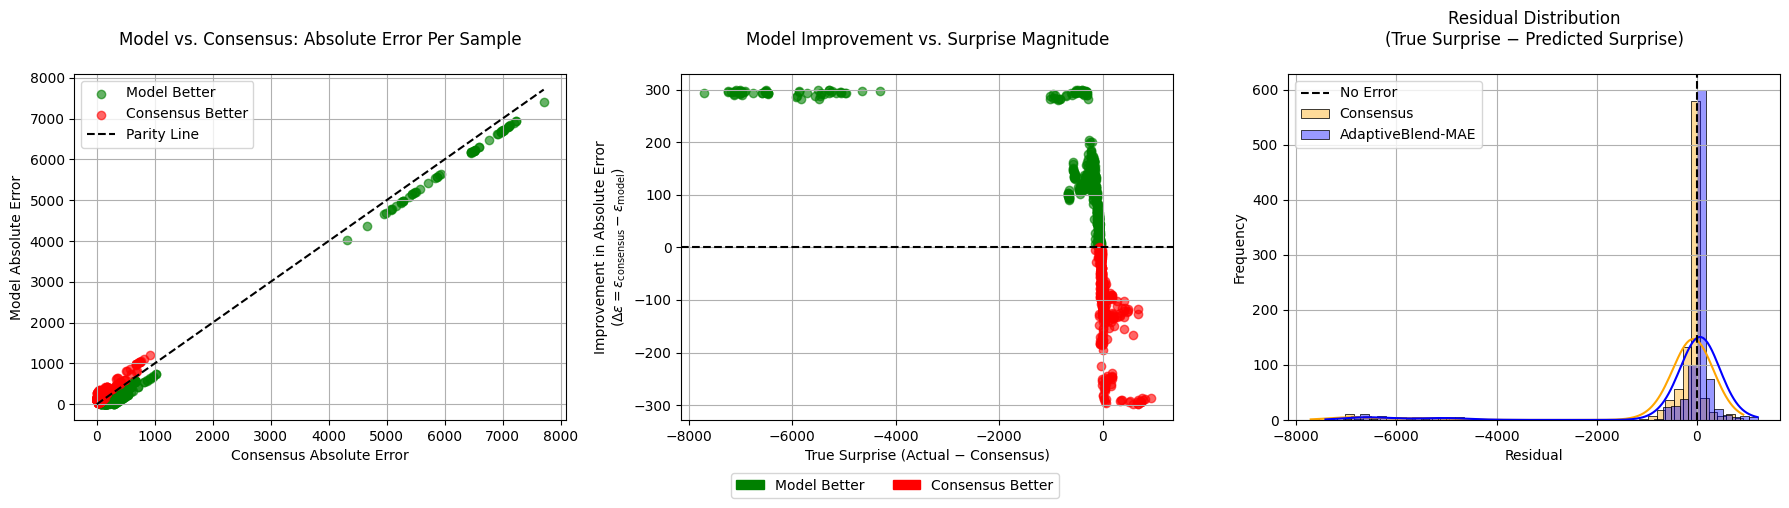


[Comparison Summary: AdaptiveBlend-MAE]
Model better in 485 of 969 samples (50.1%)
Consensus better in 484 of 969 samples (49.9%)
Tie in 0 of 969 samples (0.0%)


### Results for **Hybrid Models**

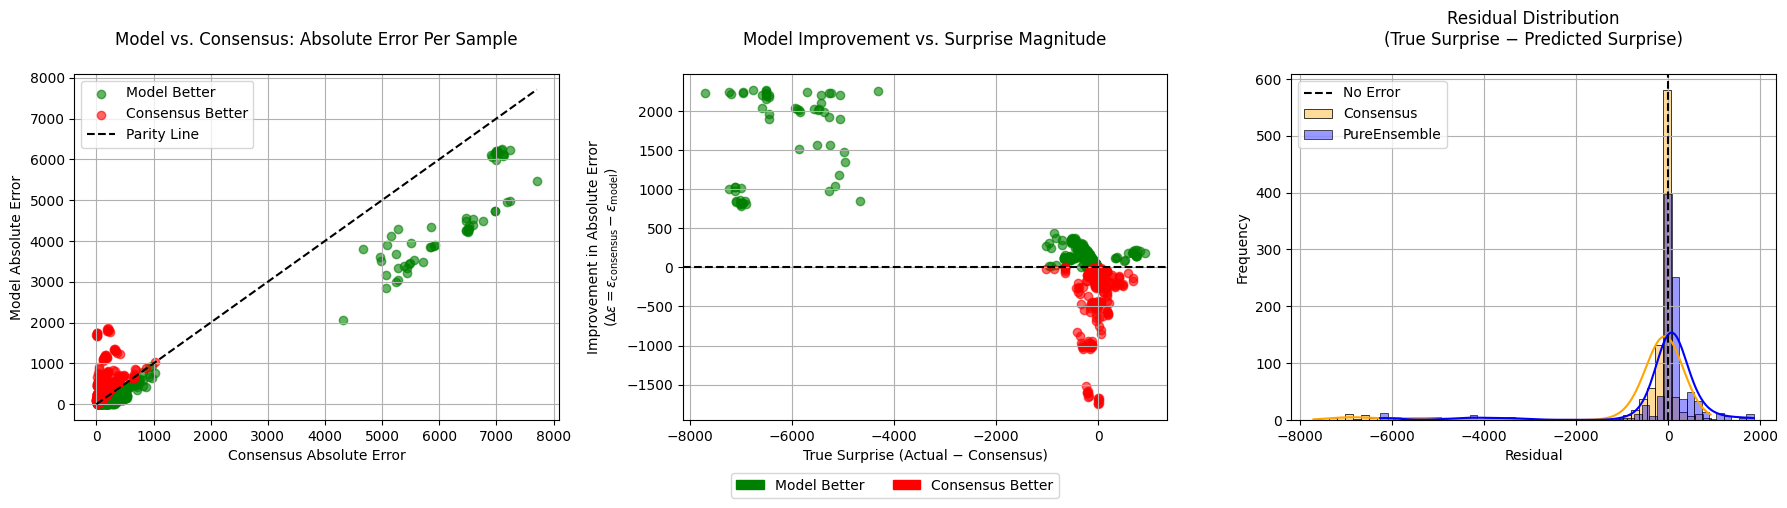


[Comparison Summary: PureEnsemble]
Model better in 457 of 969 samples (47.2%)
Consensus better in 512 of 969 samples (52.8%)
Tie in 0 of 969 samples (0.0%)


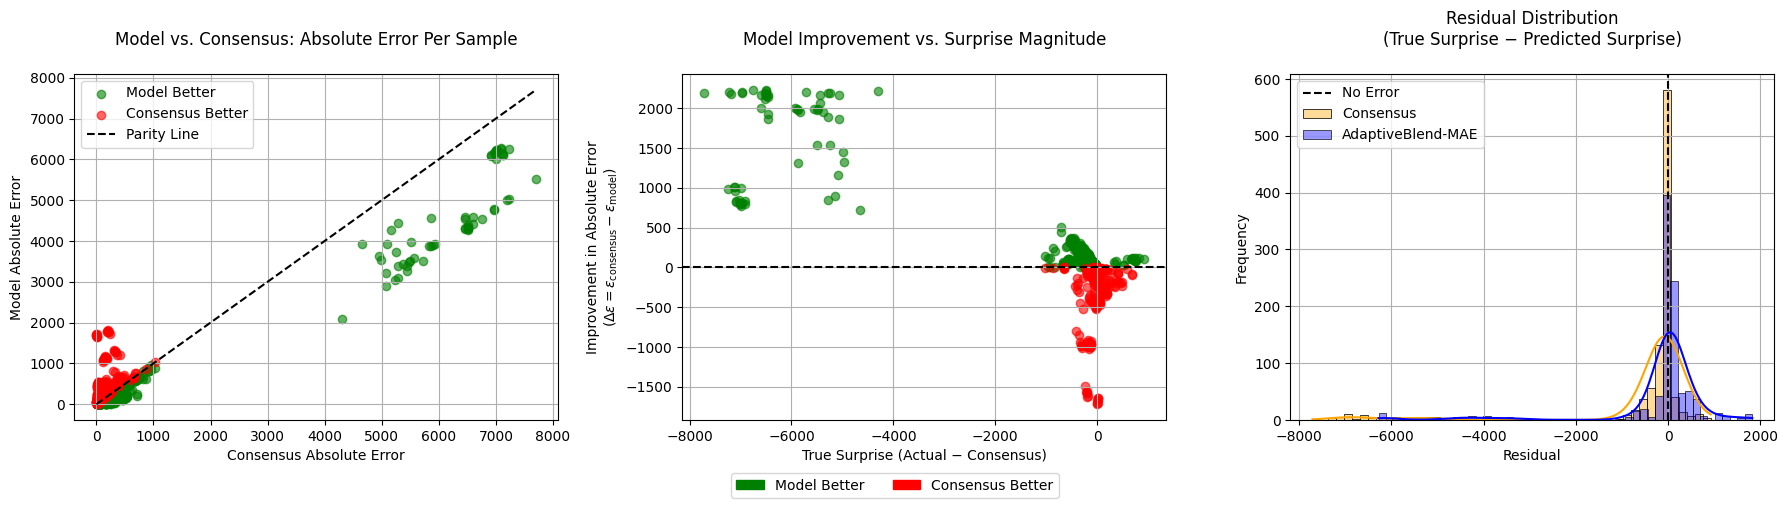


[Comparison Summary: AdaptiveBlend-MAE]
Model better in 543 of 969 samples (56.0%)
Consensus better in 426 of 969 samples (44.0%)
Tie in 0 of 969 samples (0.0%)


In [119]:
actual = test_df[f"{col_prefix}_actual"].values
consensus = test_df[f"{col_prefix}_estimate"].values

display(Markdown(f"### Results for **Language-only Models**"))
for model in ["EBITDA-MLP-Lang (PureEnsemble)","EBITDA-MLP-Lang (AdaptiveBlend-MAE)"]:
    plot_model_vs_consensus_triplet(model, actual, consensus, df=final_EBITDA_models_robustness_df, titlesuffix=False)

display(Markdown(f"### Results for **Analyst-only Models**"))
for model in ["EBITDA-MLP-Analyst (PureEnsemble)","EBITDA-MLP-Analyst (AdaptiveBlend-MAE)"]:
    plot_model_vs_consensus_triplet(model, actual, consensus, df=final_EBITDA_models_robustness_df, titlesuffix=False)

display(Markdown(f"### Results for **Hybrid Models**"))
for model in ["EBITDA-MLP-Hybrid (PureEnsemble)","EBITDA-MLP-Hybrid (AdaptiveBlend-MAE)"]:
    plot_model_vs_consensus_triplet(model, actual, consensus, df=final_EBITDA_models_robustness_df, titlesuffix=False)

In [120]:
# PureEnsemble predictions
test_df["LangOnly_PredActual_PureEnsemble"] = final_lang_test_results_df.loc[final_lang_test_results_df["Model"].str.contains("PureEnsemble"), "PredActual"].values[0]

# AdaptiveBlend-MAE predictions
test_df["LangOnly_PredActual_AdaptiveBlend"] = final_lang_test_results_df.loc[final_lang_test_results_df["Model"].str.contains("AdaptiveBlend-MAE"), "PredActual"].values[0]

# PureEnsemble predictions
test_df["AnalystOnly_PredActual_PureEnsemble"] = final_analyst_test_results_df.loc[final_analyst_test_results_df["Model"].str.contains("PureEnsemble"), "PredActual"].values[0]

# AdaptiveBlend-MAE predictions
test_df["AnalystOnly_PredActual_AdaptiveBlend"] = final_analyst_test_results_df.loc[final_analyst_test_results_df["Model"].str.contains("AdaptiveBlend-MAE"), "PredActual"].values[0]

# PureEnsemble predictions
test_df["Hybrid_PredActual_PureEnsemble"] = final_hybrid_test_results_df.loc[final_hybrid_test_results_df["Model"].str.contains("PureEnsemble"), "PredActual"].values[0]

# AdaptiveBlend-MAE predictions
test_df["Hybrid_PredActual_AdaptiveBlend"] = final_hybrid_test_results_df.loc[final_hybrid_test_results_df["Model"].str.contains("AdaptiveBlend-MAE"), "PredActual"].values[0]

In [121]:
test_df.to_csv("EBITDA_test_WITH_MODEL_PREDICTIONS.csv", index=False)

In [122]:
final_test_lang_ABmodel_tail = final_EBITDA_models_robustness_df[final_EBITDA_models_robustness_df['Model']=='EBITDA-MLP-Lang (AdaptiveBlend-MAE)'].copy()

In [123]:
final_lang_ABmodel_tail_results = evaluate_tail_behaviour(
    pred_input=final_test_lang_ABmodel_tail,
    consensus=consensus,
    actual=actual,
    model_name="EBITDA-MLP-Lang (AdaptiveBlend-MAE)",
    plot=False,
    include_baseline=True,
    log_kde_y='auto'
)
final_lang_ABmodel_tail_results

,Model,Type,MAE,RMSE,95th %ile Abs Error,Mean Abs Error in Tail,MAE on Surprise >±10%,Tail MAE (Positive Surprise),Tail MAE (Negative Surprise)
0,Baseline,baseline,522.88,1575.87,5280.23,6479.00,1206.70,271.85,4112.63
1,EBITDA-MLP-Lang (AdaptiveBlend-MAE),model,489.75,1292.79,3914.47,5211.16,969.72,403.01,3261.45


In [124]:
final_test_analyst_ABmodel_tail = final_EBITDA_models_robustness_df[final_EBITDA_models_robustness_df['Model']=='EBITDA-MLP-Analyst (AdaptiveBlend-MAE)'].copy()

In [125]:
final_analyst_ABmodel_tail_results = evaluate_tail_behaviour(
    pred_input=final_test_analyst_ABmodel_tail,
    consensus=consensus,
    actual=actual,
    model_name="EBITDA-MLP-Analyst (AdaptiveBlend-MAE)",
    plot=False,
    include_baseline=True,
    log_kde_y='auto'
)
final_analyst_ABmodel_tail_results

,Model,Type,MAE,RMSE,95th %ile Abs Error,Mean Abs Error in Tail,MAE on Surprise >±10%,Tail MAE (Positive Surprise),Tail MAE (Negative Surprise)
0,Baseline,baseline,522.88,1575.87,5280.23,6479.00,1206.70,271.85,4112.63
1,EBITDA-MLP-Analyst (AdaptiveBlend-MAE),model,506.03,1502.98,4981.52,6185.27,1118.67,444.23,3862.35


In [126]:
final_test_hybrid_ABmodel_tail = final_EBITDA_models_robustness_df[final_EBITDA_models_robustness_df['Model']=='EBITDA-MLP-Hybrid (AdaptiveBlend-MAE)'].copy()

In [127]:
final_hybrid_ABmodel_tail_results = evaluate_tail_behaviour(
    pred_input=final_test_hybrid_ABmodel_tail,
    consensus=consensus,
    actual=actual,
    model_name="EBITDA-MLP-Hybrid (AdaptiveBlend-MAE)",
    plot=False,
    include_baseline=True,
    log_kde_y='auto'
)
final_hybrid_ABmodel_tail_results

,Model,Type,MAE,RMSE,95th %ile Abs Error,Mean Abs Error in Tail,MAE on Surprise >±10%,Tail MAE (Positive Surprise),Tail MAE (Negative Surprise)
0,Baseline,baseline,522.88,1575.87,5280.23,6479.00,1206.70,271.85,4112.63
1,EBITDA-MLP-Hybrid (AdaptiveBlend-MAE),model,472.94,1224.94,3513.43,4892.28,922.79,382.47,3068.82
